In [231]:
import os
import ot
import math
import tempfile
import six.moves.urllib as urllib
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from scipy.linalg import sqrtm
from scipy import stats
from scipy.io import loadmat
from time import perf_counter
from tabulate import tabulate

# import data
path =r'/Users/shizhouxu/Documents/LIBRARY/Python/Fair_L2_Supervised_Learning/Communities-Crime/' # use your path
attrib = pd.read_csv(path + 'attributes.csv', delim_whitespace = True)
data = pd.read_csv(path + 'communities.data', names = attrib['attributes'])
data = data.drop(columns=['state','county','community','communityname','fold'], axis=1)
data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]
# clearning up the "Nan" in data
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])
data = data.dropna(axis=1)
# following "Fair Regression with Wasserstein Barycenters", we made the sensitive variable (race) binary for comparison purpose
# binary variable that indicating dominance of black race population in the community: brate_binary
brate = data['racepctblack']
np.unique(brate)
brate_binary = np.zeros(len(brate))

for i in range(0,len(brate)):
    brate_binary[i] = (brate[i] >= 0.3)*1
    
# independnet variable without race features (which are linearly dependnet of brate_binary): X_d
X_d = np.array(data.drop(['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'OwnOccLowQuart', 'OwnOccMedVal','OwnOccHiQuart', 'RentLowQ','RentMedian', 'RentHighQ', 'MedRent','NumImmig','MedNumBR', 'HousVacant', 'ViolentCrimesPerPop'],axis = 1))
# independnet variable that is a direct sum of X_d and brate_binary: X
X = np.concatenate((X_d,brate_binary[...,np.newaxis]),axis = 1)
# dependnet variable: Y
Y = np.array(data[['OwnOccLowQuart', 'OwnOccMedVal','OwnOccHiQuart', 'RentLowQ','RentMedian', 'RentHighQ', 'MedRent','NumImmig','MedNumBR', 'HousVacant', 'ViolentCrimesPerPop']])
# sensitive variable: Z
Z = X[:,86]

# five-fold cross validation data sets
trainX_list = []
trainX_d_list = []
trainY_list = []
trainZ_list = []
testX_list = []
testX_d_list = []
testY_list = []
testZ_list = []

for i in range(0,5):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, random_state=i)
    trainX_list.append(trainX)
    testX_list.append(testX)
    trainY_list.append(trainY)
    testY_list.append(testY)
    trainZ_list.append((trainX[:,86] == 1)*1)
    testZ_list.append((testX[:,86] == 1)*1)

for i in range(0,5):
    trainX_d, testX_d, trainY, testY = train_test_split(X_d, Y, test_size=0.1, random_state=i)
    trainX_d_list.append(trainX_d)
    testX_d_list.append(testX_d)

In [232]:
t = perf_counter() # time recording

# mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
X_d_mean = np.mean(X_d,axis = 0)
X_d_cov = np.cov(X_d.T)
Y_mean = np.mean(Y,axis = 0)
Y_cov = np.cov(Y.T)

# marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
X_A = X_d[Z == 0,:]
Y_A = Y[Z == 0,:]
X_C = X_d[Z == 1,:]
Y_C = Y[Z == 1,:]

X_A_mean = np.average(X_A, axis = 0)
Y_A_mean = np.average(Y_A, axis = 0)
X_C_mean = np.average(X_C, axis = 0)
Y_C_mean = np.average(Y_C, axis = 0)

X_A_cov = np.cov(X_A.T)
Y_A_cov = np.cov(Y_A.T)
X_C_cov = np.cov(X_C.T)
Y_C_cov = np.cov(Y_C.T)

# cross-covariance (matrix) between Y and X: yX_A(C)_cov
yX_A_cov = np.cov(Y_A.T, X_A.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T
yX_C_cov = np.cov(Y_C.T, X_C.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T

# algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
sample_size = len(X_d[:,0]) 
X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
eps = 10 # initialization for the stop variable

while eps > 0.0000000001:
    print(eps)
    X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
    eps = np.linalg.norm(X_bar - X_new)
    X_bar = X_new

# algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))

# wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
X_TrainFairList = []
X_TestFairList = []
X_fair = np.random.rand(X_d.shape[0],X_d.shape[1])

X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y, test_size=0.1, random_state=i)
    X_TrainFairList.append(trainX)
    X_TestFairList.append(testX)
    
# Compute the Wasserstein Pseudo-barycenter for E(Y|X)

# marginal/conditional X_fair: X_fair_A(C)
X_fair_A = X_fair[Z == 0,:]
X_fair_C = X_fair[Z == 1,:]

# mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
X_fair_A_mean = np.average(X_fair_A, axis = 0)
X_fair_C_mean = np.average(X_fair_C, axis = 0)
X_fair_A_cov = np.cov(X_fair_A.T)
X_fair_C_cov = np.cov(X_fair_C.T)

# cross-covariance between Y and X_fair: yX_fair_A(C)_cov
yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T
yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T

# covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
# which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
yoX_A_cov = yX_fair_A_cov.T@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov
yoX_C_cov = yX_fair_C_cov.T@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov

# algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
Y_bar = np.random.rand(len(Y[0,:]),len(Y[0,:]))
eps = 10

while eps > 0.0000000001:
    print(eps)
    Y_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(Y_bar)@yoX_A_cov@sqrtm(Y_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(Y_bar)@yoX_C_cov@sqrtm(Y_bar)))
    eps = np.linalg.norm(Y_bar - Y_new)
    Y_bar = Y_new

# algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
T_Y_A = np.linalg.inv(sqrtm(yoX_A_cov)) @ sqrtm( sqrtm(yoX_A_cov) @ Y_bar @ sqrtm(yoX_A_cov) ) @ np.linalg.inv(sqrtm(yoX_A_cov))
T_Y_C = np.linalg.inv(sqrtm(yoX_C_cov)) @ sqrtm( sqrtm(yoX_C_cov) @ Y_bar @ sqrtm(yoX_C_cov) ) @ np.linalg.inv(sqrtm(yoX_C_cov))

# wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
Y_TrainFairList = []
Y_TestFairList = []
Y_fair = np.random.rand(Y.shape[0],Y.shape[1])

Y_fair[Z == 0,:] = (Y[Z == 0,:] - Y_A_mean) @ T_Y_A.T + Y_mean
Y_fair[Z == 1,:] = (Y[Z == 1,:] - Y_C_mean) @ T_Y_C.T + Y_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y_fair, test_size=0.1, random_state=i)
    Y_TrainFairList.append(trainy)
    Y_TestFairList.append(testy)
    
time_fair = perf_counter() - t




10
51.71926429063606
142.53282730557322
169.3632699510939
209.00154547200208
278.5953448328857
263.9197600155744
230.39826717556156
184.31532909004235
172.90706826046022
167.0025055993176
170.74921316531072
612.4710879197145
791.9937453204457
1790.5391369582453
1043.4885587567223
822.6640406708298
866.4812116301285
900.4597842755456
1256.4339732327535
1554.5314751634821
1966.8734391236517
2270.982724302701
2502.144801416467
2684.518125912538
2758.089903292646
2874.318213081797
2797.629970633693
2749.6722191386816
2700.8846503624372
2667.618781005712
2698.177002546369
2733.6459467627374
2690.063856899704
2643.0681871806532
2633.1374093875324
2587.8266317765233
2657.1482257684784
2661.2757232149997
2790.351202873819
2815.503631507717
2951.04798025423
2984.1171811701247
3101.8555697727543
3134.598535380752
3226.4170096635075
3253.630063519511
3328.0914528785006
3349.9863096325807
3416.0830601448097
3434.3551252862226
3504.07706688639
3508.535708533551
3571.3321073441075
3565.173425905242


207.2113110496213
1163.1001477750103
1114.6457211366314
485.2330364736681
201.60826175313886
1130.3956269804255
1081.5907125775304
471.3504361622216
195.94454962102364
1097.1447424733583
1048.5762730832118
457.48364433327106
190.2521153361626
1064.635230128176
1016.6459903932583
444.1737062818904
184.83678230272218
1032.2092284146304
984.3698530913556
430.5020422993225
179.223356144398
999.6229091713303
952.2849442099721
416.9440660554546
173.6854941405865
967.2864616696019
920.6763348714233
403.56928658615044
168.19402868075102
935.5284153459704
889.711685874429
390.35882940244534
162.72337209446218
904.5852211378597
859.422693639962
377.45106234778103
157.41852655790885
873.9567281128234
829.5730476644052
364.7232545016449
152.19030046062466
843.6522265336338
800.0911539267624
352.09918559751674
147.01026944889688
813.8457701003953
771.2411375318196
339.7565044634384
141.9167950516718
784.7970775303802
743.0747324883554
327.6670531978959
136.93017773054507
756.5245598964144
715.78742

0.34338891587153836
0.2535212234585568
0.19972977443054912
0.34263260697464065
0.2255605599185551
0.47125652591417067
0.7216520128072678
0.8790928050163624
0.949111657092208
0.9548520365388689
0.9200452192781826
0.8637439074034408
0.7993987344473023
0.7355332614371068
0.6768715795916975
0.625470995561209
0.5816904606100589
0.5449382789975179
0.5141966667056515
0.48835176662349816
0.46637333814867027
0.4473919209495318
0.4307144923534687
0.41580897150182966
0.402276843864857
0.38982416345036186
0.3782358778346533
0.3673549762723381
0.3570664349067708
0.34728526459131126
0.33794784438038417
0.3290056394546651
0.3204208014867167
0.3121630350590734
0.3042074737438522
0.29653309936512917
0.2891217505820454
0.28195735907553526
0.2750254878763561
0.2683129428859856
0.26180756459319027
0.2554980202135218
0.2493737372583862
0.24342477366665238
0.23764177840663564
0.23201592833111703
0.2265388871652324
0.22120279280518193
0.21600019294978054
0.210924042115334
0.20596766395871613
0.20112472896087

0.0006484089170111754
0.0006446279491562142
0.0006408728075268291
0.000637143260641102
0.0006334390731669394
0.0006297600141296297
0.000626105850241669
0.0006224763659941221
0.0006188713308137254
0.0006152905287526646
0.0006117337408284915
0.0006082007550985497
0.0006046913645591658
0.0006012053563354512
0.0005977425302100924
0.0005943026799456992
0.0005908855998495212
0.0005874910977428635
0.0005841189776310355
0.0005807690450236281
0.0005774411122068855
0.0005741349893507097
0.000570850490740979
0.0005675874337802762
0.0005643456347774956
0.0005611249147537435
0.0005579250993556095
0.0005547460091961576
0.000551587474520443
0.0005484493254471241
0.0005453313912569022
0.0005422335079841641
0.0005391555103013499
0.0005360972316173511
0.0005330585132445109
0.0005300391960475306
0.0005270391243685328
0.0005240581396390726
0.0005210960917648564
0.0005181528229173283
0.0005152281888768343
0.0005123220393498235
0.0005094342300321958
0.0005065646120538128
0.0005037130434998497
0.000500879380

8.983895746269207e-05
8.937255022314928e-05
8.890861122445883e-05
8.844712649655583e-05
8.798808296347378e-05
8.753146701142247e-05
8.707726590214651e-05
8.662546593060351e-05
8.617605462135273e-05
8.572901908603655e-05
8.52843456069014e-05
8.484202143156042e-05
8.440203454307343e-05
8.396437141513508e-05
8.352901975719991e-05
8.309596711726575e-05
8.266520101270803e-05
8.223670900957181e-05
8.181047871632058e-05
8.138649805293584e-05
8.09647544299499e-05
8.054523524546987e-05
8.012792976064306e-05
7.971282531521222e-05
7.929990989781722e-05
7.888917212311956e-05
7.848059936270581e-05
7.807418012338662e-05
7.766990343812838e-05
7.726775686879465e-05
7.68677290385838e-05
7.646980863345576e-05
7.60739846891523e-05
7.568024565294484e-05
7.528857970103751e-05
7.489897647352153e-05
7.451142324695153e-05
7.412591106273772e-05
7.374242770134019e-05
7.336096211057185e-05
7.298150378279818e-05
7.260404171446501e-05
7.222856512499681e-05
7.185506331470748e-05
7.148352597377264e-05
7.111394206669

1.3506931317884466e-05
1.343845231578843e-05
1.3370323292931059e-05
1.3302542385360179e-05
1.323510793047441e-05
1.3168018058377901e-05
1.3101271075481932e-05
1.3034865105577067e-05
1.2968798449104827e-05
1.2903069319313376e-05
1.2837675930907772e-05
1.2772616667400326e-05
1.270788980567092e-05
1.2643493498570804e-05
1.2579426090624973e-05
1.2515685901985143e-05
1.2452271198109202e-05
1.2389180393516828e-05
1.232641175191104e-05
1.2263963577289666e-05
1.2201834238407013e-05
1.214002229816582e-05
1.2078525907253019e-05
1.2017343359252431e-05
1.1956473100772475e-05
1.189591358645564e-05
1.1835663212311244e-05
1.1775720278414938e-05
1.1716083376660337e-05
1.1656750782367387e-05
1.1597720955514538e-05
1.1538992475727112e-05
1.1480563595878846e-05
1.1422432838601456e-05
1.1364598627369766e-05
1.1307059469246304e-05
1.1249813891879021e-05
1.1192860307076486e-05
1.113619724779908e-05
1.1079823289942086e-05
1.1023736787775157e-05
1.0967936384305972e-05
1.0912420596296538e-05
1.085718782547528e

2.094070554762276e-06
2.0835703918200813e-06
2.073123097598827e-06
2.0627284035253044e-06
2.0523860491599822e-06
2.042095762726222e-06
2.031857285461781e-06
2.0216703539078164e-06
2.0115347189948293e-06
2.001450106367324e-06
1.9914162555651437e-06
1.9814329194152917e-06
1.971499835716628e-06
1.9616167527033298e-06
1.951783420033711e-06
1.941999577901107e-06
1.93226497753278e-06
1.9225793734320364e-06
1.912942519634181e-06
1.9033541782120076e-06
1.893814076443627e-06
1.8843219917564427e-06
1.8748776823605565e-06
1.8654808961351436e-06
1.856131406057777e-06
1.8468289482099037e-06
1.8375733072526124e-06
1.8283642376214405e-06
1.8192015129013842e-06
1.8100848761081492e-06
1.8010141129512071e-06
1.7919889875996639e-06
1.7830092644594686e-06
1.7740747114058634e-06
1.76518512090476e-06
1.7563402484013502e-06
1.747539874539836e-06
1.7387837753478047e-06
1.7300717164206472e-06
1.7214034789257192e-06
1.7127788393690014e-06
1.7041975805844991e-06
1.6956594888185222e-06
1.6871643404398472e-06
1.67

3.312604989245436e-07
3.29609147794434e-07
3.279660472995381e-07
3.2633115615314646e-07
3.247044345902748e-07
3.2308583851194937e-07
3.2147533314021715e-07
3.198728733005006e-07
3.182784180419179e-07
3.1669192853202877e-07
3.1511336738464614e-07
3.135426917832101e-07
3.1197986368353727e-07
3.1042484436472857e-07
3.0887759078490704e-07
3.0733806647914586e-07
3.058062346509857e-07
3.0428205317145885e-07
3.027654883639304e-07
3.012564988715751e-07
2.997550474215023e-07
2.9826109489555764e-07
2.967746063773411e-07
2.9529554079135157e-07
2.938238621364105e-07
2.923595371036935e-07
2.9090252708512575e-07
2.894527934720829e-07
2.8801030010527934e-07
2.865750131697739e-07
2.8514689275266393e-07
2.83725905436093e-07
2.823120153929501e-07
2.809051856974725e-07
2.7950538315905905e-07
2.781125715471092e-07
2.767267164223278e-07
2.753477821627143e-07
2.739757318073676e-07
2.7261053528823524e-07
2.712521581388147e-07
2.699005635819777e-07
2.6855571648724426e-07
2.6721758663176054e-07
2.6588613754477

5.336099821477897e-08
5.309586243542558e-08
5.283204604828397e-08
5.2569542176070733e-08
5.230834426730881e-08
5.204844554959658e-08
5.178984017427472e-08
5.153252134927852e-08
5.127648254543597e-08
5.102171775762161e-08
5.076822058343671e-08
5.0515984471344654e-08
5.0265003676273777e-08
5.001527109849722e-08
4.9766780753043254e-08
4.95195267751528e-08
4.927350267225673e-08
4.9028702871375516e-08
4.8785121071058916e-08
4.854275070728456e-08
4.830158591352418e-08
4.8061620857088785e-08
4.7822849755217275e-08
4.758526635408716e-08
4.734886508198016e-08
4.7113639445005304e-08
4.687958385654337e-08
4.664669245325971e-08
4.6414959833847826e-08
4.618438002896074e-08
4.595494681231387e-08
4.572665520137924e-08
4.5499498800189884e-08
4.52734725078128e-08
4.504857035695943e-08
4.482478718582192e-08
4.4602116863280106e-08
4.438055441140185e-08
4.4160093733992635e-08
4.394072952273336e-08
4.372245681831641e-08
4.3505269438197885e-08
4.328916228771264e-08
4.3074129991019036e-08
4.286016728938356e-

8.635799455579876e-09
8.592974064240591e-09
8.550361116664013e-09
8.507959723612542e-09
8.465768796333828e-09
8.423787178002139e-09
8.382013979000526e-09
8.340448139118717e-09
8.299088520049345e-09
8.257934209357511e-09
8.216984139643961e-09
8.176237210672224e-09
8.135692665896555e-09
8.0953491821687e-09
8.05520599590378e-09
8.015262082235618e-09
7.975516308029271e-09
7.935967761714159e-09
7.896615580593106e-09
7.857458663461314e-09
7.818496112084356e-09
7.779726853481265e-09
7.741149993649896e-09
7.702764579472337e-09
7.664569642641652e-09
7.626564247145642e-09
7.58874750731351e-09
7.551118333035867e-09
7.513675950432945e-09
7.47641942156238e-09
7.439347748210569e-09
7.402460023854623e-09
7.365755328834772e-09
7.329232814765141e-09
7.292891503374895e-09
7.256730610990615e-09
7.220749075576922e-09
7.184946081895163e-09
7.149320839000521e-09
7.113872316190353e-09
7.078599705146989e-09
7.04350209793513e-09
7.0085786900936434e-09
6.973828580438097e-09
6.939250838574283e-09
6.9048446874436

1.3807961023397828e-09
1.373956942017605e-09
1.367151656597664e-09
1.3603799669247545e-09
1.3536419219851193e-09
1.3469372489930479e-09
1.3402658975729732e-09
1.333627568894036e-09
1.3270220673258752e-09
1.3204493198211152e-09
1.3139091229580153e-09
1.3074013790628604e-09
1.3009258854340566e-09
1.294482389806547e-09
1.2880709572620518e-09
1.281691200100847e-09
1.2753431086241592e-09
1.269026420095957e-09
1.2627410834268471e-09
1.256486927677695e-09
1.2502637354891483e-09
1.2440713668774305e-09
1.2379096032190614e-09
1.2317784330613614e-09
1.2256776866284746e-09
1.219607173559687e-09
1.2135667080599287e-09
1.2075562261504955e-09
1.2015753838079472e-09
1.1956242801014118e-09
1.189702700132857e-09
1.1838103294590153e-09
1.1779473432996305e-09
1.172113319591973e-09
1.166308227751909e-09
1.1605318306926122e-09
1.154784125691719e-09
1.1490648595489728e-09
1.143373969081701e-09
1.1377112973038712e-09
1.132076551686155e-09
1.1264698710804881e-09
1.1208908966361527e-09
1.115339607353707e-09
1.1

2.211682643311225e-10
2.2007352316662633e-10
2.1898467964046258e-10
2.1790065154120138e-10
2.1682196479094543e-10
2.1574884894191983e-10
2.146809833117317e-10
2.136184676937746e-10
2.1256119754513151e-10
2.115093725598076e-10
2.1046241353189456e-10
2.0942069076105467e-10
2.0838434434251694e-10
2.0735312498182224e-10
2.06326761446044e-10
2.0530571766347561e-10
2.0428947428422465e-10
2.0327837395313864e-10
2.022723445966323e-10
2.0127123233588644e-10
2.0027502414985408e-10
1.992837242341839e-10
1.9829767922247238e-10
1.973162305611786e-10
1.9633946209274378e-10
1.9536792920080397e-10
1.944009115332284e-10
1.9343872920740012e-10
1.9248141329798486e-10
1.9152883496613889e-10
1.9058099173634614e-10
1.896377592989522e-10
1.8869917610127177e-10
1.8776534432905145e-10
1.8683611540016773e-10
1.8591141269754902e-10
1.8499125967952027e-10
1.8407589226158616e-10
1.831647635142717e-10
1.8225812549210564e-10
1.8135632664029675e-10
1.8045875640747216e-10
1.795656913527402e-10
1.7867695634010968e-10
1

<ipython-input-232-b0a5bc78b020>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-232-b0a5bc78b020>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean


10
5.707014245405066
1.1392613954547466
0.6330234857113225
0.3532250828828377
0.20150586851970145
0.1346540345358555
0.10783503165551722
0.09222914666785384
0.07795209629601162
0.06485114723709828
0.05408687394163811
0.04588569735264664
0.03971093162907491
0.034873391587194755
0.03089618236930244
0.02754700974819154
0.024725342065189757
0.02236841472694765
0.020414840259966986
0.018800196727070794
0.01746140491135235
0.016341583369736085
0.015393248720127706
0.014579320280567406
0.013872287882120268
0.013252328244370358
0.012705157980180622
0.012220112488024317
0.011788668523199724
0.011403458078182507
0.011057711023556526
0.010745026431804243
0.010459360028609975
0.010195124756558118
0.009947325595062622
0.00971166975378767
0.009484625269210852
0.009263423948865493
0.009046015551852797
0.008830984685435065
0.008617451737820532
0.008404966560148226
0.00819340904328008
0.007982898721048643
0.0077737195718392965
0.007566258270271337
0.007360956675298905
0.007158274299646778
0.00695866199

0.00020629235713941384
0.00020509969170044528
0.00020391413603369982
0.00020273564925047028
0.00020156419102762183
0.000200399705893907
0.00019924215141181448
0.00019809149203611523
0.00019694767628420048
0.00019581065082642204
0.00019468039010185937
0.0001935568367945657
0.00019243994945579462
0.00019132968875079488
0.00019022601208132985
0.00018912887316349707
0.0001880382316506656
0.00018695405782096348
0.00018587629157188864
0.00018480490172560066
0.00018373985173931085
0.00018268109770368715
0.00018162859455142033
0.00018058230143311462
0.00017954219131781593
0.0001785082183146462
0.00017748034452237855
0.00017645853232297714
0.00017544273247901523
0.00017443291871090404
0.00017342905312876786
0.0001724310929542906
0.00017143900634078132
0.00017045275078053805
0.00016947230028412135
0.0001684976090055587
0.00016752864249976036
0.000166565370423419
0.00016560775133082103
0.00016465574678503785
0.00016370933255649534
0.00016276846382068863
0.00016183311027691136
0.000160903241579290

1.7996952473391413e-05
1.789451023067791e-05
1.77926510145174e-05
1.769137152872802e-05
1.7590669466599482e-05
1.7490539865754776e-05
1.7390980427081858e-05
1.7291987788818498e-05
1.7193559036086834e-05
1.7095690484889197e-05
1.699837950175904e-05
1.6901621812031098e-05
1.6805415037092858e-05
1.6709756254553655e-05
1.6614641528050836e-05
1.6520069650772025e-05
1.6426035269063743e-05
1.633253579215464e-05
1.6239569494605914e-05
1.6147132076626477e-05
1.605522014543469e-05
1.5963832328273828e-05
1.5872965244557124e-05
1.578261479820964e-05
1.5692778631476672e-05
1.5603454203112373e-05
1.5514638276557897e-05
1.5426327857329103e-05
1.5338520257783683e-05
1.525121240315416e-05
1.5164401367857794e-05
1.5078084946276232e-05
1.4992260525177012e-05
1.4906923801358297e-05
1.482207333913609e-05
1.4737705017331353e-05
1.4653817203301206e-05
1.4570407160283295e-05
1.4487472555630567e-05
1.4405009743308979e-05
1.4323016620116446e-05
1.4241489438735214e-05
1.4160426915599248e-05
1.4079825777796429e-0

1.855955431098203e-06
1.8453919249170164e-06
1.834888506831983e-06
1.824444950174441e-06
1.8140608199314281e-06
1.80373572521844e-06
1.7934694971911206e-06
1.7832615702165184e-06
1.77311180437881e-06
1.7630198210310348e-06
1.752985296506658e-06
1.7430079005816098e-06
1.7330872431964824e-06
1.7232230393464692e-06
1.7134150429419524e-06
1.7036628001681278e-06
1.6939661277244735e-06
1.6843246611459701e-06
1.6747379604971718e-06
1.6652059025251937e-06
1.6557281288174082e-06
1.6463042324388182e-06
1.636933964505877e-06
1.6276171109864183e-06
1.6183532595171757e-06
1.609142103381882e-06
1.5999833465570428e-06
1.5908767563226792e-06
1.5818219902732249e-06
1.5728187732245751e-06
1.5638667710854695e-06
1.5549657762824549e-06
1.546115410292893e-06
1.5373154263142972e-06
1.5285654944020656e-06
1.519865388138905e-06
1.5112148618269575e-06
1.5026134839578089e-06
1.4940611216128714e-06
1.4855574113864594e-06
1.4771020941969222e-06
1.468694868253525e-06
1.4603355062048508e-06
1.4520237657231653e-06
1

1.6036470141847487e-07
1.5945195603426382e-07
1.585444092364463e-07
1.5764202529142162e-07
1.5674477701835243e-07
1.5585263087397004e-07
1.5496557027012414e-07
1.5408356341992052e-07
1.5320656844037817e-07
1.5233456573906142e-07
1.5146752455048307e-07
1.5060542151631252e-07
1.4974822448606127e-07
1.488958996235653e-07
1.4804843994589157e-07
1.472057952817761e-07
1.46367946736337e-07
1.4553486602083903e-07
1.4470652759634114e-07
1.4388290920151814e-07
1.4306397435209463e-07
1.4224969746244807e-07
1.414400643153862e-07
1.406350306148213e-07
1.3983458535206941e-07
1.390386918793285e-07
1.3824732739616051e-07
1.3746046913091794e-07
1.3667808988662656e-07
1.3590016143620325e-07
1.3512665905954702e-07
1.3435756298041953e-07
1.335928465509759e-07
1.3283248105775826e-07
1.3207643717689383e-07
1.3132469909644138e-07
1.305772410834688e-07
1.2983403722205125e-07
1.2909506483353177e-07
1.283603023535457e-07
1.2762971463071487e-07
1.2690328829693526e-07
1.261809964045068e-07
1.2546281341223047e-07


1.385639070503456e-08
1.3777525076341525e-08
1.3699107785708422e-08
1.3621136851661893e-08
1.354360979133343e-08
1.3466523769631056e-08
1.3389877036925662e-08
1.331366609439311e-08
1.32378892330823e-08
1.3162543296314206e-08
1.3087626269995652e-08
1.3013135628611968e-08
1.2939069331126727e-08
1.286542449353577e-08
1.2792198162517313e-08
1.2719389255491224e-08
1.2646994279524119e-08
1.2575012257804958e-08
1.2503439219463845e-08
1.2432273681740805e-08
1.2361513253710542e-08
1.2291155527521765e-08
1.2221198343975543e-08
1.2151638913800638e-08
1.2082475752862596e-08
1.201370631379806e-08
1.1945328325224321e-08
1.1877339381805896e-08
1.1809737691894841e-08
1.174251981207958e-08
1.1675685205028514e-08
1.160923118316446e-08
1.154315531806455e-08
1.1477455226111968e-08
1.1412129321727737e-08
1.134717506002583e-08
1.128259066824916e-08
1.121837359931518e-08
1.1154522356349146e-08
1.1091034515023187e-08
1.1027907883814092e-08
1.0965140905101024e-08
1.0902731154516268e-08
1.0840675953642309e-08
1

1.183678078711391e-09
1.17694105900627e-09
1.1702422192639917e-09
1.1635816251113302e-09
1.1569589676241777e-09
1.1503739295748055e-09
1.1438262795665327e-09
1.137316158913839e-09
1.1308427372392076e-09
1.1244063708524988e-09
1.1180064657814473e-09
1.1116431189822206e-09
1.10531611873612e-09
1.099025065798002e-09
1.0927697160669799e-09
1.0865499817245347e-09
1.0803658540383245e-09
1.0742166292285634e-09
1.0681028145069634e-09
1.0620235467394463e-09
1.0559785491815247e-09
1.0499682411005736e-09
1.043992106897504e-09
1.0380502221838055e-09
1.032141865053808e-09
1.026267497789327e-09
1.0204259897653602e-09
1.0146182073177151e-09
1.0088434610726102e-09
1.0031015960328828e-09
9.973920423796849e-10
9.917153710345015e-10
9.860706899841897e-10
9.804582793707932e-10
9.748778303140324e-10
9.693291592680208e-10
9.638119099455407e-10
9.583264046695554e-10
9.528720374072316e-10
9.474484624566818e-10
9.420557273252982e-10
9.366939338025116e-10
9.313627965692596e-10
9.2606162790657e-10
9.207907546101

<ipython-input-232-b0a5bc78b020>:97: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_fair[Z == 0,:] = (Y[Z == 0,:] - Y_A_mean) @ T_Y_A.T + Y_mean
<ipython-input-232-b0a5bc78b020>:98: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_fair[Z == 1,:] = (Y[Z == 1,:] - Y_C_mean) @ T_Y_C.T + Y_mean


In [233]:
X_train_path_list = []
X_test_path_list = []
Y_train_path_list = []
Y_test_path_list = []
T = np.linspace(0,1,50) # discretize time variable T

# Algorithm 1, step 3: estimate of the independent variable (X) geodesic path using McCann interpolation
for i in range(0,len(trainX_list)):
    X_d = trainX_d_list[i]
    Y = trainY_list[i]
    Z = trainZ_list[i]
    Z_test = testZ_list[i]
    # mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
    X_d_mean = np.mean(X_d,axis = 0)
    X_d_cov = np.cov(X_d.T)
    Y_mean = np.mean(Y, axis = 0)
    Y_cov = np.cov(Y.T)
    # marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
    X_A = X_d[Z == 0,:]
    Y_A = Y[Z == 0,:]
    X_C = X_d[Z == 1,:]
    Y_C = Y[Z == 1,:]
    X_A_mean = np.average(X_A, axis = 0)
    Y_A_mean = np.average(Y_A, axis = 0)
    X_C_mean = np.average(X_C, axis = 0)
    Y_C_mean = np.average(Y_C, axis = 0)
    X_A_cov = np.cov(X_A.T)
    Y_A_cov = np.cov(Y_A.T)
    X_C_cov = np.cov(X_C.T)
    Y_C_cov = np.cov(Y_C.T)
    # cross-covariance (matrix) between Y and X: yX_A(C)_cov
    yX_fair_A_cov = np.cov(Y_A.T, X_A.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T
    yX_fair_C_cov = np.cov(Y_C.T, X_C.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T
    # algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.00000000000
    sample_size = len(X_d[:,0]) 
    X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
    eps = 10 # initialization for the stop variable
    while eps > 0.000000000001:
        print(eps)
        X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
        eps = np.linalg.norm(X_bar - X_new)
        X_bar = X_new
    # algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
    T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
    T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))
    # wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
    X_fair = np.random.rand(X_d.shape[0],X_d.shape[1])
    X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
    X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean
    # generate the geodesic path
    X_train_path = []
    X_test_path = []
    for t in range(0,len(T)):
        temp = np.zeros(X_d.shape)
        temp_test = np.zeros(testX_d_list[i].shape)
        temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        temp_test[Z_test == 0,:] = (1-T[t])*testX_d_list[i][Z_test == 0,:] + T[t]*((testX_d_list[i][Z_test == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp_test[Z_test == 1,:] = (1-T[t])*testX_d_list[i][Z_test == 1,:] + T[t]*((testX_d_list[i][Z_test == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        
        # Algorithm 1, step 4: merge the corresponding (wrt t) linear interpolation of sensitive variable back to the MacCann interpolation of dependnet variable
        temp_more = np.concatenate((temp, Z[...,np.newaxis]),axis = 1)
        temp_more_test = np.concatenate((temp_test, Z_test[...,np.newaxis]),axis = 1)
        X_train_path.append(temp_more)
        X_test_path.append(temp_more_test)
    
    # Compute the Wasserstein Pseudo-barycenter for E(Y|X)
    # marginal/conditional X_fair: X_fair_A(C)
    X_fair_A = X_fair[Z == 0,:]
    X_fair_C = X_fair[Z == 1,:]
    # mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
    X_fair_A_mean = np.average(X_fair_A, axis = 0)
    X_fair_C_mean = np.average(X_fair_C, axis = 0)
    X_fair_A_cov = np.cov(X_fair_A.T)
    X_fair_C_cov = np.cov(X_fair_C.T)
    
    # cross-covariance between Y and X_fair: yX_fair_A(C)_cov
    yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T
    yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[: Y.shape[1], range(Y.shape[1], Y.shape[1] + X_d.shape[1])].T
    # covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
    # which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
    yoX_A_cov = yX_fair_A_cov.T@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov
    yoX_C_cov = yX_fair_C_cov.T@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov
    # algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    Y_bar = np.random.rand(len(Y[0,:]),len(Y[0,:])) 
    eps = 10
    while eps > 0.000000000001:
        print(eps)
        Y_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(Y_bar)@yoX_A_cov@sqrtm(Y_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(Y_bar)@yoX_C_cov@sqrtm(Y_bar)))
        eps = np.linalg.norm(Y_bar - Y_new)
        Y_bar = Y_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
    T_Y_A = np.linalg.inv(sqrtm(yoX_A_cov)) @ sqrtm( sqrtm(yoX_A_cov) @ Y_bar @ sqrtm(yoX_A_cov) ) @ np.linalg.inv(sqrtm(yoX_A_cov))
    T_Y_C = np.linalg.inv(sqrtm(yoX_C_cov)) @ sqrtm( sqrtm(yoX_C_cov) @ Y_bar @ sqrtm(yoX_C_cov) ) @ np.linalg.inv(sqrtm(yoX_C_cov))
    # wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
    Y_fair = np.random.rand(Y.shape[0],Y.shape[1])
    Y_fair[Z == 0] = (Y[Z == 0] - Y_A_mean) @ T_Y_A.T + Y_mean
    Y_fair[Z == 1] = (Y[Z == 1] - Y_C_mean) @ T_Y_C.T + Y_mean
    # generate the geodesic path
    Y_train_path = []
    Y_test_path = []
    for t in range(0,len(T)):
        temp = np.zeros(Y.shape)
        temp_test = np.zeros(testY_list[i].shape)
        temp[Z == 0,:] = (1-T[t])*Y[Z == 0,:] + T[t]*((Y[Z == 0,:] - Y_A_mean) @ T_Y_A.T + Y_mean)
        temp[Z == 1,:] = (1-T[t])*Y[Z == 1,:] + T[t]*((Y[Z == 1,:] - Y_C_mean) @ T_Y_C.T + Y_mean)
        temp_test[Z_test == 0,:] = (1-T[t])*testY_list[i][Z_test == 0,:] + T[t]*((testY_list[i][Z_test == 0,:] - Y_A_mean) @ T_Y_A.T + Y_mean)
        temp_test[Z_test == 1,:] = (1-T[t])*testY_list[i][Z_test == 1,:] + T[t]*((testY_list[i][Z_test == 1,:] - Y_C_mean) @ T_Y_C.T + Y_mean)
        Y_train_path.append(temp)
        Y_test_path.append(temp_test)
        
    X_train_path_list.append(X_train_path)
    X_test_path_list.append(X_test_path)
    Y_train_path_list.append(Y_train_path)
    Y_test_path_list.append(Y_test_path)

10
59.045271404060614
42.49499670769799
49.114650136561956
36.81406932454868
30.713375013300254
39.28719981869448
51.318380694508626
191.76438851716722
148.9571752517813
99.7713607332198
70.86014956450153
58.61830505264843
273.1179435698285
203.74165917082135
141.23379674734755
69.21283341523055
303.9143428003415
221.60492481547374
131.29414615074458
63.48351657727441
297.4441839823837
222.73030975423993
127.7498141287639
60.497178173801366
292.8180366429337
231.23119545847078
140.36651537954324
65.12965025961294
289.4326335992531
226.10740548974695
141.84602659613665
64.62615182230289
274.016552915864
209.81274415625288
132.6600864345623
61.23931988974588
247.95862135524297
189.44876541491803
129.2756871244227
65.84053626364611
54.33867648832269
297.0540885596957
231.07963807937702
100.47239328278609
87.08799249164763
68.18117223405731
63.291984864927386
99.89502428044146
171.46546256717443
100.59604420308429
89.29817144179782
71.01679117123987
60.681369314304206
253.0219886081801
210

0.035795076913397485
0.03520845062039514
0.03463485472845723
0.03407395135869298
0.03352539658429273
0.032988853026937
0.03246400954885648
0.03195054128634024
0.031448142259871956
0.030956506497493746
0.030475340819471303
0.03000435946244026
0.029543287385768013
0.02909185075534674
0.028649791298222017
0.02821684860806173
0.027792783663076102
0.027377353063504313
0.02697032688772627
0.02657148157149432
0.02618059393659467
0.025797457348335225
0.025421868497780498
0.025053625372069673
0.02469254143035379
0.024338435219791774
0.023991126560332844
0.02365043864975407
0.02331620876486101
0.02298827215006264
0.022666470613148727
0.022350661258559414
0.022040690914279036
0.021736416301574968
0.02143770268927935
0.021144420260236087
0.020856436629210957
0.020573628799204612
0.02029587661944469
0.020023063579004984
0.01975507790512501
0.019491809754906057
0.019233152831449482
0.018979003483479983
0.01872926120778391
0.018483830234834197
0.018242615642168496
0.018005528921204047
0.0177724815970

0.0010733235251377783
0.0010667454105313997
0.0010602127896613966
0.0010537252950479237
0.001047282497127961
0.001040884077057441
0.0010345296560283126
0.0010282188611228417
0.0010219513253325908
0.0010157267138732548
0.0010095446508615771
0.001003404806698542
0.0009973068152057912
0.000991250346280106
0.0009852350641935933
0.0009792606041239694
0.0009733266703137111
0.0009674329099742984
0.0009615790031628476
0.0009557646290780847
0.0009499894642792362
0.0009442532001355026
0.0009385555217980569
0.0009328961180042422
0.0009272746728901175
0.0009216908899756457
0.0009161444690341355
0.0009106351106019552
0.0009051625282167227
0.0008997264232046577
0.0008943264987444609
0.0008889624775063192
0.0008836340822554812
0.000878341013976716
0.0008730830045412188
0.0008678597773807311
0.0008626710609761886
0.0008575165902028263
0.0008523960849758241
0.0008473092894297008
0.0008422559475067472
0.0008372357814343006
0.0008322485445555154
0.0008272939862483511
0.0008223718535009895
0.0008174818895

0.0001309411831885126
0.00013021952394363722
0.00012950189811980958
0.00012878828283936715
0.0001280786547869762
0.00012737299105750201
0.00012667127038784506
0.00012597346869498585
0.0001252795642376156
0.00012458953370166612
0.0001239033569577698
0.000123221010248044
0.00012254247240205186
0.00012186772112635636
0.00012119673557740813
0.00012052949404553461
0.00011986597523372534
0.00011920615738963653
0.00011855001985173887
0.00011789754207793251
0.00011724870276072709
0.00011660348040481773
0.00011596185594175387
0.00011532380737898011
0.00011468931508513669
0.00011405835949489168
0.00011343091919227524
0.00011280697380306847
0.00011218650594087486
0.00011156949389356561
0.00011095591836803366
0.00011034575984531518
0.00010973899917840779
0.0001091356163374307
0.00010853559311178206
0.00010793890973407697
0.00010734554757151496
0.00010675548737903858
0.00010616871079025631
0.0001055851986611362
0.00010500493413404735
0.00010442789594148487
0.00010385406833387123
0.00010328343242090

1.739770588417436e-05
1.730355699927497e-05
1.7209921006081432e-05
1.711679500699482e-05
1.7024176337372325e-05
1.6932062059663083e-05
1.6840449511099748e-05
1.6749335863080788e-05
1.665871840304049e-05
1.6568594455007315e-05
1.6478961271881438e-05
1.638981613276556e-05
1.630115653162102e-05
1.6212979552092034e-05
1.612528271785824e-05
1.6038063381098375e-05
1.595131877052749e-05
1.5865046485123125e-05
1.577924377360659e-05
1.569390816747618e-05
1.560903709226276e-05
1.5524628067594056e-05
1.5440678416488454e-05
1.5357185676926e-05
1.5274147329080982e-05
1.5191560846479758e-05
1.5109423799573689e-05
1.5027733770940407e-05
1.4946488252369345e-05
1.4865684756990616e-05
1.4785321073184066e-05
1.47053945711848e-05
1.462590286379558e-05
1.4546843680976943e-05
1.4468214542641546e-05
1.4390013208475977e-05
1.4312237387003156e-05
1.4234884549262597e-05
1.4157952366598e-05
1.4081438720202338e-05
1.4005341304523857e-05
1.3929657685247803e-05
1.3854385623668433e-05
1.3779522940463718e-05
1.370506

2.378200964230299e-06
2.3654851766804894e-06
2.352837793818926e-06
2.3402584038672858e-06
2.32774664940911e-06
2.3153021690959106e-06
2.3029246126511955e-06
2.2906136147847804e-06
2.2783687981601292e-06
2.266189827519774e-06
2.254076331196052e-06
2.242027948739649e-06
2.2300443399082495e-06
2.218125140341942e-06
2.206270017797127e-06
2.194478638487651e-06
2.1827506405430686e-06
2.1710856732643533e-06
2.159483400888419e-06
2.1479434899508156e-06
2.136465613085433e-06
2.1250494026592507e-06
2.1136945583463875e-06
2.1024007343093677e-06
2.0911676054857595e-06
2.079994835048016e-06
2.068882103170235e-06
2.0578290891581317e-06
2.046835462829419e-06
2.03590091198243e-06
2.0250250976262834e-06
2.014207725874113e-06
2.0034484677203066e-06
1.9927470155350834e-06
1.982103060651252e-06
1.971516276144564e-06
1.960986366818543e-06
1.950513016637229e-06
1.9400959272418847e-06
1.929734799548975e-06
1.9194293132656686e-06
1.9091791751507094e-06
1.8989840984955592e-06
1.888843774451519e-06
1.8787579194

3.326438363038368e-07
3.308854617542972e-07
3.2913643711221264e-07
3.273967124135523e-07
3.2566623681168423e-07
3.2394496236914514e-07
3.2223284030430884e-07
3.2052981848491747e-07
3.1883585011337626e-07
3.171508882328066e-07
3.1547488471428064e-07
3.138077864461819e-07
3.1214955124413524e-07
3.1050012988419067e-07
3.0885947868699426e-07
3.0722754457880415e-07
3.056042851991295e-07
3.039896521586586e-07
3.0238360017557285e-07
3.0078608184824114e-07
2.9919705425287797e-07
2.976164698641368e-07
2.9604428657630547e-07
2.944804570340231e-07
2.929249367251441e-07
2.91377679337339e-07
2.8983864586322654e-07
2.883077892677655e-07
2.8678506582756075e-07
2.852704308353279e-07
2.837638439252964e-07
2.822652578925382e-07
2.807746362598267e-07
2.7929193107000555e-07
2.7781710194079473e-07
2.7635010823778637e-07
2.74890906673137e-07
2.734394523192286e-07
2.7199570771553743e-07
2.705596330373068e-07
2.691311847941935e-07
2.677103228160387e-07
2.662970068604089e-07
2.648911951179684e-07
2.63492848455

4.834532965712298e-08
4.8092705110534585e-08
4.7841408383542774e-08
4.7591432829263855e-08
4.734277110528893e-08
4.7095416404309604e-08
4.684936209648837e-08
4.6604600990057323e-08
4.6361126254654316e-08
4.611893104273635e-08
4.587800863088232e-08
4.5638352408814855e-08
4.539995554298118e-08
4.516281147837902e-08
4.492691382764823e-08
4.4692255536870545e-08
4.445883026281709e-08
4.422663159828678e-08
4.3995652903692484e-08
4.376588782058962e-08
4.3537329648306296e-08
4.330997245038182e-08
4.3083809611817337e-08
4.285883506970061e-08
4.2635042070661524e-08
4.241242470076189e-08
4.219097690993996e-08
4.1970692300532584e-08
4.1751564509735476e-08
4.153358767236873e-08
4.1316755765006406e-08
4.110106286824067e-08
4.088650239505962e-08
4.0673068719360166e-08
4.0460756235753094e-08
4.024955839592049e-08
4.003946975854696e-08
3.983048428244619e-08
3.9622596397762755e-08
3.9415799802332e-08
3.921008890393079e-08
3.900545788341601e-08
3.880190155699033e-08
3.859941399214351e-08
3.8397989465838e

7.183458285808608e-09
7.146345612252181e-09
7.1094257018787424e-09
7.072697604015669e-09
7.036160313213024e-09
6.999812939781749e-09
6.963654301499256e-09
6.927683650923341e-09
6.8918998491723075e-09
6.856301924313631e-09
6.8208890043103295e-09
6.785659969094796e-09
6.7506140420390465e-09
6.7157501263685295e-09
6.681067246757894e-09
6.6465645589638445e-09
6.612241137518305e-09
6.578095953050671e-09
6.5441280590618315e-09
6.51033666912298e-09
6.476720624028041e-09
6.443279323371535e-09
6.410011570385961e-09
6.376916697344798e-09
6.343993574094699e-09
6.3112414555748535e-09
6.278659385890928e-09
6.246246511210585e-09
6.2140019654136166e-09
6.18192473693204e-09
6.15001400913684e-09
6.118269083863436e-09
6.086688816137054e-09
6.055272657687812e-09
6.0240194869118035e-09
5.992928619323483e-09
5.961999045104348e-09
5.931230183936331e-09
5.9006208522253674e-09
5.870170522816851e-09
5.839878055759984e-09
5.809743050925645e-09
5.779764327356989e-09
5.749941201111016e-09
5.720272822477385e-09
5.

1.0898430040115255e-09
1.084270908944084e-09
1.0787274811350492e-09
1.0732125712493485e-09
1.0677259120074825e-09
1.0622674863597348e-09
1.056837141699937e-09
1.051434639917804e-09
1.046059995557961e-09
1.0407128532253537e-09
1.0353932718758893e-09
1.0301010338552035e-09
1.0248358952641196e-09
1.0195978608671978e-09
1.014386711853592e-09
1.0092023452842358e-09
1.0040446438576184e-09
9.989134319380693e-10
9.938086412591687e-10
9.887299353515803e-10
9.83677324757605e-10
9.786507415683798e-10
9.73649986342519e-10
9.686748903756533e-10
9.637253297223841e-10
9.58801112500816e-10
9.539023345369705e-10
9.490286735988373e-10
9.441799677808277e-10
9.393562708943577e-10
9.345571991348366e-10
9.29782964264481e-10
9.250331425703341e-10
9.2030757478181e-10
9.156064494039906e-10
9.109294699480272e-10
9.062763127046602e-10
9.016472771844572e-10
8.970418527364477e-10
8.92460153691815e-10
8.87901948713743e-10
8.833670878361201e-10
8.78855663099174e-10
8.743671894661264e-10
8.699019073698554e-10
8.65459

1.658550598131811e-10
1.6501473286286578e-10
1.641787320724284e-10
1.6334692721327332e-10
1.6251936816275647e-10
1.616959559196326e-10
1.6087656567316113e-10
1.6006152026249048e-10
1.5925073667274892e-10
1.58443907403673e-10
1.5764152807182636e-10
1.5684272722273045e-10
1.560481092744511e-10
1.5525782636028703e-10
1.544714679810935e-10
1.5368888350369824e-10
1.5291030333944095e-10
1.5213591865919557e-10
1.5136540632330738e-10
1.505985306323209e-10
1.4983599946771218e-10
1.4907703769019168e-10
1.4832230707973246e-10
1.4757078842208918e-10
1.4682339945900952e-10
1.4608011977192086e-10
1.4534018267047313e-10
1.4460416749848453e-10
1.4387195880125175e-10
1.4314329983960854e-10
1.4241847763908895e-10
1.4169730683406438e-10
1.409800904330943e-10
1.4026602722076692e-10
1.3955584712419274e-10
1.3884934598571148e-10
1.3814613910365536e-10
1.374468982613206e-10
1.3675096020082907e-10
1.3605887971174947e-10
1.3536981304580912e-10
1.3468468325356334e-10
1.340028253507088e-10
1.3332471572467487e-10

2.5631140158646506e-11
2.5501408554257466e-11
2.5373482649534282e-11
2.5244911351378814e-11
2.511887347056845e-11
2.499244126707669e-11
2.4866482918340015e-11
2.4741881510693514e-11
2.4617733785290675e-11
2.449375842293156e-11
2.437038296441057e-11
2.424859241822488e-11
2.4126979701160324e-11
2.400393638391433e-11
2.388397832577011e-11
2.376392602796106e-11
2.3644302826767003e-11
2.3524326518117827e-11
2.3407835003402547e-11
2.3289650395160324e-11
2.3171493355711585e-11
2.3055715656509904e-11
2.2938914259620827e-11
2.2825214883863048e-11
2.2708961940997062e-11
2.259545359136736e-11
2.2482579338968836e-11
2.2368864900788995e-11
2.2256416689134545e-11
2.2145028503285828e-11
2.2032588794033435e-11
2.1923090945459776e-11
2.181270733480871e-11
2.170338777164178e-11
2.159486800310236e-11
2.1486081107753023e-11
2.1377080862431007e-11
2.1270158063562958e-11
2.116335013943195e-11
2.1057206472054924e-11
2.095053433852695e-11
2.0845091957307255e-11
2.0739517756859297e-11
2.0636317160235363e-11
2.

4.023090788105208e-12
4.005594175964981e-12
3.984588197718977e-12
3.962169305050237e-12
3.94231794981409e-12
3.925683218855147e-12
3.900333400910476e-12
3.8846910394344324e-12
3.872150047290372e-12
3.8486359150505045e-12
3.828015240735946e-12
3.8077934888322906e-12
3.789741010376427e-12
3.776322751375698e-12
3.757205448246075e-12
3.733669433825024e-12
3.712286624037695e-12
3.6925058480241664e-12
3.6863734764084626e-12
3.658396926324361e-12
3.648397505550494e-12
3.62847237734011e-12
3.6098000805907238e-12
3.588394849404157e-12
3.5680089776751418e-12
3.5528483994961416e-12
3.5369330536956003e-12
3.5137647308841663e-12
3.5125086608446355e-12
3.4797116769390225e-12
3.461701904045493e-12
3.457697193430876e-12
3.425049388772396e-12
3.4208337579098458e-12
3.4032753961677483e-12
3.379238831671963e-12
3.361606700774451e-12
3.3499309710300345e-12
3.3279158914216377e-12
3.3126166776315384e-12
3.304930734455937e-12
3.286121277285672e-12
3.2668965359491375e-12
3.2517860806969467e-12
3.2302620038325

<ipython-input-233-f3ce629dea91>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-233-f3ce629dea91>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean
<ipython-input-233-f3ce629dea91>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
<ipython-input-233-f3ce629dea91>:57: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
<ipython-input-233-f3ce629dea91>:58: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_test[Z_test == 0,:] = (1-T[t])*testX_d_list[i][Z_test == 0,:] + T[t]*((testX_d_list[i][Z_test == 

10
5.024100158192715
0.7630727617142669
0.32377430800367535
0.24228961360292242
0.18435136348253964
0.13713833553570073
0.10162181044678945
0.07623361164337895
0.05831391160442083
0.04561827515092145
0.03660899032526209
0.030222412736012276
0.025662170458655934
0.02231972305899967
0.019755971024959674
0.017682926280700183
0.015929712521909334
0.01440334486895535
0.013055940306264793
0.01186251011471574
0.010808084727415169
0.009881186980967358
0.00907097575680647
0.008366277039833997
0.007755501723995605
0.007226937370173252
0.00676915289810893
0.006371379260392026
0.006023799202008945
0.005717724825823071
0.005445669845519495
0.005201337100211839
0.004979545484214841
0.004776118600906249
0.004587753544660446
0.004411883883925607
0.004246547016944108
0.0040902625589166455
0.003941925544474841
0.0038007159813349596
0.0036660246796755393
0.00353739413835938
0.003414472773755868
0.003296980428796643
0.0031846831088773995
0.0030773751078428764
0.002974866825934656
0.002876976875646045
0.00

9.598999189082714e-05
9.539216248205544e-05
9.479823140968816e-05
9.420816907211808e-05
9.362194813077642e-05
9.303954000867608e-05
9.246091584679278e-05
9.188604768415309e-05
9.131491108315738e-05
9.074747614016426e-05
9.018372029297861e-05
8.962360955294969e-05
8.906712361911917e-05
8.851423428834849e-05
8.796491519179224e-05
8.741914070622519e-05
8.687688768754946e-05
8.633812868030864e-05
8.580283842353584e-05
8.527099511175698e-05
8.47425728728344e-05
8.421754542071135e-05
8.36958896840287e-05
8.317758257116022e-05
8.266259861664974e-05
8.21509138171674e-05
8.164251133648246e-05
8.113736061043885e-05
8.063544275997071e-05
8.013673527542835e-05
7.96412139580337e-05
7.914885591903818e-05
7.865964088432477e-05
7.817354515862316e-05
7.769054967653244e-05
7.721062859313178e-05
7.6733765284847e-05
7.625993589926666e-05
7.5789123093966e-05
7.532129948742381e-05
7.485644893440993e-05
7.439455125454637e-05
7.393558523130708e-05
7.34795299030188e-05
7.302636776645553e-05
7.25760752162572e-0

8.57028650341079e-06
8.518130407626384e-06
8.466291911086068e-06
8.41476886228258e-06
8.363559297647119e-06
8.312661740513644e-06
8.26207408191108e-06
8.211794191400713e-06
8.161820574096484e-06
8.112151053168974e-06
8.062783645491814e-06
8.013717010468162e-06
7.964948839601495e-06
7.916477824418111e-06
7.868301753479737e-06
7.820418901911822e-06
7.772827622746261e-06
7.725525902214256e-06
7.678512157377665e-06
7.631784548624583e-06
7.585341506549115e-06
7.539181117518923e-06
7.493301756328163e-06
7.44770147676831e-06
7.402378954218285e-06
7.35733208018758e-06
7.31255936394716e-06
7.2680594378432646e-06
7.223830154272981e-06
7.179870247895335e-06
7.1361779028079035e-06
7.092751501764164e-06
7.0495895720894925e-06
7.006690089091379e-06
6.964051715742741e-06
6.921672839083096e-06
6.879552216358564e-06
6.837687811323335e-06
6.796078106114944e-06
6.754721676610805e-06
6.713616911083508e-06
6.672762536319717e-06
6.632156676397748e-06
6.591797934460295e-06
6.551684903849292e-06
6.51181589437

7.690510972197624e-07
7.643715938422215e-07
7.597205761202131e-07
7.550978545222218e-07
7.505032584677386e-07
7.459365929357956e-07
7.413977495238808e-07
7.368864997142852e-07
7.324027057429954e-07
7.279461887261319e-07
7.235168012181552e-07
7.191143613372964e-07
7.147387191765279e-07
7.103896906531845e-07
7.060671294856173e-07
7.017708717107219e-07
6.975007533530177e-07
6.932566282829195e-07
6.89038310511955e-07
6.848456592544796e-07
6.806785142141778e-07
6.765367386852834e-07
6.724201609813708e-07
6.683286421641518e-07
6.642620160774893e-07
6.602201271110223e-07
6.562028329723372e-07
6.522099829440741e-07
6.482414203776407e-07
6.442970132575829e-07
6.403766044671701e-07
6.364800641367222e-07
6.326072342889267e-07
6.287579587955186e-07
6.249320931712767e-07
6.211295349137013e-07
6.173500874680032e-07
6.135936553150831e-07
6.098600595665242e-07
6.061492020150851e-07
6.02460928180815e-07
5.987950871219403e-07
5.951515578953334e-07
5.91530191914531e-07
5.87930855621493e-07
5.843534170940

7.029069606268283e-08
6.986299241551856e-08
6.943788928377885e-08
6.901537534480126e-08
6.859543478683993e-08
6.817804782453945e-08
6.776319933700817e-08
6.735087532513295e-08
6.694106003181514e-08
6.653373753441437e-08
6.61288943987316e-08
6.57265165038279e-08
6.532658393024321e-08
6.49290868523566e-08
6.453400788171789e-08
6.414133280708055e-08
6.37510494549651e-08
6.336313955078824e-08
6.297758749545566e-08
6.259438328767254e-08
6.22135118918922e-08
6.183495684510129e-08
6.145870389275908e-08
6.108474197760106e-08
6.071305462065742e-08
6.034362919710085e-08
5.997645286263245e-08
5.96115087257267e-08
5.9248786036796264e-08
5.888827159444365e-08
5.8529950426604695e-08
5.817380889345747e-08
5.781983370945305e-08
5.74680125821516e-08
5.711833407916647e-08
5.677078193023609e-08
5.642534371111629e-08
5.608200878677753e-08
5.574076212412275e-08
5.5401591319469554e-08
5.5064486236515705e-08
5.472943070477088e-08
5.439641424295154e-08
5.4065424458771425e-08
5.373644783831125e-08
5.3409475575

6.5034218807112806e-09
6.463849935932712e-09
6.424519055131886e-09
6.385427295895409e-09
6.34657314218928e-09
6.307955756108151e-09
6.269573400769242e-09
6.23142409228567e-09
6.193507569366445e-09
6.15582147481032e-09
6.1183648719195735e-09
6.0811358696348105e-09
6.044133293818421e-09
6.007356432111015e-09
5.970802731837297e-09
5.9344717141473314e-09
5.898362153521205e-09
5.862471832968557e-09
5.826799905710196e-09
5.791344971262629e-09
5.756106424853297e-09
5.721081460428413e-09
5.686270299203643e-09
5.651670671892857e-09
5.617281185956385e-09
5.583101516766222e-09
5.549129637814262e-09
5.515364523865751e-09
5.481805035351638e-09
5.448449074198224e-09
5.4152968512792236e-09
5.382345880594446e-09
5.349595252613179e-09
5.317044519923355e-09
5.284691618384078e-09
5.252535418701075e-09
5.220574901349072e-09
5.1888088720907885e-09
5.157235982856523e-09
5.1258553738921046e-09
5.094665564431269e-09
5.063665688143328e-09
5.0328546690063914e-09
5.002230951785582e-09
4.9717933940265955e-09
4.94

5.980476024965154e-10
5.944085911855058e-10
5.9079136183405e-10
5.871965945906771e-10
5.836236462958127e-10
5.800725865682961e-10
5.765425519127153e-10
5.730346259565583e-10
5.695478552886236e-10
5.660823154662233e-10
5.626378338231045e-10
5.592143179413421e-10
5.558115786470257e-10
5.524297492879067e-10
5.490684393875582e-10
5.457272817705929e-10
5.424071312115777e-10
5.39106196975196e-10
5.358258864288752e-10
5.325650555083515e-10
5.293248403050673e-10
5.261040120466447e-10
5.229028693348879e-10
5.197211974722054e-10
5.165590976493794e-10
5.134155128729474e-10
5.102914076275876e-10
5.071865300581945e-10
5.0410046209721e-10
5.010330718825889e-10
4.979846906502532e-10
4.949543014914946e-10
4.91942722049415e-10
4.889492927583009e-10
4.859745597847943e-10
4.830177258368094e-10
4.800777963067288e-10
4.771570875698433e-10
4.742532699588224e-10
4.713683487123718e-10
4.684992581628705e-10
4.65648726099799e-10
4.6281561010046186e-10
4.5999933182955077e-10
4.572002989629228e-10
4.5441834939526

5.1424653058675436e-11
5.111278707488278e-11
5.080551410412438e-11
5.0496316139501334e-11
5.0185046041144125e-11
4.988000719748218e-11
4.957577377020797e-11
4.927553375835093e-11
4.8974361453765186e-11
4.8676208907195385e-11
4.8383483762427447e-11
4.808938758199187e-11
4.779500465107706e-11
4.750257915818978e-11
4.721393465090578e-11
4.6925784587058135e-11
4.664448496979382e-11
4.6356674611773166e-11
4.60744171832746e-11
4.5794084608551183e-11
4.5515585345496086e-11
4.5238717510893183e-11
4.496360171278297e-11
4.468978192108592e-11
4.441764438601518e-11
4.414784909005898e-11
4.387901017987752e-11
4.3612878897587595e-11
4.3346792227055424e-11
4.308364548762706e-11
4.282090291996099e-11
4.256004206638927e-11
4.230256344469379e-11
4.204370384754712e-11
4.1787775217234496e-11
4.153686972338527e-11
4.12817685755666e-11
4.102935325671971e-11
4.0782115984777997e-11
4.053200227880955e-11
4.0285596436651883e-11
4.004076446198421e-11
3.9797370703071624e-11
3.955467724246749e-11
3.931526676485018

3.766696021176718e-12
3.74225717898312e-12
3.684301783118346e-12
3.660812050534373e-12
3.657849329549461e-12
3.671379542632495e-12
3.6156347137661222e-12
3.60115021269527e-12
3.5545840663127104e-12
3.5289757095341663e-12
3.519648270919249e-12
3.4919267573149837e-12
3.464370664875163e-12
3.4551983082385516e-12
3.4284496100714767e-12
3.4202119366271467e-12
3.460807652284868e-12
3.367590061833775e-12
3.3698869263141926e-12
3.329895647915534e-12
3.3346952346112963e-12
3.2887064282706527e-12
3.281712443609623e-12
3.2450758984482534e-12
3.2909645485682272e-12
3.203021806277103e-12
3.1861677098703462e-12
3.182663232580562e-12
3.1423234533169513e-12
3.1354549943741035e-12
3.111622145670585e-12
3.0860434943811152e-12
3.0946604287020524e-12
3.0545658376802397e-12
3.033860202336412e-12
3.0126650901863457e-12
3.025698622572622e-12
2.9872213545380754e-12
2.9719304399182384e-12
2.9381673052075214e-12
2.922796980361219e-12
2.9184174811335452e-12
2.8926622210882924e-12
2.8932788335941962e-12
2.8537996

<ipython-input-233-f3ce629dea91>:97: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_fair[Z == 0] = (Y[Z == 0] - Y_A_mean) @ T_Y_A.T + Y_mean
<ipython-input-233-f3ce629dea91>:98: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_fair[Z == 1] = (Y[Z == 1] - Y_C_mean) @ T_Y_C.T + Y_mean
<ipython-input-233-f3ce629dea91>:105: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 0,:] = (1-T[t])*Y[Z == 0,:] + T[t]*((Y[Z == 0,:] - Y_A_mean) @ T_Y_A.T + Y_mean)
<ipython-input-233-f3ce629dea91>:106: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 1,:] = (1-T[t])*Y[Z == 1,:] + T[t]*((Y[Z == 1,:] - Y_C_mean) @ T_Y_C.T + Y_mean)
<ipython-input-233-f3ce629dea91>:107: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_test[Z_test == 0,:] = (1-T[t])*testY_list[i][Z_test == 0,:] + T[t]*((testY_list[i][Z_test == 0,:] - Y_A_mean) @ T_Y_A.T + 

3896.9159764682545
8377.014936523581
10490.185008766528
11228.256138844756
8911.755211001002
6933.090722680259
5667.380697158823
4527.553547589659
4040.018596346693
3266.523676355603
2987.919770525874
3222.811522471947
3546.797687305714
3321.6621402112537
2010.6660454750702
1501.0709115975453
1381.3511266688365
1630.237569687959
1671.808160820636
693.045367967467
621.2483557945778
579.951340409202
963.6393166055683
970.7536146031515
1151.6972591783658
1081.7699576306518
1065.040483477203
984.889251188009
1009.9006782011136
862.8707081497392
673.2264608722595
712.1911136525545
822.1484962484917
788.7468345401173
845.0631626765123
793.0184035214323
709.0617794295101
761.8483333012027
833.516698312312
792.2045574114563
794.530761524427
835.9489049316454
607.6502391329244
770.0641803841003
769.5158840853134
563.2393520574735
732.5905031987813
518.3933687325226
677.103576412106
448.30176191163974
570.7846965985979
550.8412719021801
574.2758270283255
728.133702553347
656.0340924159551
642.80

52.495792801664976
67.53886379680864
57.7004302358152
34.258834124452854
51.83982035041096
43.383764954925
41.03417885518274
59.580603553463874
52.69746695835125
43.38352395080315
64.53597848924069
61.26700558260373
103.23237573814934
88.74347764569771
67.4084417603511
84.30264318776379
61.97160877818745
48.67123872197584
63.18466955557793
57.815843534510066
41.884218205032354
62.88922210670302
47.79810137573839
30.83159349315486
49.42951793898936
44.636644462918966
40.5972376044163
44.99447487574859
48.538166079706045
32.05940203380833
37.774215572604874
48.7777110587573
38.22730161340048
58.352948050977346
40.085580635051905
35.17917327002792
49.58034591519372
47.20771873662906
38.03039887701821
55.84578845061311
44.48649268920454
38.98220461053221
53.19635552644985
53.65455688779538
38.884301242697816
54.769633166465866
49.02809225177392
30.46633583749397
47.43097715504684
38.080482339808334
37.228561784519684
60.183162405172844
54.36074972566003
48.736645633175456
55.42682702052374

2.5780005911845265
2.299830507452132
2.0596474150468094
1.853568980528721
1.6703527937197478
1.4998614052496388
1.338106593558042
1.1870921724281174
1.0517519317831754
0.9368136756616344
0.8449711111208923
0.7763437800121805
0.728810838053841
0.6987539216317998
0.6819342646153901
0.6742427339709889
0.6721843225407471
0.6730712241401092
0.6750310402781616
0.6768530021149932
0.6778382238614866
0.6776419977429411
0.6761416429520328
0.6733649851681063
0.6694141397152914
0.6644228046660395
0.6585443487714115
0.6519310535638497
0.6447229771037695
0.6370581002336267
0.6290480153862464
0.6207942192931647
0.6123838754232027
0.6038924479635898
0.5953831690105524
0.5869033071603871
0.5784915798173818
0.5701844304614553
0.5620064734252062
0.5539811780709905
0.5461158556018196
0.5384238958701264
0.5309143788077036
0.5235948370009641
0.5164580512769904
0.5095074800342372
0.5027464339823178
0.4961690440090729
0.48977076650274204
0.48354973114385014
0.4774991117739506
0.4716151173515137
0.465892492388

0.0023890424816429027
0.002375476819996749
0.0023619968154123504
0.002348601468206991
0.002335289874268452
0.0023220610908748977
0.0023089142247842546
0.002295848422541347
0.002282862799469316
0.002269956534586684
0.0022571288382774364
0.0022443789619072895
0.002231706087483119
0.002219109511082451
0.002206588526682785
0.002194142364145201
0.002181770390800433
0.0021694719151945864
0.002157246272391244
0.002145092817668008
0.0021330109423066093
0.002121000028683807
0.002109059463050681
0.0020971886637338056
0.0020853870644185857
0.0020736540979744873
0.0020619892316262396
0.0020503919030007765
0.002038861584564455
0.0020273977815997916
0.00201599998269995
0.00200466765742369
0.00199340034172657
0.0019821975596619862
0.001971058822698338
0.001959983692786891
0.001948971696080081
0.0019380223924718848
0.0019271353382164164
0.0019163101067790525
0.001905546290632117
0.0018948434123271074
0.001884201112280741
0.0018736189679267482
0.0018630965861545891
0.0018526335671608417
0.0018422295282

0.00028908255253318036
0.0002874750865874491
0.00028587670495016423
0.00028428735601906865
0.000282706986557615
0.00028113554654151887
0.0002795729869215898
0.0002780192532503095
0.0002764742956142296
0.00027493806418514154
0.00027341051043334823
0.00027189158302831786
0.0002703812339270778
0.0002688794128257054
0.00026738607134408395
0.00026590116043029494
0.00026442463415203847
0.0002629564419326235
0.00026149653720576864
0.00026004487270210716
0.00025860140013940855
0.00025716607322551384
0.00025573884571016394
0.0002543196707442985
0.0002529085046573623
0.00025150529828838164
0.0002501100073983966
0.00024872258708112525
0.0002473429920606969
0.0002459711765196308
0.0002446070987781761
0.00024325071127755257
0.00024190197102655657
0.00024056083634367155
0.0002392272627053048
0.00023790120498444955
0.0002365826216692186
0.00023527147010031255
0.00023396770832849432
0.00023267129254374126
0.00023138218250263952
0.0002301003348790228
0.00022882570888507254
0.00022755826385092867
0.0002

3.890111304099641e-05
3.869219038793905e-05
3.8484408772825775e-05
3.827776172602028e-05
3.807224300469312e-05
3.7867846619341725e-05
3.7664565791614796e-05
3.746239488772031e-05
3.726132738481759e-05
3.706135738660116e-05
3.686247870976952e-05
3.666468510897787e-05
3.6467970785735614e-05
3.62723298079961e-05
3.607775580844449e-05
3.58842433248473e-05
3.5691786204854354e-05
3.550037866484285e-05
3.5310014926638985e-05
3.512068908302341e-05
3.4932395506225843e-05
3.474512836089493e-05
3.455888188272097e-05
3.437365073198087e-05
3.4189428980646816e-05
3.4006210984888536e-05
3.3823991353053194e-05
3.3642764587966915e-05
3.3462525115232045e-05
3.328326740365259e-05
3.310498605619389e-05
3.292767570803382e-05
3.275133075705961e-05
3.25759463149951e-05
3.24015165747977e-05
3.222803638735006e-05
3.2055500589485795e-05
3.1883903883332425e-05
3.1713241203081596e-05
3.15435072332366e-05
3.137469675648732e-05
3.120680471967075e-05
3.103982633695994e-05
3.0873756049733054e-05
3.0708589067413613e-0

5.529382619207476e-06
5.500565910475565e-06
5.4719013954210145e-06
5.443388268241476e-06
5.415025727950411e-06
5.386812903040904e-06
5.358749071783606e-06
5.3308334062846345e-06
5.30306509987331e-06
5.275443366686214e-06
5.247967431931359e-06
5.220636478746754e-06
5.1934497724309964e-06
5.166406562715905e-06
5.139505997410595e-06
5.112747341659954e-06
5.086129905206128e-06
5.059652845390286e-06
5.033315456576622e-06
5.007116973799528e-06
4.9810566643029786e-06
4.955133763644829e-06
4.929347553822133e-06
4.903697299345985e-06
4.87818228546828e-06
4.852801789342175e-06
4.82755507031335e-06
4.802441414834993e-06
4.777460147888556e-06
4.752610503290891e-06
4.7278917895067974e-06
4.703303345416979e-06
4.678844437596075e-06
4.654514404799728e-06
4.6303125084758585e-06
4.606238099121598e-06
4.582290532569228e-06
4.558469036520558e-06
4.534773038439712e-06
4.511201787838641e-06
4.487754676755034e-06
4.464430997480897e-06
4.4412301129354165e-06
4.4181513405783655e-06
4.3951940570689136e-06
4.37

8.34657915378036e-07
8.303996592583636e-07
8.261633236376207e-07
8.219487944244091e-07
8.177559626462338e-07
8.135847084929977e-07
8.094349220889214e-07
8.053064912281773e-07
8.011993015154426e-07
7.971132514891244e-07
7.930482241657315e-07
7.890041099899393e-07
7.849808066222662e-07
7.80978202988405e-07
7.769961873448559e-07
7.730346582098614e-07
7.690934998647842e-07
7.651726167247352e-07
7.612718986657227e-07
7.573912438837736e-07
7.535305467167559e-07
7.496896980614818e-07
7.458685992497298e-07
7.420671474804411e-07
7.382852390056552e-07
7.345227739597747e-07
7.307796514941369e-07
7.270557721149101e-07
7.233510341957599e-07
7.196653382825085e-07
7.159985891658759e-07
7.123506764736658e-07
7.087215191528117e-07
7.051110044165935e-07
7.015190489627734e-07
6.979455434934867e-07
6.943904044350228e-07
6.908535268530916e-07
6.873348197781197e-07
6.83834189548072e-07
6.803515434353284e-07
6.768867854656919e-07
6.734398220739142e-07
6.700105614095236e-07
6.665989105924783e-07
6.63204782310

1.2880932485298948e-07
1.2816086564353613e-07
1.2751568814091811e-07
1.2687377626460482e-07
1.2623511304918226e-07
1.255996822133595e-07
1.249674666825034e-07
1.2433845154627503e-07
1.2371261860434738e-07
1.2308995285065037e-07
1.2247043693801586e-07
1.2185405604118935e-07
1.2124079391726713e-07
1.206306343868416e-07
1.2002356190452829e-07
1.1941956054448002e-07
1.1881861555761372e-07
1.182207101826182e-07
1.1762582945132022e-07
1.170339577753051e-07
1.1644507947898105e-07
1.1585918017411755e-07
1.1527624425665428e-07
1.146962561829643e-07
1.1411920132570812e-07
1.1354506571791535e-07
1.1297383318705919e-07
1.1240548925084629e-07
1.1184001964244143e-07
1.112774088609182e-07
1.1071764315521286e-07
1.1016070740220666e-07
1.0960658824729787e-07
1.0905527091333462e-07
1.0850674056672381e-07
1.0796098302353979e-07
1.0741798444871418e-07
1.0687773140231937e-07
1.063402091220712e-07
1.0580540467067104e-07
1.0527330269672608e-07
1.0474389045890712e-07
1.0421715440223721e-07
1.0369308037981569e

2.0262871044512858e-08
2.0161636621879932e-08
2.0060909390216436e-08
1.996068680588274e-08
1.9860966454804177e-08
1.9761745914775208e-08
1.9663022434165864e-08
1.9564793590058937e-08
1.9467056869323674e-08
1.9369810092092277e-08
1.9273050510288493e-08
1.9176775397836395e-08
1.9080982900949233e-08
1.8985670333864355e-08
1.8890835274921226e-08
1.8796475173803085e-08
1.870258792508073e-08
1.8609170933447592e-08
1.851622202920857e-08
1.8423738641501454e-08
1.8331718520473802e-08
1.824015946252156e-08
1.8149058970443683e-08
1.805841472773039e-08
1.7968224590183746e-08
1.787848615381264e-08
1.7789197144631463e-08
1.7700355471505023e-08
1.7611958809068642e-08
1.752400473725329e-08
1.743649131476773e-08
1.734941614045855e-08
1.726277691651569e-08
1.7176571794783896e-08
1.7090798249034253e-08
1.7005454288258803e-08
1.6920537678578897e-08
1.6836046402708134e-08
1.675197808325735e-08
1.6668330890096602e-08
1.6585102354827924e-08
1.6502290860907864e-08
1.6419893686306334e-08
1.6337909284591776e-08

3.2215163345463003e-09
3.2054882689225706e-09
3.1895400757158046e-09
3.173671438859967e-09
3.1578816855852847e-09
3.1421706904473278e-09
3.12653800366223e-09
3.110983301231922e-09
3.0955060597702175e-09
3.0801059155525593e-09
3.064782534885544e-09
3.049535512967161e-09
3.034364409928452e-09
3.0192688826374203e-09
3.0042486630128905e-09
2.989303342358227e-09
2.9744322613737834e-09
2.959635526677919e-09
2.9449124094254524e-09
2.9302626138780155e-09
2.915685850219279e-09
2.9011817003198065e-09
2.8867497560112383e-09
2.8723898642362877e-09
2.8581013782306696e-09
2.8438841811147114e-09
2.8297378288932433e-09
2.8156618817073776e-09
2.801656095893429e-09
2.787720057439139e-09
2.7738534386113845e-09
2.7600559500095196e-09
2.7463271485172393e-09
2.732666782249422e-09
2.719074437896222e-09
2.705549745798953e-09
2.692092587942857e-09
2.6787024236842967e-09
2.665378889419571e-09
2.6521216506661673e-09
2.6389306696187785e-09
2.6258051778168053e-09
2.6127452739367683e-09
2.5997503195879028e-09
2.586

5.202605650557284e-10
5.176778794114835e-10
5.151079696006398e-10
5.125509127208603e-10
5.100065203204483e-10
5.074746992358449e-10
5.049554794075445e-10
5.024487384170614e-10
4.999545396483169e-10
4.97472796604214e-10
4.95003314128733e-10
4.92546164923977e-10
4.901009350169703e-10
4.876681854704103e-10
4.852473487776156e-10
4.828384952518976e-10
4.80441732849243e-10
4.780568631840618e-10
4.75683925913754e-10
4.733226050037879e-10
4.709730487265463e-10
4.686352745347182e-10
4.663090138091655e-10
4.6399429271568167e-10
4.616910947407304e-10
4.593993552143328e-10
4.5711902234645393e-10
4.548501480849405e-10
4.5259240742816966e-10
4.5034598329106316e-10
4.4811039357641614e-10
4.458861762726419e-10
4.4367286608773684e-10
4.414706974059193e-10
4.3927947909271177e-10
4.3709905427170645e-10
4.349294744401977e-10
4.3277062592986773e-10
4.306226459304461e-10
4.2848523686584495e-10
4.263584609457128e-10
4.2424228768979393e-10
4.2213650346590225e-10
4.2004135455554874e-10
4.179565984544588e-10
4.

8.427434035953945e-11
8.385613254998393e-11
8.344099959939362e-11
8.302673121668349e-11
8.261529061929843e-11
8.220575473975695e-11
8.179781057437083e-11
8.139251237141372e-11
8.098915873508028e-11
8.058715768288475e-11
8.018771960292541e-11
7.979032589181692e-11
7.939446376605188e-11
7.900084928821374e-11
7.860894219437375e-11
7.821957313032246e-11
7.783152547459674e-11
7.744553589353588e-11
7.706155501711729e-11
7.667987693782549e-11
7.629976196680997e-11
7.592151610732904e-11
7.554462763713995e-11
7.516985090999336e-11
7.47977356306693e-11
7.442648612416871e-11
7.405805385307322e-11
7.36906837702339e-11
7.33250190147888e-11
7.296161861673412e-11
7.259974269292375e-11
7.223995481884584e-11
7.188205046504984e-11
7.152538579622142e-11
7.117066136145921e-11
7.081772565016159e-11
7.0467501646863e-11
7.01173728835773e-11
6.976997480606396e-11
6.9424748129768e-11
6.90799358648535e-11
6.873747028012208e-11
6.83964616612649e-11
6.805744998466015e-11
6.77199741323757e-11
6.738483050769517e-11

1.354207211480927e-11
1.3475634547431104e-11
1.3408344573357798e-11
1.334235296407949e-11
1.327611258093614e-11
1.3211515867686556e-11
1.3146949837776863e-11
1.3081877535041962e-11
1.3015353111636202e-11
1.2950202727272365e-11
1.2887196987458825e-11
1.2822060536008385e-11
1.2759769298516003e-11
1.2696547231292504e-11
1.2631964855613292e-11
1.257113752815753e-11
1.250885385980415e-11
1.2447799196538408e-11
1.2384804226378631e-11
1.2323790913702357e-11
1.2261469706034005e-11
1.2202476044515965e-11
1.2142344319778513e-11
1.2081469925658032e-11
1.2021339552231422e-11
1.1961893612435424e-11
1.1903853464874401e-11
1.1842408603625727e-11
1.1785136700481045e-11
1.1729611356288962e-11
1.1669124181359857e-11
1.1613901901942803e-11
1.1552039400604607e-11
1.1496985965697165e-11
1.1438248810423544e-11
1.1383155405724259e-11
1.1327751952317926e-11
1.1269540149938468e-11
1.1215991347589155e-11
1.1159335778653647e-11
1.1105116683650137e-11
1.1049494674585017e-11
1.099490104181946e-11
1.094040303837655

2.2325373007689086e-12
2.196300461983832e-12
2.194252503241633e-12
2.1795254806939736e-12
2.1603531979639466e-12
2.1569114130859875e-12
2.1345674220791307e-12
2.1385238127053313e-12
2.1294252203261717e-12
2.117857881967172e-12
2.0987786093677785e-12
2.0978440296816397e-12
2.0865014378704506e-12
2.0876833361586072e-12
2.088178966136306e-12
2.050930168950685e-12
2.032079387500746e-12
2.0399664373259437e-12
2.021377897382726e-12
2.0275467014181328e-12
1.9962248228955036e-12
1.9988323532015214e-12
1.982113457745914e-12
1.979088088129152e-12
1.9739292125622746e-12
1.9590923324646984e-12
1.9474712749310826e-12
1.946561351750236e-12
1.9342823715933074e-12
1.9105678350731655e-12
1.9001451933845857e-12
1.9034281052517085e-12
1.885166104850696e-12
1.8781113940541962e-12
1.878519932119068e-12
1.8577482696840285e-12
1.856506961937116e-12
1.8402741120716603e-12
1.839071575428634e-12
1.8180160273294312e-12
1.8190184020112823e-12
1.8213669619076448e-12
1.8072478143789831e-12
1.7959770591855357e-12
1.

0.0002033311913943482
0.00020178517320035803
0.00020025619153891716
0.000198743923679576
0.00019724808247278578
0.0001957683686040312
0.0001943045010422422
0.00019285619827498745
0.00019142319118958876
0.00019000521189726035
0.00018860200387182924
0.0001872133259549895
0.00018583892110506374
0.00018447855967621568
0.00018313200617120327
0.00018179902384840877
0.00018047940493101053
0.00017917293133675136
0.00017787940141907773
0.00017659859096308072
0.00017533031226941632
0.00017407436243244959
0.00017283055901949585
0.00017159870932365178
0.00017037863181280246
0.00016917015070884437
0.00016797308515991216
0.0001667872749509677
0.0001656125495907542
0.00016444874379674144
0.00016329570167889775
0.00016215326727151474
0.00016102129238044726
0.00015989962090005028
0.00015878810940765344
0.00015768662035201006
0.0001565950132369148
0.0001555131552244571
0.00015444090541138312
0.0001533781343240904
0.00015232471301977816
0.00015128052214662718
0.0001502454426001996
0.0001492193404808239
0

1.5509781616877568e-05
1.5417601301503647e-05
1.5325970628116293e-05
1.5234886295033389e-05
1.5144344157957642e-05
1.5054341727386184e-05
1.4964876140929729e-05
1.4875943724298668e-05
1.478754051336122e-05
1.469966414561259e-05
1.4612311392089158e-05
1.4525479301492361e-05
1.4439164522868895e-05
1.4353363827199514e-05
1.4268073920336164e-05
1.4183291869412341e-05
1.409901480986666e-05
1.4015240286304831e-05
1.3931964565100699e-05
1.3849184418314462e-05
1.3766897129542643e-05
1.3685099805288002e-05
1.3603789211159374e-05
1.3522963503860994e-05
1.3442618849446872e-05
1.3362752548720016e-05
1.3283361267711853e-05
1.3204443101239735e-05
1.3125994758794326e-05
1.3048013364159071e-05
1.2970496158669582e-05
1.2893440269702765e-05
1.2816843007372016e-05
1.2740701552693664e-05
1.2665013488365877e-05
1.2589776008282063e-05
1.2514986098136471e-05
1.2440641422726478e-05
1.2366739378451734e-05
1.2293276868608065e-05
1.2220251448276681e-05
1.2147660631291988e-05
1.2075501553550692e-05
1.200377188233

1.3419640412419407e-06
1.333999037229783e-06
1.3260812768530597e-06
1.3182104909438165e-06
1.3103864458995143e-06
1.3026088130178992e-06
1.2948773313733634e-06
1.2871917816148566e-06
1.279551839462212e-06
1.2719571964814675e-06
1.264407705753753e-06
1.2569030234734718e-06
1.2494428514571968e-06
1.2420269829921225e-06
1.2346550868796335e-06
1.2273269704388438e-06
1.2200423192057325e-06
1.2128009400422952e-06
1.205602531121007e-06
1.1984468479390246e-06
1.1913336561066478e-06
1.1842626781256721e-06
1.1772336423603323e-06
1.170246357277031e-06
1.1633005351683775e-06
1.156395956389578e-06
1.1495323384276159e-06
1.1427094778673053e-06
1.1359270685667266e-06
1.1291849300077915e-06
1.1224828491186367e-06
1.1158205186780794e-06
1.109197750205164e-06
1.1026142469551815e-06
1.096069829813766e-06
1.0895642793500692e-06
1.0830973612383922e-06
1.0766687876490449e-06
1.0702783846642016e-06
1.063925926295835e-06
1.057611180636844e-06
1.0513338790634495e-06
1.0450938344433405e-06
1.0388908505929717e-0

1.1828096840634914e-07
1.1757893135530137e-07
1.1688106209288492e-07
1.1618733851455903e-07
1.1549772955954158e-07
1.148122133830832e-07
1.1413077106056491e-07
1.1345336765800858e-07
1.1277998473280991e-07
1.121106025406618e-07
1.1144519262669745e-07
1.1078372692026451e-07
1.1012619029091985e-07
1.0947255674493291e-07
1.0882280711143365e-07
1.0817690812118308e-07
1.075348460494623e-07
1.06896591486166e-07
1.0626212628359453e-07
1.056314268388737e-07
1.0500447308765417e-07
1.0438123871458213e-07
1.0376170414625206e-07
1.0314584586472879e-07
1.0253364156990602e-07
1.0192507185030726e-07
1.0132011461372884e-07
1.0071874865057215e-07
1.001209513801406e-07
9.952670356301565e-08
9.893598200068669e-08
9.834876861670769e-08
9.776503562159866e-08
9.718477012180181e-08
9.660794755909457e-08
9.603454866024393e-08
9.546455538673644e-08
9.4897940128244e-08
9.433469229194805e-08
9.37747884845237e-08
9.321820538594639e-08
9.266492705366236e-08
9.211493147821418e-08
9.156819890890651e-08
9.10247134094

1.0301963947900534e-08
1.0240818765618756e-08
1.0180036109154215e-08
1.0119614315181037e-08
1.0059551416258483e-08
9.999844938702984e-09
9.940493072196711e-09
9.881492779720341e-09
9.822842982600038e-09
9.764541061479745e-09
9.70658571938162e-09
9.648974003167689e-09
9.591704294361896e-09
9.53477475968136e-09
9.47818278862344e-09
9.42192656157452e-09
9.366004367308721e-09
9.310414394940197e-09
9.255154217943131e-09
9.200221869735094e-09
9.145615574292614e-09
9.091333470360447e-09
9.037373698925756e-09
8.983734063060922e-09
8.93041288850953e-09
8.87740828411194e-09
8.824718070543002e-09
8.7723407989904e-09
8.720274258033385e-09
8.668516282085208e-09
8.61706588816715e-09
8.565921052584719e-09
8.515079696989204e-09
8.4645401459377e-09
8.414300264755429e-09
8.364358788164804e-09
8.314713692177927e-09
8.265363296048623e-09
8.2163058346011e-09
8.167539524950856e-09
8.119062665588307e-09
8.070873409165278e-09
8.022970392606025e-09
7.975351574021456e-09
7.92801523665037e-09
7.880960039988136e-

9.299023178189837e-10
9.243830121057522e-10
9.188964738355212e-10
9.134425911976362e-10
9.08021055456339e-10
9.026316319937999e-10
8.972741920442346e-10
8.919486602983983e-10
8.866546234538107e-10
8.813921392515495e-10
8.761607233788479e-10
8.709604889063013e-10
8.657910481126789e-10
8.606522790096932e-10
8.555440149168167e-10
8.504663028038604e-10
8.454183286126763e-10
8.404005028933632e-10
8.354124115595949e-10
8.304540106381884e-10
8.25525177587324e-10
8.206252993092986e-10
8.157547293172993e-10
8.109131203060548e-10
8.060999017348452e-10
8.013154204122931e-10
7.965593530603754e-10
7.918315629024426e-10
7.871317656225566e-10
7.824598868743407e-10
7.778157927590752e-10
7.731992101247589e-10
7.686099534780322e-10
7.64048101330731e-10
7.595131074258407e-10
7.550053107236909e-10
7.505240164665795e-10
7.460694377020177e-10
7.416415409922419e-10
7.372395695126642e-10
7.328638860335595e-10
7.28513979377728e-10
7.241899433584903e-10
7.198916431481495e-10
7.156188620522429e-10
7.113714661338

8.003564820625561e-11
7.955847156013517e-11
7.908678635673096e-11
7.862115241692162e-11
7.815133050289504e-11
7.768661910983755e-11
7.722597754853137e-11
7.676799148876091e-11
7.631302033355648e-11
7.585889443616955e-11
7.540821942105459e-11
7.496339339386447e-11
7.451814187163269e-11
7.407379156185197e-11
7.363742191809528e-11
7.319699837036838e-11
7.27632635559482e-11
7.233085590526892e-11
7.190115531689528e-11
7.147437756545396e-11
7.1050226772128e-11
7.062861050114589e-11
7.02092908636623e-11
6.979271778055166e-11
6.937838400128777e-11
6.89665575299705e-11
6.855788248492053e-11
6.815136126849502e-11
6.774740856752183e-11
6.734444524053476e-11
6.694407463465605e-11
6.654697984724106e-11
6.615178489277995e-11
6.57617525039563e-11
6.536881752246914e-11
6.498073396772692e-11
6.459526249591522e-11
6.421201938305924e-11
6.383066085891287e-11
6.345247842290027e-11
6.307612690182296e-11
6.270079519784762e-11
6.232902801607759e-11
6.195859788667979e-11
6.159140071391274e-11
6.12257170688992

7.112826999150255e-12
7.057095676771792e-12
7.012702390837311e-12
6.9708576484055345e-12
6.940129710687214e-12
6.888476209743442e-12
6.84904948987801e-12
6.809693973456551e-12
6.767774758876629e-12
6.742896816556594e-12
6.689913391501093e-12
6.649246469844581e-12
6.625106532768293e-12
6.568090907251476e-12
6.531539357908204e-12
6.496702175001498e-12
6.4551507286969675e-12
6.416100650915602e-12
6.376849512686503e-12
6.3650519843549036e-12
6.303828362508338e-12
6.267909139081456e-12
6.243381419701111e-12
6.188400365194825e-12
6.1528589012032734e-12
6.115595095838236e-12
6.079914732605033e-12
6.045140639492227e-12
6.0465671126957475e-12
5.972244080412973e-12
5.9815210875378956e-12
5.904623058137012e-12
5.869443103502302e-12
5.832008294465752e-12
5.79825713522314e-12
5.771243430167264e-12
5.740026089230962e-12
5.696132320741316e-12
5.668688598328608e-12
5.632539163549366e-12
5.596982696659268e-12
5.564301227674668e-12
5.529020317015773e-12
5.494238546981758e-12
5.465864705571874e-12
5.4368

10.02686463516184
9.04105034937557
7.084352505492758
5.554633160505999
7.6532152335977575
8.933668744904358
9.657416629232431
6.420189737655985
8.013940151893879
8.47802226471302
9.73533242700222
8.76078229797768
8.69079616296111
8.770720031762028
9.256587715562993
8.817587336267042
9.36462072708205
8.588794899231113
8.949928822806873
8.834353588353222
9.079166983429824
9.8696342695122
9.562405506935075
8.648555390938633
11.33002137818268
10.141600361987583
9.840016217600468
10.213808207864254
9.064496097714919
9.959814292312359
12.516654944126302
9.82632685299272
9.747382965953857
9.524047978390376
7.447989171383245
7.752079376002331
7.882328997769923
11.751183859629254
8.819206236127803
8.762195473723787
9.568959091794888
10.422420589396552
11.349467063908733
10.610989837465015
9.365762379575507
9.783783778794895
12.195507396829441
11.06555937977564
12.121081419780683
14.56162126268572
11.989297169276
13.510988014710382
17.18819822828239
21.452645941189058
24.998070860107017
32.53978

6.887913051644634
6.3187705653553845
3.616563085461987
3.1104351575504543
6.675059149849135
6.740258915577139
6.6988772600302555
3.466228975551312
5.092395083734313
5.228680403601342
5.858640705667519
6.663399356229402
8.650763013038176
9.028573046420508
8.84166154475401
8.993134225415771
9.547405625741733
10.671588087184903
11.281812068399498
11.461133999249972
11.711288617279104
12.273178064073779
12.997050192315397
14.178915597279433
14.368121696394253
14.491824920682348
14.841548372949326
15.07025762065237
15.770259731743446
15.680898560322444
15.570938682577006
15.632236996801241
15.343865465498387
15.21831554030704
15.23894639222723
15.074944230033857
14.954211192760644
14.349483011854204
13.607556215720477
13.40977518380195
13.149401419373282
13.001150031762661
12.839826939742585
12.465266622349533
11.188548140027946
11.065706578835314
11.153335157957219
11.210733530849673
11.152199308947655
11.27450763463614
9.653888897610148
9.900600530266225
10.091370023507322
10.076526127613

1.3304934837649867
1.3254517972987918
1.3205393553117106
1.3166743091916147
1.3124277800468434
1.3078921666080268
1.3028734848054477
1.2975296027275054
1.291703744388842
1.2880198579994002
1.2827434157876676
1.2763632155803017
1.2706087218481825
1.2645019130199724
1.2589471338025762
1.2539167272440288
1.2491467329592885
1.244784580887069
1.239766711798582
1.235300941013734
1.2305150015581048
1.2269743291460686
1.22280209890714
1.2171368456449774
1.211512095559726
1.2061662698031577
1.201615651700948
1.197343147569791
1.1934264580371305
1.1893836321550453
1.1855241375004961
1.1805506095974372
1.1754786824890557
1.171098496520645
1.1659494659863516
1.1614631327762257
1.1567634318713769
1.152201271236109
1.1482029345950897
1.1441304003556392
1.1384586317075096
1.1336182468048672
1.1291146293161036
1.1249076466085315
1.1211040999029631
1.11685174589514
1.1127050384895993
1.1081150132794635
1.1030009553860847
1.09841266201674
1.0940223973592555
1.0896596869059514
1.0846555916902771
1.080551

0.13391948888924504
0.13283849705968867
0.13176327483716294
0.13069350098602875
0.1296292316709007
0.12857070925607325
0.12751774909023575
0.12647031921734495
0.12542839041354106
0.12439201532943524
0.12336118675429666
0.12233570609406338
0.12131560012092171
0.12030114087253642
0.11929212111422835
0.11828857976619282
0.11729063437065176
0.11629807373459881
0.11531078014569991
0.1143290639390518
0.11335278727768809
0.11238174142491303
0.11141600671020194
0.11045562277605774
0.10950060048419251
0.10855100711353172
0.10760668714424793
0.10666764305866501
0.10573384948951378
0.1048053469580708
0.1038822225479532
0.10296435813065627
0.10205172136619525
0.101144284865262
0.10024208406754846
0.09934514586042066
0.09845333093478789
0.09756681252593127
0.09668554594435064
0.09580944166066624
0.09493845052521561
0.0940726755353928
0.09321204033121368
0.09235658247036622
0.09150628026935889
0.09066106820813256
0.08982103757365278
0.08898609991131286
0.08815623750050056
0.08733142784116561
0.08651

0.0022978285636599347
0.002279893447963602
0.002262133556202711
0.0022445468321233035
0.002227131234467488
0.002209884738138307
0.002192805342673901
0.002175891091197989
0.0021591400305388526
0.0021425502442617085
0.002126119878068317
0.0021098470368226875
0.0020937298983010376
0.0020777666526056167
0.0020619554886005366
0.0020462946621538076
0.00203078240002659
0.0020154170111086147
0.002000196785157151
0.001985120051328813
0.001970185148771986
0.001955390435548788
0.0019407343130909507
0.0019262151973528001
0.0019118315182742097
0.0018975817313044748
0.0018834642899579414
0.0018694777072484324
0.0018556204857617155
0.0018418911367725308
0.0018282882441688839
0.001814810368151282
0.0018014560842672153
0.0017882240067536761
0.0017751127515484876
0.0017621209683498318
0.0017492473059873546
0.0017364904481036983
0.0017238490977170193
0.0017113219539481726
0.0016989077347464802
0.0016866051963895328
0.0016744130967296174
0.0016623302053073454
0.0016503553154565657
0.0016384872353273434
0.

0.00022374008981135117
0.0002225036491950878
0.00022127436641101758
0.00022005219445739584
0.00021883709058747016
0.0002176290118223534
0.00021642791215004036
0.00021523374969975326
0.0002140464803792759
0.00021286606150186226
0.0002116924499238743
0.00021052560489918354
0.000209365483939344
0.00020821204512490614
0.00020706524675878727
0.00020592504845897444
0.00020479140914721417
0.0002036642886635266
0.0002025436465236089
0.00020142944126637686
0.0002003216352566744
0.00019922018929784382
0.00019812506333938198
0.0001970362171684402
0.00019595361554053183
0.00019487721786000023
0.00019380698601144204
0.00019274288275592457
0.000191684870263209
0.00019063291219426125
0.00018958697109261062
0.00018854700993851874
0.00018751299149788009
0.0001864848811610723
0.0001854626413972642
0.00018444623720204889
0.00018343563244898264
0.0001824307941017788
0.00018143168409698657
0.00018043826913360822
0.00017945051499442476
0.0001784683861947989
0.0001774918491636762
0.00017652087070715712
0.000

3.1125424007255865e-05
3.0963226434315656e-05
3.0801892114859415e-05
3.064141630279985e-05
3.0481794413999327e-05
3.032302186069908e-05
3.0165093899175937e-05
3.000800594928882e-05
2.9851753489327697e-05
2.9696331854243702e-05
2.9541736507803127e-05
2.93879630611183e-05
2.9235006934509177e-05
2.90828635594094e-05
2.8931528866684975e-05
2.8780998178444433e-05
2.863126731547892e-05
2.8482331606130348e-05
2.8334187032598878e-05
2.8186829109694475e-05
2.8040253667729755e-05
2.7894456397870005e-05
2.7749433127470912e-05
2.7605179430027904e-05
2.7461691253397418e-05
2.7318964473116357e-05
2.717699498370183e-05
2.703577859709667e-05
2.689531125156293e-05
2.6755589004652337e-05
2.661660756255121e-05
2.647836297333427e-05
2.6340851282674315e-05
2.6204068482955802e-05
2.6068010689471455e-05
2.5932673836378563e-05
2.5798054084979028e-05
2.566414756621175e-05
2.5530950352400075e-05
2.539845865182969e-05
2.526666868392418e-05
2.5135576606108308e-05
2.5005178360176528e-05
2.4875470707843893e-05
2.47

4.75588682386714e-06
4.731908176381022e-06
4.70805206668123e-06
4.684317899519093e-06
4.660705022648209e-06
4.637212806427978e-06
4.613840632189651e-06
4.590587877349003e-06
4.5674539232312744e-06
4.5444381340359105e-06
4.5215399091752186e-06
4.498758628658352e-06
4.4760937290517976e-06
4.45354454710053e-06
4.431110511602476e-06
4.4087910201083635e-06
4.386585485392495e-06
4.36449328881843e-06
4.342513866158434e-06
4.320646618855301e-06
4.298890998336701e-06
4.2772463893395975e-06
4.255712211159314e-06
4.234287898777661e-06
4.212972909497552e-06
4.191766619992718e-06
4.170668538198492e-06
4.149678038868583e-06
4.128794631884601e-06
4.108017682884961e-06
4.0873466743236195e-06
4.066781069165208e-06
4.0463203183459155e-06
4.0259638748893085e-06
4.0057111863483535e-06
3.985561736497436e-06
3.965514969609388e-06
3.945570364691238e-06
3.925727395897435e-06
3.905985518879029e-06
3.886344211139911e-06
3.866802995575674e-06
3.8473612866617286e-06
3.828018618501592e-06
3.8087744701684374e-06
3.

7.626959091548591e-07
7.589249442970235e-07
7.551727722997212e-07
7.51439297566111e-07
7.477244186720313e-07
7.440280520448483e-07
7.403500968276096e-07
7.366904649168397e-07
7.330490633373995e-07
7.294258032002791e-07
7.258205871187429e-07
7.222333288316052e-07
7.186639306461627e-07
7.15112311094311e-07
7.115783809235538e-07
7.080620441255036e-07
7.045632154084072e-07
7.0108181012801e-07
6.976177412359115e-07
6.941709165036805e-07
6.907412468714971e-07
6.873286553947519e-07
6.839330470177047e-07
6.805543372227389e-07
6.771924466951482e-07
6.738472889215501e-07
6.705187784862526e-07
6.672068332381751e-07
6.639113699064275e-07
6.606323058144291e-07
6.573695533430905e-07
6.541230367450875e-07
6.508926762684355e-07
6.476783835761822e-07
6.444800824869288e-07
6.41297689641599e-07
6.381311279643523e-07
6.349803164882514e-07
6.318451759219562e-07
6.287256306529079e-07
6.256215961526466e-07
6.225330014023197e-07
6.194597655310067e-07
6.16401810556365e-07
6.133590621159893e-07
6.10331441120505

1.2438805290921654e-07
1.2377943565267523e-07
1.2317380884281698e-07
1.2257115715002627e-07
1.219714653661999e-07
1.2137471902415015e-07
1.2078090423582932e-07
1.201900060445224e-07
1.1960201050256034e-07
1.1901690282778194e-07
1.1843466880672378e-07
1.1785529496627615e-07
1.1727876630120503e-07
1.1670506935129082e-07
1.1613418936039213e-07
1.1556611295690585e-07
1.150008265460249e-07
1.144383157984504e-07
1.1387856646623004e-07
1.1332156659430337e-07
1.1276730099621061e-07
1.1221575745147859e-07
1.116669221342135e-07
1.1112078123264204e-07
1.105773220117096e-07
1.1003653081465526e-07
1.094983942856791e-07
1.0896289979989016e-07
1.0843003405118803e-07
1.0789978428417752e-07
1.0737213740480725e-07
1.0684708084252184e-07
1.0632460132464845e-07
1.0580468620534944e-07
1.0528732369907304e-07
1.0477249995044768e-07
1.0426020333914452e-07
1.0375042151970161e-07
1.0324314126527812e-07
1.0273835045518378e-07
1.0223603705823917e-07
1.0173618878545328e-07
1.0123879360747066e-07
1.007438392928715e

2.0566760943147626e-08
2.0466656526892186e-08
2.0367040481087003e-08
2.0267910309876774e-08
2.0169263434758584e-08
2.0071097672230135e-08
1.9973410671639193e-08
1.987619998764174e-08
1.9779463434077227e-08
1.9683198613092468e-08
1.958740327970855e-08
1.9492075033893634e-08
1.939721173821712e-08
1.930281089715092e-08
1.9208870279546196e-08
1.91153880842307e-08
1.9022361490489575e-08
1.892978846403045e-08
1.8837666936907764e-08
1.8745994559078018e-08
1.865476914167429e-08
1.8563988632230407e-08
1.847365068546321e-08
1.8383753216015416e-08
1.829429403388148e-08
1.8205270981893983e-08
1.811668194439532e-08
1.8028524856275204e-08
1.7940797479355135e-08
1.785349787903948e-08
1.7766624079158434e-08
1.768017353720427e-08
1.7594144493385533e-08
1.750853490648307e-08
1.742334271249444e-08
1.7338565743506497e-08
1.725420199576459e-08
1.7170249582037446e-08
1.7086706471833958e-08
1.700357057890021e-08
1.69208399700542e-08
1.683851252141787e-08
1.675658635396004e-08
1.6675059610614512e-08
1.6593930

3.423788520842893e-09
3.4071673584643915e-09
3.3906269577952105e-09
3.374166919559687e-09
3.35778685425027e-09
3.3414863695149855e-09
3.3252650919727524e-09
3.3091226896393166e-09
3.2930587146978143e-09
3.2770728144506213e-09
3.261164542470153e-09
3.245333620890393e-09
3.2295795735448807e-09
3.213902135719246e-09
3.1983008774074826e-09
3.1827753858066054e-09
3.1673253285724915e-09
3.1519503720308577e-09
3.1366501146062493e-09
3.1214241843064546e-09
3.106272207878028e-09
3.0911938718027256e-09
3.0761888787693896e-09
3.0612567308391255e-09
3.0463971315344126e-09
3.031609731529319e-09
3.0168942027436286e-09
3.002250142693643e-09
2.9876772621725096e-09
2.973175138765518e-09
2.9587434881132623e-09
2.9443819723486764e-09
2.9300902586671305e-09
2.9158679378531083e-09
2.901714746936152e-09
2.8876303022767865e-09
2.873614299487713e-09
2.8596663514997008e-09
2.845786214442974e-09
2.831973480702814e-09
2.8182278519806507e-09
2.804549029919528e-09
2.7909366205523272e-09
2.7773903731227274e-09
2.76

5.774820955743815e-10
5.746822746730541e-10
5.718960762417069e-10
5.691233133340093e-10
5.66364128944272e-10
5.636182827432552e-10
5.608857108841589e-10
5.5816648370938e-10
5.554603631584006e-10
5.527673728957195e-10
5.500874963007271e-10
5.474205795232705e-10
5.447665257052692e-10
5.421254564211966e-10
5.394972286969157e-10
5.368816329051038e-10
5.34278745593024e-10
5.316885275755497e-10
5.291108406964802e-10
5.265457150194979e-10
5.239930116859676e-10
5.214526268936275e-10
5.189246502548388e-10
5.164089005857214e-10
5.139053376271201e-10
5.114139548743757e-10
5.089345875442935e-10
5.064674089300201e-10
5.040120009181871e-10
5.015685274732231e-10
4.991370324630449e-10
4.967171791660248e-10
4.943092091549144e-10
4.919128080038794e-10
4.895280478702011e-10
4.871548986495212e-10
4.847931718682537e-10
4.824429839439543e-10
4.801041649431853e-10
4.77776738789553e-10
4.754605302626626e-10
4.731556502467534e-10
4.708618680011918e-10
4.685792071259447e-10
4.663076518902402e-10
4.6404709074896

9.80441760916124e-11
9.756940585931371e-11
9.709668510988824e-11
9.662622654861949e-11
9.615802649793865e-11
9.569213091138911e-11
9.52287073374351e-11
9.476739782259934e-11
9.430832053129991e-11
9.385136992761794e-11
9.33962584250101e-11
9.294382662159929e-11
9.249379668183955e-11
9.204563159923082e-11
9.159951407828118e-11
9.115593165364968e-11
9.071409934586085e-11
9.027468760298442e-11
8.983749244079954e-11
8.940240510604872e-11
8.896863657514606e-11
8.853782544863838e-11
8.810897975603393e-11
8.768232056051253e-11
8.72572673392137e-11
8.683479293787333e-11
8.641403432993569e-11
8.599529835643976e-11
8.557858156329829e-11
8.51638530955921e-11
8.475139706241333e-11
8.434071998946e-11
8.393225657794561e-11
8.352540968627011e-11
8.31208279995397e-11
8.271808542195393e-11
8.231758482507192e-11
8.191843941821473e-11
8.152152895333648e-11
8.112668494468444e-11
8.073353478524046e-11
8.034261078642872e-11
7.995347071728333e-11
7.956663817170313e-11
7.918049909919714e-11
7.879710267177644e-

1.6425221910417367e-11
1.6343883899139278e-11
1.626413454344014e-11
1.6186259355249057e-11
1.6109245570121936e-11
1.6029995249586213e-11
1.5952953979718827e-11
1.587740312068456e-11
1.5797809063306176e-11
1.572235778807459e-11
1.564577633117941e-11
1.5569311528230593e-11
1.5493775646614883e-11
1.5418776653612534e-11
1.5344085966135864e-11
1.527085633700039e-11
1.519868964965328e-11
1.5122090563047e-11
1.50497425591419e-11
1.497652202375563e-11
1.4906315070503873e-11
1.4832582830674093e-11
1.4761604351049265e-11
1.4690318784817158e-11
1.4618696225668956e-11
1.4549288848014612e-11
1.4478817037330096e-11
1.4406273266446264e-11
1.4336339050079365e-11
1.4267968543569792e-11
1.419732464878423e-11
1.4132329926796585e-11
1.4061896518398877e-11
1.3994389746539523e-11
1.3925916102164528e-11
1.3857361140839821e-11
1.3790499434819543e-11
1.3724659237441781e-11
1.3658267803535365e-11
1.3592102338301502e-11
1.3526588907569581e-11
1.346195520138135e-11
1.3396592537502727e-11
1.3331864771407754e-11
1.

2.7689806575426357e-12
2.7636308747709345e-12
2.7550271275050395e-12
2.734895879924504e-12
2.73202607033617e-12
2.7105761963864867e-12
2.6978725323808966e-12
2.6937067216028435e-12
2.678989533674267e-12
2.6687979953950138e-12
2.6445045028074103e-12
2.6339030948560373e-12
2.6189225152367947e-12
2.6021546378292135e-12
2.5942315805598243e-12
2.5825955973062607e-12
2.5699514025236117e-12
2.552599059707242e-12
2.5449649752190047e-12
2.5315788308096e-12
2.522835866702777e-12
2.5063832389852564e-12
2.4997559885649275e-12
2.493953189459843e-12
2.480394152686412e-12
2.4622581897865774e-12
2.46269469807101e-12
2.4378453368718754e-12
2.4267716597974478e-12
2.412824855022869e-12
2.4092558981273615e-12
2.3923143255377466e-12
2.3767155708377058e-12
2.3666582594259167e-12
2.365629581212727e-12
2.3524242051425885e-12
2.334636948725326e-12
2.3345662874314556e-12
2.332074061685592e-12
2.307065913004123e-12
2.3082056818315815e-12
2.286525168960958e-12
2.2699244506139056e-12
2.25201713361712e-12
2.2693385

0.00016758647786790446
0.00016535510172404816
0.00016316382413853533
0.00016101170550457538
0.0001588978271026325
0.00015682130317731818
0.00015478127101599266
0.00015277689099062254
0.00015080734727619495
0.0001488718572609904
0.00014696964810782072
0.00014509997811027486
0.00014326211854188804
0.0001414553693020278
0.00013967904048981756
0.00013793247718495876
0.00013621502201101185
0.00013452605917727145
0.00013286497183192958
0.0001312311692271256
0.00012962407121424265
0.0001280431140821938
0.0001264877515530111
0.0001249574524740121
0.00012345169790129164
0.00012196998512635753
0.00012051182575524719
0.0001190767350975275
0.00011766425296270848
0.00011627392335473744
0.00011490530336113828
0.00011355796515891088
0.00011223148782463854
0.00011092546624520575
0.00010963949590529416
0.00010837319005808032
0.00010712617066978258
0.0001058980654014197
0.00010468851647154846
0.00010349717373356658
0.00010232368791891801
0.0001011677268432011
0.00010002896794862576
9.89070845247337e-05


7.1730990617435745e-06
7.131126389617922e-06
7.0894073484022655e-06
7.047940479539078e-06
7.0067244234349145e-06
6.965756831228205e-06
6.925036648393488e-06
6.884561959355613e-06
6.844331032847302e-06
6.804342305906079e-06
6.76459454027623e-06
6.725085882580938e-06
6.685814729336483e-06
6.646779459144096e-06
6.607978565738097e-06
6.569410696237883e-06
6.531074172966066e-06
6.4929675146479e-06
6.4550892320687996e-06
6.417437600915354e-06
6.380011536432984e-06
6.342809520846815e-06
6.305829741953035e-06
6.269071025902398e-06
6.232532342417649e-06
6.196211544903371e-06
6.160107440670593e-06
6.124218963778609e-06
6.088544318855684e-06
6.053082393571842e-06
6.017831789098875e-06
5.982790904991762e-06
5.947958786829743e-06
5.913333777868006e-06
5.878915022887265e-06
5.844700820920478e-06
5.8106898146215e-06
5.776880761944613e-06
5.743272354374265e-06
5.70986367429888e-06
5.676653295624755e-06
5.64363972511688e-06
5.610821823606196e-06
5.5781984417809525e-06
5.545768470383447e-06
5.5135303303

7.511854822918979e-07
7.468517651780526e-07
7.425430777777446e-07
7.38259223832518e-07
7.340000931568978e-07
7.297655223407156e-07
7.255554300853539e-07
7.213696117765812e-07
7.172079398285959e-07
7.13070262503642e-07
7.089564609978311e-07
7.048664069184823e-07
7.007999422439276e-07
6.967569482370367e-07
6.927372896454043e-07
6.887408229027201e-07
6.847674147537494e-07
6.808169160276827e-07
6.768892076636328e-07
6.729841802513173e-07
6.69101685401104e-07
6.652415950926822e-07
6.614037658741567e-07
6.575880741361769e-07
6.537944037806486e-07
6.500226252219232e-07
6.462726007659415e-07
6.425442165748616e-07
6.388373428827493e-07
6.351518496850113e-07
6.314876185790976e-07
6.278445372361798e-07
6.242224626996402e-07
6.206212940759288e-07
6.170408968002493e-07
6.134811752126718e-07
6.099419807279642e-07
6.064232164059608e-07
6.029247412465093e-07
5.994464721152089e-07
5.95988247057913e-07
5.925499728858342e-07
5.891315270282257e-07
5.857328091195348e-07
5.823537175800799e-07
5.789940947939

7.381988286933853e-08
7.339402695629016e-08
7.297062808813261e-08
7.254967177680167e-08
7.213114395919022e-08
7.171503211934753e-08
7.130132333538743e-08
7.088999418008658e-08
7.048104276201472e-08
7.007444907570461e-08
6.967020046064873e-08
6.926828335390814e-08
6.886868714547558e-08
6.847139536031354e-08
6.80763968483249e-08
6.768367450753581e-08
6.729321748626676e-08
6.690501477056776e-08
6.651904916217317e-08
6.61353124376746e-08
6.575378929467184e-08
6.537446461609165e-08
6.49973305983165e-08
6.46223723215511e-08
6.424957680432152e-08
6.387893085189027e-08
6.35104238809114e-08
6.314404227521611e-08
6.277977589791974e-08
6.241761010328812e-08
6.20575340310289e-08
6.169953532436621e-08
6.134359943428652e-08
6.098971574364811e-08
6.063787715468474e-08
6.028806483628489e-08
5.994027232979383e-08
5.959448835302439e-08
5.9250698908598275e-08
5.890889189365099e-08
5.856905849508219e-08
5.823118212590486e-08
5.789525460626394e-08
5.756126704371636e-08
5.722920450192305e-08
5.6899058897189

7.2966285006491984e-09
7.254535450770146e-09
7.212685330551716e-09
7.171076327723573e-09
7.1297076620109754e-09
7.088577621792468e-09
7.047684864005255e-09
7.007027790411492e-09
6.9666054022143166e-09
6.926416031579872e-09
6.886458799532315e-09
6.846731999865665e-09
6.8072342908641835e-09
6.767964174751816e-09
6.728921037061051e-09
6.6901031126249306e-09
6.6515090245413085e-09
6.613137625641078e-09
6.574987551126527e-09
6.5370577202977105e-09
6.499346186462673e-09
6.461852592610441e-09
6.424575274179846e-09
6.387513175177415e-09
6.350664483261727e-09
6.314028456773039e-09
6.277604135118336e-09
6.241389545877895e-09
6.205383870720833e-09
6.1695861491038925e-09
6.1339947089643975e-09
6.09860861678012e-09
6.063426890167317e-09
6.028448131751692e-09
5.993670929501321e-09
5.959094452840962e-09
5.924717324004963e-09
5.890538716652986e-09
5.856557090687763e-09
5.822771440376932e-09
5.789181063359505e-09
5.755784302031614e-09
5.72258003235714e-09
5.689567350528009e-09
5.656745137129781e-09
5.6

7.047266244020494e-10
7.006612480742923e-10
6.966191557218757e-10
6.926008106212232e-10
6.886050189743848e-10
6.846325294247358e-10
6.806830462098219e-10
6.76756167859165e-10
6.728521048976453e-10
6.689705551539968e-10
6.651113642960932e-10
6.61274511599575e-10
6.57459684973526e-10
6.536669372298059e-10
6.498961778203319e-10
6.46146986001126e-10
6.424194386364449e-10
6.387133849838102e-10
6.350289405217813e-10
6.313653196373721e-10
6.277237114568617e-10
6.241020892566781e-10
6.205015483083247e-10
6.169220298164377e-10
6.133630383432851e-10
6.098246151545081e-10
6.0630671513568e-10
6.028089016409685e-10
5.993315285456896e-10
5.95874076722873e-10
5.924365365609178e-10
5.890188871294314e-10
5.856209941503876e-10
5.8224260807168e-10
5.788836718502808e-10
5.755443899650679e-10
5.722239694099661e-10
5.68922899724337e-10
5.656410037247164e-10
5.623778213973055e-10
5.591336035822889e-10
5.559081557688104e-10
5.527010350628633e-10
5.49512598193429e-10
5.463425466938408e-10
5.431908911827835e-10

6.574248554371984e-11
6.536286008558465e-11
6.498604294458867e-11
6.461113837835643e-11
6.423829398992389e-11
6.386779076247832e-11
6.350024752130867e-11
6.313417438824544e-11
6.276860314869789e-11
6.240671658746204e-11
6.20465526892032e-11
6.169236326832834e-11
6.133350900414667e-11
6.097927407002346e-11
6.062725662020187e-11
6.027742134511596e-11
5.992975915460753e-11
5.958393185104566e-11
5.924013485331206e-11
5.889877650277908e-11
5.855872157384287e-11
5.822124413222752e-11
5.7886592393019504e-11
5.7556235014028916e-11
5.7222687704795225e-11
5.688991060424231e-11
5.656534261262955e-11
5.6234474219393864e-11
5.591025645570969e-11
5.5591762514332285e-11
5.526918929274691e-11
5.494846911503863e-11
5.4631336901535986e-11
5.4317088728871824e-11
5.4003752224864e-11
5.3696345007037526e-11
5.3381288468432815e-11
5.307368131799191e-11
5.2768272794993664e-11
5.2462884457399093e-11
5.2161018189939736e-11
5.185918790724303e-11
5.1562348328155344e-11
5.126289873744456e-11
5.096715580862894e-11


5.960256601645355e-12
5.924056688781411e-12
5.895426656365549e-12
5.869915909190903e-12
5.823491504431187e-12
5.788271583311869e-12
5.766968844551459e-12
5.725717348262792e-12
5.688957111293964e-12
5.671062690552434e-12
5.631155242339243e-12
5.590936114743226e-12
5.561868549253929e-12
5.564223671626547e-12
5.496550761740934e-12
5.481852457236052e-12
5.4504076587947635e-12
5.4108637723998555e-12
5.372081250991226e-12
5.349895619820011e-12
5.363816554384186e-12
5.283327698231899e-12
5.24638116657931e-12
5.218141595314874e-12
5.213917017383658e-12
5.156915406104888e-12
5.129873190169433e-12
5.0985481880155e-12
5.067505404527863e-12
5.086345357230576e-12
5.008832772155603e-12
4.9879050490801076e-12
4.95162575903629e-12
4.927144164562686e-12
4.913865333147124e-12
4.86769756694228e-12
4.8554871992842666e-12
4.8185285317025e-12
4.783467787142447e-12
4.7695290978936884e-12
4.775960218661214e-12
4.715947887775834e-12
4.675761339240799e-12
4.652502272316899e-12
4.645252087848232e-12
4.5976566977

0.5652335311543348
0.706035980106556
0.9244185544711584
0.6645799986939225
0.47812900971410033
0.7408506878188358
0.4793387803907583
0.6759821953102448
1.013564633106449
0.3786281681554762
0.6393307333142034
1.3984751765851706
0.8602024930374066
0.9236870726537526
1.3118577769628732
1.8159334052401805
1.0644905600816228
0.9738933748910017
1.3467467505617188
1.707593769313533
1.9698267369676292
2.152676215479683
2.293854664832175
2.4287256177569225
2.584413105733753
2.7768355836977494
3.009321797907038
3.2737209072641895
3.5543907364651024
3.833747871130377
4.097251512442133
4.336235904970162
4.548411646238296
4.7367610816326655
4.907726859230028
5.069424724832427
5.230214255828557
62.41443682685725
38.624761552394226
24.99513161931306
15.043295811264452
48.27913463275597
31.53504519937859
20.40730071861522
35.38536168452074
24.812328663999924
16.20242774068999
34.622969832753604
29.027671612849343
27.501882916646725
25.931033211277576
20.58458794102931
16.0401597288286
11.0839432302805

0.015392491858938729
0.015050310865439698
0.01471741506290942
0.014393571507472632
0.014078549178886223
0.013772119839463654
0.013474059854413509
0.013184147617800355
0.012902166159459565
0.012627900523945166
0.012361139996367258
0.012101677403857826
0.011849309290501975
0.01160383574797656
0.011365060859082031
0.011132792640137171
0.01090684332677182
0.010687028500485718
0.010473168264657847
0.010265086191510344
0.010062610142867095
0.009865572941157173
0.009673810418520536
0.009487162851131395
0.009305474833236385
0.009128594974128403
0.008956375749200277
0.008788674028380747
0.008625350617621659
0.008466270098143406
0.008311301075759048
0.008160315968827528
0.00801319123855857
0.007869807478295738
0.00773004812056195
0.007593800722252455
0.00746095673388057
0.007331410300742003
0.007205059625074733
0.007081806226481449
0.0069615545335852186
0.006844212280896068
0.006729690634906997
0.006617903246975065
0.006508767043160247
0.00640220177652592
0.006298129758286758
0.00619647617507744

0.00037454515023339067
0.00037242676108666475
0.00037032175761099185
0.0003682300393567055
0.00036615149739492695
0.0003640860365348823
0.0003620335516850462
0.00035999394740682884
0.000357967120350728
0.0003559529772803736
0.00035395141872440386
0.00035196235225715594
0.0003499856797923787
0.0003480213132093786
0.0003460691553301588
0.0003441291141207123
0.00034220109883088514
0.00034028502191343543
0.0003383807926634738
0.00033648832262945746
0.0003346075273193524
0.00033273831647563185
0.00033088060597185167
0.00032903431131822084
0.00032719934956040175
0.00032537563831677594
0.0003235630914859258
0.0003217616308904911
0.0003199711746129132
0.00031819164156184255
0.0003164229521531806
0.000314665030044681
0.00031291779495183885
0.00031118117308513997
0.00030945508829583444
0.0003077394589631041
0.0003060342179455793
0.00030433928764518896
0.00030265459255342746
0.000300980064060635
0.0002993156266642116
0.00029766120834754
0.0002960167430712574
0.00029438215675824786
0.0002927573793

5.315237800387712e-05
5.287849444862651e-05
5.26060475689013e-05
5.2335030141247814e-05
5.206543415835042e-05
5.179725160917545e-05
5.15304752560147e-05
5.126509772245057e-05
5.1001111392490794e-05
5.073850843626972e-05
5.047728188390961e-05
5.0217423802374295e-05
4.995892698805306e-05
4.970178454732406e-05
4.944598876430299e-05
4.919153225816887e-05
4.8938407929186434e-05
4.8686609052228614e-05
4.8436128058179866e-05
4.818695815612888e-05
4.793909191065874e-05
4.7692522619635594e-05
4.7447243025602567e-05
4.7203246870519234e-05
4.696052639334309e-05
4.6719075377702965e-05
4.647888682476783e-05
4.623995370457111e-05
4.600227000155558e-05
4.5765828188745366e-05
4.553062199001045e-05
4.529664472917267e-05
4.506388991915959e-05
4.483235105682744e-05
4.4602021514703055e-05
4.4372894874214174e-05
4.414496463680051e-05
4.39182241089212e-05
4.3692667523887756e-05
4.3468287886134925e-05
4.3245079547978864e-05
4.302303590167153e-05
4.280215117502458e-05
4.2582418389458915e-05
4.236383161048472e

8.219196435302271e-06
8.177799089025225e-06
8.13661200011174e-06
8.095634127861621e-06
8.054864416875088e-06
8.014301771711701e-06
7.973945159348495e-06
7.933793530121765e-06
7.89384578536855e-06
7.85410086397371e-06
7.81455787343484e-06
7.775215631887316e-06
7.736073130026174e-06
7.697129327986431e-06
7.65838323319441e-06
7.619833858998385e-06
7.581480163460423e-06
7.543321175259039e-06
7.5053558158365514e-06
7.467583192980277e-06
7.430002266961059e-06
7.392612137159445e-06
7.355411682979479e-06
7.318399986781036e-06
7.2815760815642474e-06
7.244939057345341e-06
7.208487866300977e-06
7.172221637634137e-06
7.136139364857116e-06
7.100240120910109e-06
7.064523030911803e-06
7.0289870964213275e-06
6.993631362307694e-06
6.95845499423043e-06
6.9234569699266896e-06
6.888636457120751e-06
6.853992488959651e-06
6.819524222515853e-06
6.785230729446064e-06
6.751111067975572e-06
6.7171644445840724e-06
6.683389879784927e-06
6.6497865449012775e-06
6.616353537823338e-06
6.5830899882159115e-06
6.5499950

1.2985374725594321e-06
1.292082642269948e-06
1.2856600838732505e-06
1.279269638406191e-06
1.272911142171471e-06
1.2665844496122455e-06
1.2602893812119881e-06
1.2540257856981856e-06
1.2477935049684076e-06
1.2415923811943956e-06
1.2354222591692484e-06
1.2292829848316342e-06
1.2231743838430745e-06
1.2170963245183316e-06
1.2110486401194587e-06
1.20503118414094e-06
1.1990438083564242e-06
1.1930863510106476e-06
1.187158669536874e-06
1.1812606156910808e-06
1.1753920335132296e-06
1.1695527740477335e-06
1.1637426944235398e-06
1.157961639417691e-06
1.152209464986349e-06
1.1464860595570145e-06
1.1407912267854436e-06
1.1351248541651478e-06
1.1294867832151597e-06
1.123876880240379e-06
1.1182950013221382e-06
1.1127410178092866e-06
1.1072147686075843e-06
1.101716117665952e-06
1.0962449381335053e-06
1.0908010872700667e-06
1.0853844268045365e-06
1.0799948168719847e-06
1.0746321301230672e-06
1.0692962163796496e-06
1.0639869478145474e-06
1.0587041970853062e-06
1.0534478227445271e-06
1.0482176998200612e-0

2.0938231420485875e-07
2.0835120174019012e-07
2.0732518964086657e-07
2.0630425213125618e-07
2.0528836208458973e-07
2.0427749886519215e-07
2.0327163288221587e-07
2.0227074347282718e-07
2.0127480354216737e-07
2.0028378719052467e-07
1.9929767362841734e-07
1.9831643431014853e-07
1.9734004698042886e-07
1.963684883734986e-07
1.95401733479264e-07
1.944397583579091e-07
1.934825407312651e-07
1.9253005463473796e-07
1.9158227855465737e-07
1.90639187018994e-07
1.8970075786965712e-07
1.8876697004188581e-07
1.8783779701406522e-07
1.8691321747026242e-07
1.8599320900086176e-07
1.8507774780992477e-07
1.8416681240081543e-07
1.8326037906061216e-07
1.8235842517628712e-07
1.814609307560112e-07
1.8056787210936619e-07
1.7967922734641488e-07
1.787949732628372e-07
1.7791508999356805e-07
1.7703955657259526e-07
1.7616834909949587e-07
1.7530144673824559e-07
1.7443882921169329e-07
1.735804745844949e-07
1.7272636133383828e-07
1.7187646743508003e-07
1.710307738184716e-07
1.701892586509308e-07
1.693519018311759e-07
1

3.425882226459576e-08
3.409125461075128e-08
3.3924509188901437e-08
3.3758581837169255e-08
3.359346890930868e-08
3.3429165686991006e-08
3.326566922647444e-08
3.310297453864841e-08
3.2941077895694955e-08
3.277997539994923e-08
3.261966340522943e-08
3.2460138035718504e-08
3.23013952995793e-08
3.2143431191242543e-08
3.1986242110828025e-08
3.1829823807802683e-08
3.167417293598114e-08
3.1519285608513704e-08
3.136515817774094e-08
3.121178661496691e-08
3.105916741106476e-08
3.090729689314002e-08
3.075617106814993e-08
3.060578666441217e-08
3.0456139637090914e-08
3.03072266332552e-08
3.015904404651395e-08
3.001158817716759e-08
2.9864855532964234e-08
2.9718842529467013e-08
2.9573545279271866e-08
2.9428960972325603e-08
2.9285085703129833e-08
2.9141915888852092e-08
2.8999447984625172e-08
2.8857678846572958e-08
2.8716604716320005e-08
2.8576222577929103e-08
2.84365287099835e-08
2.8297519806584833e-08
2.8159192577102138e-08
2.8021543648412272e-08
2.7884569304817878e-08
2.7748266838089663e-08
2.76126326

5.719626107908594e-09
5.691783636631608e-09
5.664077034142512e-09
5.636505565400399e-09
5.6090685983027084e-09
5.5817654949021335e-09
5.554595570884256e-09
5.527558139327827e-09
5.500652626347827e-09
5.473878409928177e-09
5.447234862622685e-09
5.420721153384757e-09
5.3943368048582816e-09
5.368081187388062e-09
5.3419536828976406e-09
5.3159535476535735e-09
5.2900803005928475e-09
5.264333235703073e-09
5.238711679861281e-09
5.213215198072046e-09
5.187843008976081e-09
5.162594552392601e-09
5.13746935029949e-09
5.112466661887497e-09
5.087585933549448e-09
5.062826499062088e-09
5.03818783477918e-09
5.013669353123417e-09
4.989270381520291e-09
4.964990488658512e-09
4.940828933066778e-09
4.91678523785305e-09
4.892858792169952e-09
4.869048940995057e-09
4.845355340731711e-09
4.821777289700721e-09
4.7983141267343e-09
4.774965533368146e-09
4.751730538377279e-09
4.728609163643908e-09
4.7056003231774015e-09
4.682703756927614e-09
4.659918853051746e-09
4.637245000353895e-09
4.6146816955746e-09
4.59222847

9.617871524444913e-10
9.571207704251624e-10
9.524769481862327e-10
9.478557319018618e-10
9.432570239189272e-10
9.386805694963088e-10
9.341264297605386e-10
9.295944021446157e-10
9.25084387509458e-10
9.205962830027974e-10
9.161299434790512e-10
9.116853755070303e-10
9.072623768352466e-10
9.028607503425352e-10
8.984807948956977e-10
8.941219057140953e-10
8.897841687962412e-10
8.854676205067e-10
8.811720574003073e-10
8.768972540489022e-10
8.726432442881356e-10
8.684099753871706e-10
8.641972583608171e-10
8.600049630639756e-10
8.558330452038626e-10
8.516814041182819e-10
8.475498935140081e-10
8.434385558727874e-10
8.393470395872419e-10
8.352754634662987e-10
8.312236766241556e-10
8.271916352773069e-10
8.231791878470367e-10
8.191861346192344e-10
8.152124557687908e-10
8.112581947220523e-10
8.073230434143975e-10
8.034070580960509e-10
7.995101812531376e-10
7.95632226013347e-10
7.917729970510057e-10
7.879325070648886e-10
7.841107410383862e-10
7.803074406561641e-10
7.765227340412364e-10
7.7275630227463

1.609518674206471e-10
1.6017280107095525e-10
1.5939723677588654e-10
1.5862571318449372e-10
1.5785794666364636e-10
1.5709390945559355e-10
1.5633322978274986e-10
1.5557638623479973e-10
1.5482323069054695e-10
1.5407419124887896e-10
1.533280975685394e-10
1.5258606937975897e-10
1.5184709023605947e-10
1.5111206772225163e-10
1.5038068779635026e-10
1.496526590797515e-10
1.489281744636585e-10
1.4820783484025048e-10
1.4748998977172538e-10
1.4677595899770937e-10
1.4606596747419093e-10
1.4535926299154699e-10
1.446548771738026e-10
1.4395459446036037e-10
1.432580416885825e-10
1.425645108221654e-10
1.4187449120748775e-10
1.4118778098465516e-10
1.4050431472108428e-10
1.3982450181730557e-10
1.3914744944327632e-10
1.3847398021437969e-10
1.3780363049444715e-10
1.371366381882731e-10
1.3647307654130352e-10
1.3581221121507043e-10
1.351552957122838e-10
1.345009859356125e-10
1.3384999480903766e-10
1.3320202954494562e-10
1.3255789097749697e-10
1.319156379936907e-10
1.3127716728869742e-10
1.3064195451448502e-10

2.7026262442541143e-11
2.689465542862491e-11
2.676577771029915e-11
2.6636291155829624e-11
2.6506893113751707e-11
2.6379064151813013e-11
2.625156138436294e-11
2.6125190287193273e-11
2.599851083498509e-11
2.5872664403865603e-11
2.574803446630499e-11
2.5622623978691792e-11
2.5498939467904983e-11
2.5376804379798237e-11
2.5253329636426278e-11
2.513152392944841e-11
2.5010957966814473e-11
2.488989579176968e-11
2.476920503945544e-11
2.4649839643107973e-11
2.4531049730356766e-11
2.4411931573035427e-11
2.429387378591235e-11
2.4176246454599687e-11
2.4058996130464336e-11
2.3945005212042826e-11
2.382752984781162e-11
2.3713284823887888e-11
2.3599527752838928e-11
2.3484175251735083e-11
2.3371465408902216e-11
2.325725172801916e-11
2.314586130650852e-11
2.303430230246948e-11
2.2921847146119284e-11
2.2811995334302622e-11
2.2701729194633313e-11
2.2591403454528666e-11
2.248176639777302e-11
2.2373026883901558e-11
2.2267087161068037e-11
2.2157881368887924e-11
2.205212201446371e-11
2.1943123736451973e-11
2.1

4.601376726662329e-12
4.585833225981829e-12
4.564862810482915e-12
4.539813856315572e-12
4.52106273654712e-12
4.503097513580597e-12
4.4773601104113175e-12
4.453559471542614e-12
4.433020744207865e-12
4.414313462960957e-12
4.38773628216322e-12
4.3693657626277045e-12
4.344333019901352e-12
4.3243128414355176e-12
4.307514723352584e-12
4.284827968187884e-12
4.260726258204258e-12
4.252052494367746e-12
4.227246992155348e-12
4.200772197649727e-12
4.182790610110705e-12
4.164554075128038e-12
4.143395568876821e-12
4.124825396916182e-12
4.1101414138616375e-12
4.082874841651768e-12
4.070726758052621e-12
4.055269722096053e-12
4.025339017279185e-12
4.0087449068851664e-12
3.986867626568101e-12
3.9799009366709665e-12
3.947514867603231e-12
3.941024174495099e-12
3.930119391620546e-12
3.89408641579076e-12
3.881814279220576e-12
3.856565421988566e-12
3.832820807514482e-12
3.821452883358249e-12
3.801998614218176e-12
3.7843148669226524e-12
3.759654381383869e-12
3.747225666578474e-12
3.725177395712452e-12
3.7109

0.0016329562375287218
0.00157416266357128
0.0015189629388508747
0.0014670778095423314
0.0014182518058564308
0.0013722511777623163
0.0013288619948039376
0.0012878884337175895
0.0012491512022899877
0.0012124860967204568
0.0011777427022786004
0.0011447831780532656
0.001113481165899495
0.0010837207777525046
0.0010553956813297994
0.0010284082632943743
0.0010026688527119655
0.0009780950306029611
0.0009546109838904558
0.0009321469336248363
0.0009106385959159029
0.0008900267085385366
0.0008702565931486516
0.0008512777454409108
0.0008330434799784257
0.0008155105970567414
0.0007986390881489004
0.0007823918702059239
0.0007667345140143844
0.0007516350476421521
0.0007370637259244509
0.000722992868898126
0.0007093966769238751
0.0006962510853594324
0.0006835336183038986
0.0006712232720044515
0.0006593003845057502
0.000647746547255575
0.0006365444866118392
0.000625677999796664
0.0006151318625914538
0.0006048917645768664
0.0005949442220561619
0.0005852765455375802
0.0005758767681664463
0.00056673358975

3.4074092444344564e-05
3.387118676592472e-05
3.3669619047850706e-05
3.346937557180817e-05
3.3270448335863285e-05
3.3072824635874415e-05
3.287649486792993e-05
3.26814461033209e-05
3.248767028388941e-05
3.2295157010328175e-05
3.210389513395312e-05
3.1913876030189e-05
3.172508880555616e-05
3.153752299528555e-05
3.1351169969835846e-05
3.116601937665262e-05
3.0982061918594075e-05
3.079928785434687e-05
3.061768907382956e-05
3.043725397429608e-05
3.02579765213383e-05
3.007984553845833e-05
2.990285294147582e-05
2.9726989497874347e-05
2.9552246909283252e-05
2.9378615043830568e-05
2.920608719451041e-05
2.9034654545075418e-05
2.8864307506014315e-05
2.869503876966763e-05
2.8526840515032504e-05
2.8359703203733515e-05
2.8193621009434956e-05
2.8028583645118766e-05
2.7864584512279113e-05
2.7701615170055004e-05
2.7539667839568788e-05
2.737873600777844e-05
2.7218812203135533e-05
2.7059886854885132e-05
2.6901955017743485e-05
2.674500760434484e-05
2.6589037708806396e-05
2.643403784360346e-05
2.62800021421

3.905706025155356e-06
3.883623353412281e-06
3.861665523432333e-06
3.8398320421514334e-06
3.818122021699857e-06
3.7965348775228237e-06
3.7750699420680672e-06
3.75372649313066e-06
3.7325037789630606e-06
3.7114011555302907e-06
3.690417758829723e-06
3.6695534276803717e-06
3.6488069754003396e-06
3.628177903744347e-06
3.607665511053811e-06
3.587269338730199e-06
3.5669885229273566e-06
3.546822264211768e-06
3.5267702479095326e-06
3.506831511912181e-06
3.487005894881884e-06
3.4672922128111018e-06
3.447690087036269e-06
3.4281989681289516e-06
3.408817997710388e-06
3.389546654307479e-06
3.370384341201552e-06
3.3513303786576833e-06
3.3323843343021724e-06
3.313545364141061e-06
3.2948131603099705e-06
3.276186644944382e-06
3.257665530514607e-06
3.2392492310494657e-06
3.220937190469499e-06
3.2027287176090338e-06
3.184623159780418e-06
3.1666201022083605e-06
3.148718859492366e-06
3.130918749890164e-06
3.1132195236721184e-06
3.095620205503479e-06
3.0781205992963274e-06
3.0607198152510895e-06
3.04341752972

4.557446789895449e-07
4.531689198722186e-07
4.5060771871191384e-07
4.480609835162801e-07
4.455286422802928e-07
4.430106201581383e-07
4.405068306868289e-07
4.380171880970355e-07
4.355416215933736e-07
4.330800350279555e-07
4.3063236892356555e-07
4.281985367190663e-07
4.2577846088585804e-07
4.233720478917891e-07
4.2097923572195697e-07
4.185999538844101e-07
4.1623414015993385e-07
4.138816700553399e-07
4.115425080130334e-07
4.092165616831116e-07
4.0690376751826413e-07
4.046040453430211e-07
4.0231732186179286e-07
4.000435149149953e-07
3.977825604694786e-07
3.9553439858859993e-07
3.93298930139983e-07
3.910760874281644e-07
3.8886582789278153e-07
3.866680478409583e-07
3.844826965611752e-07
3.823096844168525e-07
3.8014895345009074e-07
3.7800044669003883e-07
3.7586408165022147e-07
3.7373979587506403e-07
3.7162750364144444e-07
3.6952714766135695e-07
3.674386710510231e-07
3.6536199931936994e-07
3.6329704951031185e-07
3.612437806252432e-07
3.592021244003234e-07
3.571720014646506e-07
3.55153340054340

5.318843582302841e-08
5.288782722145124e-08
5.258891669517532e-08
5.229169726660485e-08
5.1996158459539443e-08
5.170228896782882e-08
5.141007898437853e-08
5.1119522535439493e-08
5.083060837651148e-08
5.054332596487854e-08
5.0257667066311796e-08
4.9973623716741304e-08
4.9691185383297616e-08
4.941034411532919e-08
4.913108868529539e-08
4.88534130205072e-08
4.8577305018995905e-08
4.83027570782666e-08
4.802976005061107e-08
4.7758309677221766e-08
4.748839175483484e-08
4.7219998622931854e-08
4.6953122356689594e-08
4.668775581245922e-08
4.642388771448983e-08
4.616151072647294e-08
4.590061822632008e-08
4.5641198566044254e-08
4.538324662926829e-08
4.5126752320245295e-08
4.4871705854085564e-08
4.461810211895279e-08
4.436593076473811e-08
4.411518572061312e-08
4.386585706851002e-08
4.361793905554952e-08
4.3371421077473846e-08
4.312629626604751e-08
4.2882557393660497e-08
4.264019489492272e-08
4.2399203548484515e-08
4.2159573217009935e-08
4.1921298602756425e-08
4.16843704834966e-08
4.144878057559293e

6.102797023486571e-09
6.0683055132776856e-09
6.034009249797537e-09
5.9999064930150875e-09
5.965996402405162e-09
5.9322780935422364e-09
5.898750284920395e-09
5.8654119687332095e-09
5.83226203640121e-09
5.7992995730344165e-09
5.766523444605005e-09
5.733932501073824e-09
5.701525832587409e-09
5.669302024319702e-09
5.637260441146075e-09
5.605399922475135e-09
5.57371987986821e-09
5.542218489965418e-09
5.510895194991599e-09
5.47974896319375e-09
5.4487788356322685e-09
5.417983698010698e-09
5.387362749440474e-09
5.356914827125072e-09
5.32663885360073e-09
5.296533958983147e-09
5.266599477330684e-09
5.23683394422608e-09
5.207236652140403e-09
5.177806510834909e-09
5.148542790168144e-09
5.119444263868826e-09
5.090510316191172e-09
5.0617401374279035e-09
5.033132375428659e-09
5.004686476136025e-09
4.976401331910219e-09
4.9482758981052445e-09
4.920309587773557e-09
4.892501232050951e-09
4.864849776777583e-09
4.837354923010319e-09
4.810015327648968e-09
4.7828302560431195e-09
4.7557988359350685e-09
4.728

7.082125884793278e-10
7.042099349542381e-10
7.00229817812112e-10
6.96272527481392e-10
6.923374470854424e-10
6.88424440124636e-10
6.845336535891282e-10
6.806650705777298e-10
6.768177060595141e-10
6.72992629134305e-10
6.691890370684409e-10
6.654069198114968e-10
6.616465028669137e-10
6.579069137815008e-10
6.541884108258458e-10
6.504910751648614e-10
6.468147138219384e-10
6.431591063432801e-10
6.395240024215385e-10
6.359096856818275e-10
6.323156378092681e-10
6.287422071705718e-10
6.251890701678575e-10
6.216550770780121e-10
6.181419760125581e-10
6.146480580868813e-10
6.111740504438895e-10
6.077199761772176e-10
6.042854007936856e-10
6.008700360779068e-10
5.974740102388307e-10
5.940973051315073e-10
5.907396000622841e-10
5.874007459524586e-10
5.840812593830172e-10
5.807799822242082e-10
5.774975266125462e-10
5.74233758327315e-10
5.709881937038324e-10
5.677614115519378e-10
5.645523162094233e-10
5.613615817700378e-10
5.581891444088069e-10
5.550340403771732e-10
5.518973927201581e-10
5.4877800348470

8.218789359211543e-11
8.172271511913001e-11
8.12650499717911e-11
8.080324090609456e-11
8.034440276362363e-11
7.988986036526866e-11
7.943847854235083e-11
7.898955842729553e-11
7.854311597002288e-11
7.810082820215156e-11
7.76576218527107e-11
7.721873817471262e-11
7.678231032441912e-11
7.634834223282649e-11
7.591829391778185e-11
7.54877484331238e-11
7.506112069933967e-11
7.463713717801352e-11
7.42160717369463e-11
7.379582448105239e-11
7.337898706064331e-11
7.296432491008244e-11
7.255244649494143e-11
7.214189273002293e-11
7.173376331451284e-11
7.13302872969535e-11
7.092526917995977e-11
7.052477604444948e-11
7.012743215022908e-11
6.97300248438791e-11
6.933599643391322e-11
6.894824049181522e-11
6.855550426348747e-11
6.816666427694737e-11
6.77813384685966e-11
6.739801699228124e-11
6.701812083094552e-11
6.663907134052709e-11
6.626247673407869e-11
6.5887837076526e-11
6.551473502824456e-11
6.514548598620126e-11
6.477640227747127e-11
6.441117481702488e-11
6.404678468547627e-11
6.368424811481297e-

9.376950976376232e-12
9.333165317468613e-12
9.272677810557857e-12
9.230786683006844e-12
9.179832720432477e-12
9.115429257596133e-12
9.120879780655251e-12
9.04044892329649e-12
8.965132595815192e-12
8.91206311275579e-12
8.872853494606542e-12
8.812319078156428e-12
8.76473824820182e-12
8.711206019330821e-12
8.66309315930769e-12
8.612909774695013e-12
8.563892018566001e-12
8.532659830892722e-12
8.47615595323818e-12
8.420440958983271e-12
8.380410095947366e-12
8.343014371915949e-12
8.283919034212854e-12
8.231148303006429e-12
8.188064388088318e-12
8.141298450466272e-12
8.098198974398869e-12
8.050997514945179e-12
8.012979238587141e-12
7.955912011588881e-12
7.915473434050752e-12
7.866366238137667e-12
7.83477477669452e-12
7.779741630638488e-12
7.738149208429641e-12
7.708204689812162e-12
7.652328325100021e-12
7.614897875477586e-12
7.575638222150963e-12
7.517925904399414e-12
7.489246949009192e-12
7.453436434487136e-12
7.398772756148832e-12
7.350143965457786e-12
7.310549400152189e-12
7.27801369147405

1.0251349737221551e-12
1.0110827133395392e-12
10
98.4223668106098
257.92707890486776
188.62132878864776
139.57151965389832
237.5341711240664
156.23946650364073
81.15210918962346
275.33857416301186
172.08273679024947
81.74078551950433
217.71701592056465
158.8167701445764
140.52576535096878
211.68763127255315
189.3239255438015
105.37437507462722
347.2908166695095
245.1620364198159
136.4368671524925
460.11615773296444
593.3420042493414
319.4413557198028
603.9948376738566
288.2576271772765
120.13074047913587
449.80121544844314
298.9345351424658
154.5841197788522
101.22917408369453
459.0984704462022
298.2714439200538
171.93953124308592
421.40425913167104
308.19001665409087
178.64447336878106
403.78702954441013
299.2774080464492
170.92325305976306
396.5113075414082
290.68842481052195
164.1175936624037
390.2936212356588
284.8970044443517
163.7746791232755
385.2927109023419
284.384266280098
160.97923390097768
381.5066530297047
280.4779771435377
159.1692016527085
374.99487195186975
796.24872580

6.169484408944074
11.012477531333076
9.898358988686363
3.9975181621376126
7.4700225480669875
14.429126681785348
7.3860416377589315
6.068822942152972
11.785610263120821
5.635498799544834
10.577300060598894
16.63070715857378
1.4160519049345357
4.131942028004962
10.93815649634705
4.3767655130247975
10.383118665743627
16.06648299292751
1.3558984029146135
3.467827582474797
10.079488579154601
3.3460282695900316
9.804700839308857
15.793739872049104
8.05592894374842
6.0358344674634985
11.445354218106075
3.69949857170826
10.099494797131793
16.104657950416723
8.657577610088229
13.634852241033993
17.517407306575755
9.962003209172732
14.108961794360658
17.262113068578017
9.49608959644084
13.493645864493297
16.69138205701783
9.196834497410691
13.345049849488811
16.581121646261817
9.386792403096782
13.410180898888411
16.438791112970137
9.286008245204403
13.189640010128981
16.111890830942748
9.36007953009707
13.213972976841747
15.953455315670302
9.367127465858495
13.07196007644175
15.631737185372614


0.004585041433461058
0.004537404515965491
0.004490441374106515
0.004444140944642739
0.004398492243229562
0.004353484513934983
0.004309107297691503
0.004265350231028916
0.0042222030918615296
0.0041796558973262125
0.00413769873140197
0.004096321965795203
0.004055516012418893
0.004015271533862055
0.003975579356522066
0.003936430381911177
0.003897815761016631
0.0038597267270258644
0.0038221546812795496
0.00378509118897986
0.0037485279343705677
0.0037124567082863734
0.0036768694752294887
0.003641758385223904
0.0036071157072273606
0.003572933766049134
0.0035392050449301617
0.0035059222230832093
0.0034730780282206785
0.003440665311423289
0.003408677125394834
0.0033771065535173504
0.003345946835542782
0.0033151913500819256
0.0032848335355345295
0.0032548669854463104
0.0032252853518302863
0.003196082481640521
0.003167252235544555
0.0031387886397875498
0.0031106857954645863
0.0030829378909863086
0.0030555392770250174
0.0030284843513987644
0.0030017676099897655
0.002975383672424987
0.002949327203

0.0003488591440024923
0.0003468881994721478
0.00034492887468288535
0.00034298109874920945
0.00034104479758378866
0.00033911989685308635
0.000337206324756036
0.0003353040109458788
0.00033341288182130277
0.00033153286852887116
0.00032966390247536544
0.00032780591056139107
0.0003259588241785414
0.00032412257520315777
0.0003222970954942538
0.00032048231890558735
0.0003186781754750704
0.0003168845988482562
0.0003151015236934371
0.00031332888473126745
0.0003115666158022612
0.00030981464965658726
0.0003080729270124934
0.00030634138106951835
0.00030461994797420153
0.00030290856431281724
0.0003012071685987635
0.0002995156972799675
0.00029783409022925714
0.00029616228581043325
0.0002945002236644695
0.0002928478400409555
0.0002912050787080108
0.0002895718780716259
0.0002879481800525776
0.0002863339253580863
0.00028472905658964866
0.0002831335141975619
0.00028154724066718013
0.00027997017858613047
0.00027840227212707236
0.00027684346472469235
0.00027529370029845125
0.0002737529234890408
0.00027222

4.6124604042906386e-05
4.5877261427723356e-05
4.5631268485145314e-05
4.5386617981637037e-05
4.51433020895495e-05
4.49013140075188e-05
4.466064586858238e-05
4.4421290482101176e-05
4.41832406753207e-05
4.394648891571517e-05
4.371102785990101e-05
4.3476850913961086e-05
4.324395020394476e-05
4.301231917478372e-05
4.2781950401574446e-05
4.255283693068546e-05
4.232497189366282e-05
4.209834867708561e-05
4.187295964578006e-05
4.164879834621609e-05
4.142585804625452e-05
4.12041317367655e-05
4.0983612719754705e-05
4.07642943876519e-05
4.054616978229048e-05
4.0329232640403184e-05
4.011347625088069e-05
3.98988938895253e-05
3.968547931951718e-05
3.947322580096152e-05
3.926212694278878e-05
3.9052176261240803e-05
3.884336767978116e-05
3.8635694648889014e-05
3.842915092406176e-05
3.822373004734353e-05
3.8019425936860065e-05
3.7816232542042465e-05
3.761414372487668e-05
3.741315317648462e-05
3.7213254562704125e-05
3.701444225221924e-05
3.681671012843601e-05
3.662005202517003e-05
3.64244621261886e-05
3.6

6.638910898989084e-06
6.604302328669324e-06
6.5698762453578855e-06
6.535631777745458e-06
6.501567871096287e-06
6.467683574142589e-06
6.433977944422016e-06
6.400450042393364e-06
6.36709888625329e-06
6.333923545981855e-06
6.30092306264634e-06
6.2680965456977026e-06
6.235443028161999e-06
6.202961569003235e-06
6.170651292630933e-06
6.138511275625848e-06
6.106540577315827e-06
6.074738357074907e-06
6.043103624021063e-06
6.011635500715113e-06
5.98033318937908e-06
5.949195759598718e-06
5.918222301410835e-06
5.887411920965712e-06
5.856763799700911e-06
5.826277072415749e-06
5.795950840061644e-06
5.765784241590445e-06
5.735776470013755e-06
5.705926662977112e-06
5.676233933240813e-06
5.64669749177656e-06
5.617316499143639e-06
5.588090110730325e-06
5.559017526541357e-06
5.530097866651105e-06
5.501330409746443e-06
5.472714292507513e-06
5.4442486822559536e-06
5.415932787205205e-06
5.38776584620701e-06
5.3597470565777494e-06
5.331875584330209e-06
5.304150713651251e-06
5.276571607887234e-06
5.249137499

9.986267570621886e-07
9.935150510812306e-07
9.88429711665045e-07
9.833705995633681e-07
9.783375803015943e-07
9.73330511186838e-07
9.683492701503504e-07
9.633937182530029e-07
9.584637209177857e-07
9.535591447370406e-07
9.486798564090177e-07
9.438257207364544e-07
9.389966113613185e-07
9.341923973641124e-07
9.294129488447314e-07
9.246581387201398e-07
9.19927838285824e-07
9.15221921640262e-07
9.105402576569565e-07
9.058827171454397e-07
9.012491858407484e-07
8.966395368255302e-07
8.920536334755125e-07
8.874913634487789e-07
8.82952600916476e-07
8.784372212757769e-07
8.739451115701145e-07
8.694761402870405e-07
8.650301911949019e-07
8.606071420584304e-07
8.562068811096487e-07
8.518292881364953e-07
8.474742355875095e-07
8.431416202537063e-07
8.388313151742605e-07
8.345432061473345e-07
8.302771832862954e-07
8.26033128936905e-07
8.218109293604325e-07
8.176104664398083e-07
8.134316291727448e-07
8.092743052218385e-07
8.051383870919e-07
8.010237608144593e-07
7.969303184123001e-07
7.928579489124022e-

1.5288295511049736e-07
1.5210947900823696e-07
1.5133993390949538e-07
1.50574302221528e-07
1.4981256370273768e-07
1.490546977263022e-07
1.4830068350845287e-07
1.4755050136011498e-07
1.4680413415313234e-07
1.460615594796548e-07
1.45322759520354e-07
1.4458771497340692e-07
1.4385640707770123e-07
1.4312881555255575e-07
1.42404921005928e-07
1.4168470626203582e-07
1.4096815205451196e-07
1.4025523818761385e-07
1.3954594807907335e-07
1.3884026120169163e-07
1.3813816012308144e-07
1.374396277909823e-07
1.3674464400150296e-07
1.3605319106418483e-07
1.3536525146708904e-07
1.3468080674767055e-07
1.3399983992070804e-07
1.333223317913466e-07
1.3264826574660435e-07
1.3197762491501883e-07
1.3131038982335362e-07
1.306465439666893e-07
1.2998607016240803e-07
1.2932895123761798e-07
1.286751707934244e-07
1.2802471049530536e-07
1.273775532775675e-07
1.2673368267837578e-07
1.2609308234303955e-07
1.2545573622432866e-07
1.2482162579981223e-07
1.2419073586810175e-07
1.235630494007905e-07
1.2293854969699545e-07
1.

2.3820134314429814e-08
2.3700507852436356e-08
2.3581483991654568e-08
2.3463059779742945e-08
2.334523219707961e-08
2.3227998169096897e-08
2.311135469834695e-08
2.2995298650119827e-08
2.2879827334248057e-08
2.2764937631530552e-08
2.265062645649569e-08
2.2536891139877413e-08
2.2423728710523624e-08
2.2311136278507527e-08
2.219911092203996e-08
2.208764981069218e-08
2.1976749973260896e-08
2.1866408706422976e-08
2.1756623134817072e-08
2.1647390363103017e-08
2.1538707845105168e-08
2.1430572687278117e-08
2.132298192031734e-08
2.1215932906857492e-08
2.1109423041134815e-08
2.1003449515498852e-08
2.0898009629394875e-08
2.0793100678362024e-08
2.0688719761978194e-08
2.0584864721781747e-08
2.048153249230537e-08
2.0378720560361e-08
2.02764261016845e-08
2.017464679927056e-08
2.0073379850785325e-08
1.9972622772850296e-08
1.987237295604279e-08
1.977262784600741e-08
1.9673384868189898e-08
1.95746414902533e-08
1.947639526618084e-08
1.937864352984471e-08
1.9281383889569518e-08
1.9184613836557616e-08
1.90883

3.7523410134206595e-09
3.733583818028826e-09
3.71492061776171e-09
3.69635081200955e-09
3.677874069566148e-09
3.659489836646583e-09
3.6411977657384676e-09
3.6229972350904813e-09
3.604887866845241e-09
3.5868691789510805e-09
3.568940744590955e-09
3.55110209456836e-09
3.533352827297248e-09
3.515692373292389e-09
3.4981203871994363e-09
3.480636427723578e-09
3.4632400164327024e-09
3.445930705595274e-09
3.4287080642286117e-09
3.411571694818325e-09
3.394521139372498e-09
3.3775559434842533e-09
3.3606757031842093e-09
3.3438799916570343e-09
3.3271683929938076e-09
3.3105404687921544e-09
3.2939957436462846e-09
3.277533929769155e-09
3.2611545112194967e-09
3.244857179011151e-09
3.2286413566694846e-09
3.212506786849338e-09
3.1964529835896935e-09
3.180479504205483e-09
3.1645860851331686e-09
3.148772118313199e-09
3.133037382093406e-09
3.1173814853075103e-09
3.101803907044803e-09
3.0863043208572997e-09
3.070882367308387e-09
3.0555375789487857e-09
3.0402696197233935e-09
3.0250781116119956e-09
3.00996264485

6.011574548011165e-10
5.981612103688201e-10
5.951797035297899e-10
5.922132692259383e-10
5.892615763360415e-10
5.86324609097453e-10
5.834022525643362e-10
5.804945135152888e-10
5.776013895259521e-10
5.747225566845575e-10
5.71858111381474e-10
5.690079367791574e-10
5.661720522899651e-10
5.633503561991457e-10
5.605426963001268e-10
5.577490319603843e-10
5.549693442655053e-10
5.522034831317472e-10
5.494513904395999e-10
5.467131404287629e-10
5.439884651453943e-10
5.412773827930248e-10
5.385799085241518e-10
5.358957747491349e-10
5.332250991570649e-10
5.305678381582808e-10
5.279237306584436e-10
5.25292813462594e-10
5.2267504924758e-10
5.200703122481165e-10
5.174785639800071e-10
5.14899866763433e-10
5.12333956004785e-10
5.097807847304444e-10
5.072404777920595e-10
5.047126826041355e-10
5.021976710342408e-10
4.996951101843267e-10
4.972050415541611e-10
4.947274179724577e-10
4.92262186260831e-10
4.898091364045371e-10
4.873684051305884e-10
4.849398270143155e-10
4.825234210608465e-10
4.801190143524995e

9.769319976796931e-11
9.720743332054124e-11
9.672365844883035e-11
9.624242220432081e-11
9.576367563833913e-11
9.528738868227025e-11
9.481313081221118e-11
9.434171210286959e-11
9.387234272246955e-11
9.340548410994809e-11
9.294036625646954e-11
9.247792214328702e-11
9.201799659483977e-11
9.156035259146786e-11
9.110485695065129e-11
9.065138929162648e-11
9.020093693465444e-11
8.975178180256491e-11
8.93051853050988e-11
8.886109377266849e-11
8.841897739813891e-11
8.797908422631082e-11
8.754147576698277e-11
8.710605856029522e-11
8.667279283743903e-11
8.624144001066524e-11
8.581241472853507e-11
8.538563811386113e-11
8.496087846325301e-11
8.453822514496308e-11
8.411763767520033e-11
8.369967054458394e-11
8.328303782939542e-11
8.286853140512209e-11
8.245650849170355e-11
8.204591496392476e-11
8.16383416611365e-11
8.123191072610792e-11
8.082760093747397e-11
8.042567393397891e-11
8.002552776847036e-11
7.96275765901891e-11
7.923155721940151e-11
7.883724738254258e-11
7.844541860904858e-11
7.80549126374

1.5607244417584523e-11
1.5529745448580255e-11
1.545313585895768e-11
1.5376363645574276e-11
1.5300281821614e-11
1.5227509799584612e-11
1.5149336725755615e-11
1.5074600357790918e-11
1.5001922852958e-11
1.4923958800005192e-11
1.4849869253725372e-11
1.4775378044996458e-11
1.4702065066465653e-11
1.4630288072141892e-11
1.455769710333282e-11
1.4484000833104211e-11
1.4414848788153212e-11
1.4342098376915949e-11
1.427206727504526e-11
1.4199973044880992e-11
1.4128910631910046e-11
1.4058017000320714e-11
1.3990817753800585e-11
1.3921783500419092e-11
1.3849082116073998e-11
1.3781513346984207e-11
1.3713957973514978e-11
1.3645511221869377e-11
1.357819367551969e-11
1.351164188244284e-11
1.3445554353696601e-11
1.3375341121103963e-11
1.3311072460867782e-11
1.3243123558046402e-11
1.3177333582155873e-11
1.3112258524047306e-11
1.3046420248636987e-11
1.298194487706508e-11
1.291950256569791e-11
1.2853038806230765e-11
1.2790402488611085e-11
1.2726493879089672e-11
1.2665299600603484e-11
1.2599547144960437e-11
1

2.5329649491297266e-12
2.5266700528915756e-12
2.4975555090683907e-12
2.4889475442859046e-12
2.476256730626882e-12
2.4637321381100817e-12
2.4440238595849793e-12
2.4430575588884084e-12
2.419491887339283e-12
2.404560115218236e-12
2.397137645838215e-12
2.3967205667325623e-12
2.3802915509781898e-12
2.360839340429343e-12
2.3711383443022396e-12
2.3545223846424356e-12
2.349292165670628e-12
2.3205386752720146e-12
2.3092543742779394e-12
2.3007523331762377e-12
2.2970651958997926e-12
2.2863972974555497e-12
2.27673519308413e-12
2.2782889134211106e-12
2.2499589399817196e-12
2.239008480808388e-12
2.2414151312090903e-12
2.220852241796762e-12
2.2028941366398575e-12
2.195971356218439e-12
2.1779776122062477e-12
2.2070143576311673e-12
2.166543606420886e-12
2.15027737636278e-12
2.1428561988588755e-12
2.12308007969211e-12
2.130944008602815e-12
2.1009266078919877e-12
2.102638102836224e-12
2.0937995665416897e-12
2.0755898047718074e-12
2.0635457931007515e-12
2.0563780499760552e-12
2.0490432495559443e-12
2.0451

0.00030744887861620273
0.00030532176700345755
0.0003032139867410709
0.0003011252711721382
0.00029905534852374134
0.00029700396717017923
0.0002949708683655335
0.0002929558036291757
0.00029095851911076
0.0002889787831563617
0.0002870163665639057
0.00028507103742021777
0.00028314255565312655
0.0002812307182061828
0.0002793352992633422
0.00027745608142190934
0.0002755928654189804
0.00027374543891717045
0.00027191360820020264
0.0002700971887673895
0.0002682959613410583
0.00026650975362261457
0.00026473837816260224
0.0002629816467489242
0.0002612393831707655
0.0002595114145906972
0.00025779756507012067
0.0002560976741457535
0.00025441156687115913
0.00025273908165319514
0.0002510800622773862
0.00024943434308267017
0.0002478017786433816
0.00024618220833604303
0.0002445754931140873
0.0002429814814956871
0.0002414000131771921
0.0002398309730939113
0.0002382742084671013
0.00023672958378189604
0.00023519696296082953
0.00023367621478119607
0.00023216720497665016
0.00023066981628369466
0.00022918391

3.152627467581043e-05
3.134120958656001e-05
3.1157233921283514e-05
3.097434145740936e-05
3.079252591575761e-05
3.06117808876789e-05
3.0432098963941116e-05
3.0253474998794387e-05
3.0075902758235858e-05
2.9899376046201264e-05
2.9723887241567714e-05
2.954943161101474e-05
2.9376002384260196e-05
2.9203594016342267e-05
2.9032199893463262e-05
2.8861814485071405e-05
2.8692431321380002e-05
2.852404584521236e-05
2.8356650986941884e-05
2.81902394610229e-05
2.8024806074066803e-05
2.786034752639144e-05
2.76968559213534e-05
2.7534326465110958e-05
2.737275193837419e-05
2.7212128235186954e-05
2.70524482919209e-05
2.6893708613411694e-05
2.6735901717899087e-05
2.65790241631734e-05
2.6423067454600707e-05
2.626802849057552e-05
2.6113900372871595e-05
2.596067899523812e-05
2.5808357938933817e-05
2.565693271289821e-05
2.55063976627949e-05
2.535674863108633e-05
2.5207978431684944e-05
2.5060083219104236e-05
2.4913056138640947e-05
2.4766893703743466e-05
2.462159051059928e-05
2.447714113928032e-05
2.433354144132

3.4139312738901248e-06
3.3939192263391934e-06
3.374024497015362e-06
3.3542463490007173e-06
3.3345842310735448e-06
3.3150372294343143e-06
3.295604985548344e-06
3.276286540289556e-06
3.2570812862586146e-06
3.2379886828752044e-06
3.2190081059887213e-06
3.200138598255613e-06
3.181379873192332e-06
3.1627309076783474e-06
3.144191351315086e-06
3.125760531797937e-06
3.1074378213739277e-06
3.089222398269141e-06
3.0711138777611954e-06
3.0531113194497204e-06
3.0352144758997212e-06
3.017422412400506e-06
2.999734748046454e-06
2.982150729773754e-06
2.964669755078455e-06
2.947291239026988e-06
2.9300146551821276e-06
2.9128393365233637e-06
2.8957646899122447e-06
2.878790109747062e-06
2.8619151559768735e-06
2.845138999148781e-06
2.8284612026401466e-06
2.811881109355397e-06
2.7953983249409797e-06
2.779011974450514e-06
2.76272186907909e-06
2.7465272296457663e-06
2.7304274184810307e-06
2.714422088730873e-06
2.6985105517322866e-06
2.682692290562759e-06
2.6669667809062247e-06
2.651333441915921e-06
2.63579177

3.592207429777793e-07
3.5711506010583755e-07
3.5502173374842084e-07
3.5294065973060053e-07
3.5087179806266575e-07
3.4881505162355936e-07
3.4677036464657087e-07
3.4473765893368164e-07
3.427168840115178e-07
3.4070795274204313e-07
3.3871078272035274e-07
3.367253268157755e-07
3.3475150162486705e-07
3.327892608046516e-07
3.3083850990349167e-07
3.288991982364706e-07
3.2697126390949834e-07
3.250546189241001e-07
3.231492136041375e-07
3.212549823702485e-07
3.193718541185441e-07
3.1749974368777895e-07
3.156386287168594e-07
3.1378841992335235e-07
3.119490571613847e-07
3.101204662124959e-07
3.0830259736298006e-07
3.0649539281439763e-07
3.046987744335692e-07
3.0291268968023974e-07
3.011370833144596e-07
2.9937187510144727e-07
2.9761701339938763e-07
2.9587244867693105e-07
2.941381005737635e-07
2.9241391452297785e-07
2.906998396708532e-07
2.889958164362857e-07
2.873017802765373e-07
2.8561766892769044e-07
2.8394344063986354e-07
2.822790196065212e-07
2.8062435528523983e-07
2.789793810679208e-07
2.773440

3.847073932936612e-08
3.8245232632910586e-08
3.8021045193845096e-08
3.779817306421407e-08
3.7576607657540067e-08
3.735634230623819e-08
3.713736579617982e-08
3.6919673796814045e-08
3.6703258410861613e-08
3.648811015838594e-08
3.6274224588585893e-08
3.606159118996943e-08
3.585020560150179e-08
3.5640058631208806e-08
3.543114421017956e-08
3.522345332854401e-08
3.5016981127280126e-08
3.4811717493747364e-08
3.460765873577701e-08
3.4404795356175164e-08
3.420312104223304e-08
3.400262927915054e-08
3.380331335175036e-08
3.360516459076906e-08
3.3408177583991985e-08
3.321234570990825e-08
3.301766121672521e-08
3.282412016638188e-08
3.263171090973302e-08
3.244042966900467e-08
3.225027014955485e-08
3.206122466386544e-08
3.187328844343522e-08
3.168645431300392e-08
3.1500714326122945e-08
3.131606308168092e-08
3.113249461727505e-08
3.0950002453029963e-08
3.0768578881261496e-08
3.058821980439001e-08
3.040891740777803e-08
3.0230666325414634e-08
3.0053460375261317e-08
2.987729365469128e-08
2.97021592800798

4.242930191012311e-09
4.218058772830517e-09
4.193333337221858e-09
4.168752850245803e-09
4.14431636991897e-09
4.120023195674083e-09
4.0958724347655986e-09
4.071863238969277e-09
4.0479948720852485e-09
4.024266321788894e-09
4.000676921327614e-09
3.97722574614501e-09
3.95391204316775e-09
3.930734954610233e-09
3.907693844102214e-09
3.8847877290693004e-09
3.8620158438716e-09
3.8393773487912335e-09
3.816871767549111e-09
3.79449793865376e-09
3.772255374021025e-09
3.75014308327215e-09
3.728160502627358e-09
3.706306779554071e-09
3.6845811910544793e-09
3.6629828446616325e-09
3.6415112266522343e-09
3.620165422436868e-09
3.5989447356880713e-09
3.5778484020212976e-09
3.5568758333960794e-09
3.5360261142667722e-09
3.5152986387923483e-09
3.4946926909413756e-09
3.4742075209320235e-09
3.4538423426395708e-09
3.4335965396409975e-09
3.4134696005044198e-09
3.3934603313234447e-09
3.37356859214396e-09
3.353793404252304e-09
3.3341341006836263e-09
3.3145900961355882e-09
3.2951606271546717e-09
3.275844999661828e-

4.570760605181052e-10
4.543965801010283e-10
4.5173290023155e-10
4.4908501880426115e-10
4.4645251927175934e-10
4.43835575370459e-10
4.4123386412966924e-10
4.3864748054901443e-10
4.3607694205162513e-10
4.335205627579577e-10
4.3097893688512984e-10
4.284525842847916e-10
4.2594106689899143e-10
4.234443738361815e-10
4.2096210279892515e-10
4.1849439417565274e-10
4.160412298111078e-10
4.136026087184662e-10
4.111781095596745e-10
4.0876789967420554e-10
4.0637190446086407e-10
4.039897016449361e-10
4.016216791346055e-10
3.9926729407444187e-10
3.9692710330159986e-10
3.9460020722812e-10
3.922871225768043e-10
3.899879017943239e-10
3.8770171519232503e-10
3.8542961327839925e-10
3.8316967954418456e-10
3.809238416984562e-10
3.786906775419587e-10
3.764708697641032e-10
3.7426408571356535e-10
3.720701524483603e-10
3.698892241312473e-10
3.677209331470404e-10
3.6556544448950656e-10
3.6342256761835e-10
3.612923933283917e-10
3.59174442909852e-10
3.5706910962528403e-10
3.54975963453935e-10
3.5289537833864236e-10

4.953058948023515e-11
4.923923011357555e-11
4.8950686364820556e-11
4.8663780596204315e-11
4.837847518651332e-11
4.809478700958126e-11
4.7820011644201226e-11
4.753280444567945e-11
4.7254104074531735e-11
4.697708428194656e-11
4.670789837378469e-11
4.642781233394474e-11
4.6158556507400096e-11
4.588567355952365e-11
4.561816936211154e-11
4.535523354216783e-11
4.508344678751789e-11
4.4818924711031794e-11
4.4556259376252076e-11
4.429540422469348e-11
4.4037525098549326e-11
4.3776945430683984e-11
4.352107583030683e-11
4.3266872919481516e-11
4.3011707469989825e-11
4.2759540249055205e-11
4.250889595879077e-11
4.2260222832259137e-11
4.20150553078607e-11
4.1769471728723954e-11
4.152212230576708e-11
4.128077479809164e-11
4.1035583966788496e-11
4.0795717542726325e-11
4.0555945943465235e-11
4.032139163329029e-11
4.008218809043762e-11
3.984937273733206e-11
3.9616146652318766e-11
3.939035023472371e-11
3.9153558847886585e-11
3.892089792116093e-11
3.8693393167962595e-11
3.8466235579102324e-11
3.8242136816

5.250584037662851e-12
5.236903981288214e-12
5.181799285067637e-12
5.160539089538455e-12
5.130134660699665e-12
5.1109141284972405e-12
5.075167085552885e-12
5.0374633677986445e-12
5.002957176630235e-12
4.974199218423135e-12
4.945940142842195e-12
4.914668017059796e-12
4.885477414607056e-12
4.858453817739488e-12
4.82943427714392e-12
4.800453029214921e-12
4.784515346768797e-12
4.78631824200737e-12
4.732276882392648e-12
4.7020916677924316e-12
4.674349924641592e-12
4.634209870848871e-12
4.644643520731319e-12
4.582743768485979e-12
4.5698040832244316e-12
4.534122739992516e-12
4.502532000787501e-12
4.473400073471361e-12
4.454056829227246e-12
4.422858980449727e-12
4.414059480125146e-12
4.38471913017111e-12
4.343919012164889e-12
4.325308111178522e-12
4.292908405270284e-12
4.269744099104962e-12
4.261350136075685e-12
4.2233387543481445e-12
4.195575993681431e-12
4.171779916548835e-12
4.1497594832430365e-12
4.121526887809521e-12
4.097338123383201e-12
4.0942807455279585e-12
4.050164207401558e-12
4.0970

In [234]:
X_train_path_list[4][49]

array([[ 1.17327532e-02,  5.84272859e-01,  5.61117098e-01, ...,
         5.76777691e-02,  1.18158529e-02,  0.00000000e+00],
       [-1.58326736e-02,  2.88359911e-01,  3.06458984e-01, ...,
        -4.69421679e-02,  7.51102121e-04,  1.00000000e+00],
       [ 1.65874658e-02,  5.10382292e-01,  3.81176876e-01, ...,
         6.98498451e-01,  3.10521609e-02,  0.00000000e+00],
       ...,
       [ 4.19363457e-02,  2.49876904e-01,  4.29960844e-01, ...,
         2.75968197e-02,  3.94005423e-02,  0.00000000e+00],
       [ 1.46149392e-01,  3.87523528e-01,  3.68831102e-01, ...,
         5.85044936e-01,  4.73596282e-01,  0.00000000e+00],
       [ 2.23138750e-02,  9.72371664e-01,  6.18965385e-01, ...,
         5.75544814e-01,  5.69739768e-03,  0.00000000e+00]])

In [235]:
W2_X_fair_list = []
for i in range(0,len(trainX_list)):
    W2_X_fair_path = []
    for t in range(len(T)):
        M = ot.dist(X_train_path_list[i][t][trainZ_list[i] == 0,:], X_train_path_list[i][t][trainZ_list[i] == 1,:])
        W2_X_fair = ot.emd2([],[],M)
        W2_X_fair_path.append(W2_X_fair)
    W2_X_fair_list.append(W2_X_fair_path)
    
W2_X_fair_test_average = np.average(np.array(W2_X_fair_list),axis = 0)

In [236]:
W2_Y_fair_list = []
for i in range(0,len(trainX_list)):
    W2_Y_fair_path = []
    for t in range(len(T)):
        M = ot.dist(Y_train_path_list[i][t][trainZ_list[i] == 0,:], Y_train_path_list[i][t][trainZ_list[i] == 1,:])
        W2_Y_fair = ot.emd2([],[],M)
        W2_Y_fair_path.append(W2_Y_fair)
    W2_Y_fair_list.append(W2_Y_fair_path)
    
W2_Y_fair_test_average = np.average(np.array(W2_Y_fair_list),axis = 0)

In [237]:
W2_X_fair_test_average, W2_Y_fair_test_average

(array([4.36681058, 4.29759676, 4.22981909, 4.16347826, 4.09857003,
        4.03509494, 3.97305518, 3.91245055, 3.85328147, 3.79554638,
        3.73924709, 3.68438207, 3.63095072, 3.57895526, 3.52839738,
        3.47927694, 3.43159246, 3.38534389, 3.34053041, 3.2971519 ,
        3.25520801, 3.21470018, 3.17562804, 3.13799041, 3.10178837,
        3.0670204 , 3.03368758, 3.0017921 , 2.97133167, 2.94230565,
        2.91471506, 2.8885603 , 2.863841  , 2.84055698, 2.8187071 ,
        2.79828936, 2.7793054 , 2.76175478, 2.74563748, 2.73095212,
        2.71770033, 2.70588331, 2.69549801, 2.68654733, 2.67903314,
        2.6729534 , 2.66830768, 2.66509233, 2.66330629, 2.66295291]),
 array([0.45196362, 0.43708647, 0.42251782, 0.40825739, 0.39430503,
        0.38066072, 0.36732428, 0.35429589, 0.34157569, 0.3291639 ,
        0.31706039, 0.30526507, 0.29377795, 0.28259904, 0.27172783,
        0.26116471, 0.25090972, 0.24096267, 0.2313239 , 0.22199341,
        0.21297108, 0.20425697, 0.19585094, 0.

In [289]:
# 1. MSE and W2 of linear regression on the original data
Y_hat_list_t = [] # prediction on test data set
Y_hat_list_l = [] # prediction on train data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Test on the marginal test data for discrimination
    Y_hat_list_t.append(model_origin.predict(testX_list[i]))
    Y_hat_list_l.append(model_origin.predict(trainX_list[i]))
    time_origin_list.append(perf_counter() - t)
    
MSE_origin_list = []
W2_origin_list = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = np.sum((testY_list[i] - Y_hat_list_t[i])**2, axis = 1).mean(axis = 0)
    MSE_origin_list.append(MSE_origin)
    
# W2 resulting from original data: W2_origin
for i in range(0,len(trainX_list)):
    M = ot.dist(Y_hat_list_t[i][testZ_list[i] == 0], Y_hat_list_t[i][testZ_list[i] == 1])
    W2_origin = ot.emd2([],[],M)
    W2_origin_list.append(W2_origin)

In [290]:
MSE_origin_list, W2_origin_list

([0.08432904469061102,
  0.08185331624813404,
  0.07297595392293088,
  0.07501294386443502,
  0.07636037924540857],
 [0.49423343648306906,
  0.31073556244270906,
  0.42605780963448225,
  0.341504867592957,
  0.45490774069257794])

In [291]:
# 2. MSE and KS of linear regression + Post-processing Wasserstein geodesic path to pseudo-barycenter

P_train_path_list = [] # prediction on train data set
P_test_path_list = [] # prediction on test data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Generate prediction P
    P = model_origin.predict(trainX_list[i])
    # mean and covariance of P
    P_mean = np.average(P, axis = 0)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0,:]
    P_C = P[trainZ_list[i] == 1,:]
    P_A_mean = np.average(P_A, axis = 0)
    P_C_mean = np.average(P_C, axis = 0)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand(len(Y[0,:]),len(Y[0,:])) 
    eps = 10
    while eps > 0.000000000001:
        P_new = ((len(P_A[:,0])/len(P[:,0])) * sqrtm(sqrtm(P_bar)@P_A_cov@sqrtm(P_bar))) + ((len(P_C[:,0])/len(P[:,0])) * sqrtm(sqrtm(P_bar)@P_C_cov@sqrtm(P_bar)))
        eps = np.linalg.norm(P_bar - P_new)
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = np.linalg.inv(sqrtm(P_A_cov)) @ sqrtm( sqrtm(P_A_cov) @ P_bar @ sqrtm(P_A_cov) ) @ np.linalg.inv(sqrtm(P_A_cov))
    T_P_C = np.linalg.inv(sqrtm(P_C_cov)) @ sqrtm( sqrtm(P_C_cov) @ P_bar @ sqrtm(P_C_cov) ) @ np.linalg.inv(sqrtm(P_C_cov))
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    for t in range(0,len(T)):
        P_t = model_origin.predict(testX_list[i])
        temp = np.random.rand(P_t.shape[0],P_t.shape[1])
        temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
        temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
        P_test_path.append(temp)
    P_test_path_list.append(P_test_path)
    time_origin_list.append(perf_counter() - t)



<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-9

<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-9

<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-9

<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-9

<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-90db9eef6c53>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-291-90db9eef6c53>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
<ipython-input-291-9

In [292]:
# MSE and KS at the pseudo-barycenter
P_MSE_origin_LR = []
P_W2_origin_LR = []
P_MSE_fair_LR = []
P_W2_fair_LR = []    
    
# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list = []
# KS of predictions from model trained via the post-processing interpolation: P_KS_path_list
P_W2_path_list = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_W2_path = []
    P_MSE_origin_LR.append(np.sum((testY_list[i] - P_test_path_list[i][0])**2, axis = 1).mean(axis = 0))
    M = ot.dist(P_test_path_list[i][0][testZ_list[i] == 0], P_test_path_list[i][0][testZ_list[i] == 1])
    W2_origin = ot.emd2([],[],M)
    P_W2_origin_LR.append(W2_origin)
    for t in range(0,len(T)):
        MSE_fair = np.sum((testY_list[i] - P_test_path_list[i][t])**2, axis = 1).mean(axis = 0) # MSE: MSE_fair
        M = ot.dist(P_test_path_list[i][t][testZ_list[i] == 0], P_test_path_list[i][t][testZ_list[i] == 1])
        W2_fair = ot.emd2([],[],M)
        P_MSE_path.append(MSE_fair)
        P_W2_path.append(W2_fair)
    P_MSE_fair_LR.append(MSE_fair)
    P_W2_fair_LR.append(W2_fair)
    P_MSE_path_list.append(P_MSE_path)
    P_W2_path_list.append(P_W2_path)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
P_MSE_LR = np.average(np.sqrt(np.array(P_MSE_path_list)),axis = 0)
P_W2_LR = np.average(np.sqrt(np.array(P_W2_path_list)),axis = 0)

In [293]:
P_MSE_LR, P_W2_LR

(array([0.27937083, 0.27946979, 0.27965351, 0.2799218 , 0.28027441,
        0.28071101, 0.28123119, 0.28183444, 0.28252022, 0.2832879 ,
        0.28413678, 0.28506609, 0.28607503, 0.28716272, 0.28832822,
        0.28957056, 0.29088872, 0.29228163, 0.29374819, 0.29528726,
        0.29689768, 0.29857826, 0.30032778, 0.30214502, 0.30402871,
        0.30597761, 0.30799045, 0.31006595, 0.31220283, 0.31439982,
        0.31665563, 0.31896901, 0.32133868, 0.32376339, 0.32624189,
        0.32877295, 0.33135535, 0.33398788, 0.33666936, 0.33939862,
        0.34217449, 0.34499585, 0.34786158, 0.35077059, 0.3537218 ,
        0.35671415, 0.35974663, 0.36281821, 0.36592791, 0.36907476]),
 array([0.63440754, 0.62418854, 0.61403334, 0.60394502, 0.59392679,
        0.58398253, 0.57411656, 0.56433091, 0.55463263, 0.54502573,
        0.53551554, 0.52610755, 0.51680723, 0.50762032, 0.49855442,
        0.48961541, 0.48081145, 0.47215083, 0.46364247, 0.45529511,
        0.44711725, 0.43911897, 0.43131007, 0.

In [294]:
# 3. MSE and KS of linear regression on the data w/o sensitive variable
Y_hat_d_list_t = [] # prediction on test data set w/o sensitive variable
Y_hat_d_list_l = [] # prediction on train data set w/o sensitive variable
time_d_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled data w/o sensitive variable
    model_d = LinearRegression().fit(trainX_d_list[i],trainY_list[i]) 
    # Test on the marginal test data w/o sensitive variable for discrimination
    Y_hat_d_list_t.append(model_d.predict(testX_d_list[i]))
    time_d_list.append(perf_counter() - t)
    
MSE_d_list = []
W2_d_list = []
                        
# MSE resulting from data w/o sensitive variable: MSE_d
for i in range(0,len(trainX_list)):
    MSE_d = np.sum((testY_list[i] - Y_hat_d_list_t[i])**2, axis = 1).mean(axis = 0)
    MSE_d_list.append(MSE_d)


# W2 resulting from data w/o sensitive variable: W2_d
for i in range(0,len(trainX_list)):
    M = ot.dist(Y_hat_d_list_t[i][testZ_list[i] == 0,:], Y_hat_d_list_t[i][testZ_list[i] == 1,:])
    W2_d = ot.emd2([],[],M)
    W2_d_list.append(W2_d)

In [295]:
MSE_d_list, W2_d_list

([0.08386274117179911,
  0.08184680997374968,
  0.07287050569472014,
  0.07546974779641015,
  0.07632454539422485],
 [0.477981912646534,
  0.29487558747575543,
  0.41085642205951617,
  0.33140613760998733,
  0.4401724946240284])

In [296]:
# 5. MSE and KS using the McCann interpolation between the original data and the Wasserstein pseudo-barycenter pair

# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        model_fair = LinearRegression().fit(X_train_path_list[i][t],Y_train_path_list[i][t]) 
        Y_hat_path_t.append(model_fair.predict(X_test_path_list[i][t]))     
        Y_hat_path_l.append(model_fair.predict(X_train_path_list[i][t]))
    Y_HatPathList_t.append(Y_hat_path_t)
    Y_HatPathList_l.append(Y_hat_path_l)

# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list
MSE_path_list = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list
W2_path_list = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    W2_path = []
    for t in range(0,len(T)):
        MSE_fair = np.sum((testY_list[i] - Y_HatPathList_t[i][t])**2, axis = 1).mean(axis = 0) # MSE: MSE_fair
        M = ot.dist(Y_HatPathList_t[i][t][testZ_list[i] == 0,:], Y_HatPathList_t[i][t][testZ_list[i] == 1,:])
        W2_fair = ot.emd2([],[],M)
        MSE_path.append(MSE_fair)
        W2_path.append(W2_fair)
    MSE_path_list.append(MSE_path)
    W2_path_list.append(W2_path)

MSE_origin_list = []
MSE_fair_list = []
W2_fair_list = []

for i in range(5):
    MSE_origin_list.append(MSE_path_list[i][0])
    MSE_fair_list.append(MSE_path_list[i][49])
    W2_fair_list.append(W2_path_list[i][49])

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
MSE_LR = np.average(np.sqrt(np.array(MSE_path_list)),axis = 0)
W2_LR = np.average(np.sqrt(np.array(W2_path_list)),axis = 0)

In [297]:
MSE_LR, W2_LR

(array([0.27937083, 0.27949758, 0.27971681, 0.28002832, 0.28043178,
        0.2809268 , 0.28151287, 0.2821894 , 0.28295572, 0.28381107,
        0.28475461, 0.28578543, 0.28690254, 0.28810489, 0.28939137,
        0.29076079, 0.29221193, 0.2937435 , 0.29535419, 0.29704262,
        0.29880738, 0.30064705, 0.30256014, 0.30454517, 0.30660061,
        0.30872492, 0.31091654, 0.3131739 , 0.31549542, 0.3178795 ,
        0.32032452, 0.32282888, 0.32539095, 0.32800912, 0.33068175,
        0.33340721, 0.33618389, 0.33901015, 0.34188439, 0.34480499,
        0.34777036, 0.35077891, 0.35382909, 0.35691937, 0.36004822,
        0.36321419, 0.36641585, 0.36965179, 0.37292069, 0.37622127]),
 array([0.63440754, 0.62426811, 0.61420037, 0.6042144 , 0.59431261,
        0.58449271, 0.57475992, 0.56511751, 0.5555716 , 0.54612836,
        0.53679578, 0.5275791 , 0.51848556, 0.50951354, 0.50067407,
        0.49197653, 0.48343057, 0.47503795, 0.46681236, 0.45876712,
        0.45091331, 0.44326284, 0.43581492, 0.

In [247]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
sc = StandardScaler()

In [248]:
Y_hat_path_t_ANN_test = []

for list_number in range(5):
    X_train = sc.fit_transform(X_train_path_list[list_number][0])
    X_test = sc.fit_transform(X_test_path_list[list_number][0])
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[list_number,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 11, activation = 'linear'))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train_path_list[list_number][0], Y_train_path_list[list_number][0], batch_size = 10, epochs = 100)
    Y_hat_path_t_ANN_test.append(model.predict(X_test_path_list[list_number][0]))     



Epoch 1/100
180/180 [==============================] - 1s 997us/step - loss: 0.0334
Epoch 2/100
180/180 [==============================] - 0s 971us/step - loss: 0.0133
Epoch 3/100
180/180 [==============================] - 0s 975us/step - loss: 0.0106
Epoch 4/100
180/180 [==============================] - 0s 980us/step - loss: 0.0093
Epoch 5/100
180/180 [==============================] - 0s 975us/step - loss: 0.0088
Epoch 6/100
180/180 [==============================] - 0s 985us/step - loss: 0.0083
Epoch 7/100
180/180 [==============================] - 0s 984us/step - loss: 0.0078
Epoch 8/100
180/180 [==============================] - 0s 985us/step - loss: 0.0076
Epoch 9/100
180/180 [==============================] - 0s 985us/step - loss: 0.0073
Epoch 10/100
180/180 [==============================] - 0s 987us/step - loss: 0.0072
Epoch 11/100
180/180 [==============================] - 0s 966us/step - loss: 0.0070
Epoch 12/100
180/180 [==============================] - 0s 984us/step - lo

180/180 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 100/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 1/100
180/180 [==============================] - 1s 1ms/step - loss: 0.0293
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 8/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 10/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 11/100
180/180 [===

Epoch 98/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 99/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 100/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 1/100
180/180 [==============================] - 1s 1ms/step - loss: 0.0280
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 8/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 10/100

Epoch 95/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 96/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 97/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 98/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 99/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 100/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 1/100
180/180 [==============================] - 1s 1ms/step - loss: 0.0375
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 7/1

In [249]:
origin_ANN_test_MSE = []
origin_ANN_test_W2 = []

for i in range(0,len(trainX_list)):
    MSE_fair = np.sum((testY_list[i] - Y_hat_path_t_ANN_test[i])**2,axis = 1).mean(axis = 0) # MSE: MSE_fair
    M = ot.dist(Y_hat_path_t_ANN_test[i][testZ_list[i] == 0,:], Y_hat_path_t_ANN_test[i][testZ_list[i] == 1,:])
    W2_fair = ot.emd2([],[],M)
    origin_ANN_test_MSE.append(MSE_fair)
    origin_ANN_test_W2.append(W2_fair)

In [250]:
origin_ANN_test_MSE, origin_ANN_test_W2

([0.07247666885476271,
  0.07794412601384862,
  0.05519438290184153,
  0.06217318279615134,
  0.07224938875645426],
 [0.5034065521852945,
  0.33013513779644066,
  0.4050752764131525,
  0.36471909077028714,
  0.5066852745200905])

In [251]:
fair_ANN_test_MSE = []
fair_ANN_test_W2 = []
Y_hat_path_t_ANN_test = []

for list_number in range(5):
    X_train = sc.fit_transform(X_train_path_list[list_number][49])
    X_test = sc.fit_transform(X_test_path_list[list_number][49])
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[list_number,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 11, activation = 'linear'))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train_path_list[list_number][49], Y_train_path_list[list_number][49], batch_size = 10, epochs = 100)
    Y_hat_path_t_ANN_test.append(model.predict(X_test_path_list[list_number][49]))     
    
for i in range(0,len(trainX_list)):
    MSE_fair = np.sum((testY_list[i] - Y_hat_path_t_ANN_test[i])**2,axis = 1).mean(axis = 0) # MSE: MSE_fair
    M = ot.dist(Y_hat_path_t_ANN_test[i][testZ_list[i] == 0,:], Y_hat_path_t_ANN_test[i][testZ_list[i] == 1,:])
    W2_fair = ot.emd2([],[],M)
    fair_ANN_test_MSE.append(MSE_fair)
    fair_ANN_test_W2.append(W2_fair)

Epoch 1/100
180/180 [==============================] - 1s 1ms/step - loss: 0.0336
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 8/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 10/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 11/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 12/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 13/100


Epoch 98/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 99/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 100/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 1/100
180/180 [==============================] - 1s 1ms/step - loss: 0.0303
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0089
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 8/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0081
Epoch 10/100

Epoch 95/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 96/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 97/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 98/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 99/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 100/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 1/100
180/180 [==============================] - 1s 1ms/step - loss: 0.0312
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 7/1

In [252]:
fair_ANN_test_MSE, fair_ANN_test_W2

([0.13375795831133516,
  0.13590882761431666,
  0.12260034460889464,
  0.17273445431538595,
  0.1098173104353795],
 [0.12903229234252778,
  0.11662279928733661,
  0.0968736842519671,
  0.17778487302161552,
  0.1132332245352061])

In [273]:
# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t_ANN = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l_ANN = []    

In [274]:
def geodesic_path(list_number):
    Y_hat_path_t_ANN = []  
    Y_hat_path_l_ANN = []
    for t in range(0,len(T)):
        X_train = sc.fit_transform(X_train_path_list[list_number][t])
        X_test = sc.fit_transform(X_test_path_list[list_number][t])
        model = Sequential()
        model.add(Dense(32, activation = 'relu', input_dim = len(X_train[list_number,:])))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 11, activation = 'linear'))
        model.compile(optimizer = 'adam',loss = 'mean_squared_error')
        model.fit(X_train_path_list[list_number][t], Y_train_path_list[list_number][t], batch_size = 10, epochs = 100)
        Y_hat_path_t_ANN.append(model.predict(X_test_path_list[list_number][t]))     
        Y_hat_path_l_ANN.append(model.predict(X_train_path_list[list_number][t]))
    return Y_hat_path_t_ANN, Y_hat_path_l_ANN

for i in range(5):
    result = geodesic_path(i)
    Y_HatPathList_t_ANN.append(result[0])
    Y_HatPathList_l_ANN.append(result[1])

Epoch 1/100
180/180 [==============================] - 0s 782us/step - loss: 0.0281
Epoch 2/100
180/180 [==============================] - 0s 776us/step - loss: 0.0140
Epoch 3/100
180/180 [==============================] - 0s 769us/step - loss: 0.0115
Epoch 4/100
180/180 [==============================] - 0s 793us/step - loss: 0.0101
Epoch 5/100
180/180 [==============================] - 0s 796us/step - loss: 0.0092
Epoch 6/100
180/180 [==============================] - 0s 782us/step - loss: 0.0087
Epoch 7/100
180/180 [==============================] - 0s 786us/step - loss: 0.0081
Epoch 8/100
180/180 [==============================] - 0s 776us/step - loss: 0.0079
Epoch 9/100
180/180 [==============================] - 0s 798us/step - loss: 0.0076
Epoch 10/100
180/180 [==============================] - 0s 828us/step - loss: 0.0074
Epoch 11/100
180/180 [==============================] - 0s 805us/step - loss: 0.0072
Epoch 12/100
180/180 [==============================] - 0s 772us/step - lo

180/180 [==============================] - 0s 920us/step - loss: 0.0038
Epoch 94/100
180/180 [==============================] - 0s 900us/step - loss: 0.0037
Epoch 95/100
180/180 [==============================] - 0s 890us/step - loss: 0.0038
Epoch 96/100
180/180 [==============================] - 0s 878us/step - loss: 0.0039
Epoch 97/100
180/180 [==============================] - 0s 888us/step - loss: 0.0037
Epoch 98/100
180/180 [==============================] - 0s 892us/step - loss: 0.0038
Epoch 99/100
180/180 [==============================] - 0s 882us/step - loss: 0.0037
Epoch 100/100
180/180 [==============================] - 0s 884us/step - loss: 0.0036
Epoch 1/100
180/180 [==============================] - 0s 927us/step - loss: 0.0374
Epoch 2/100
180/180 [==============================] - 0s 890us/step - loss: 0.0135
Epoch 3/100
180/180 [==============================] - 0s 878us/step - loss: 0.0111
Epoch 4/100
180/180 [==============================] - 0s 881us/step - loss: 0.0

180/180 [==============================] - 0s 906us/step - loss: 0.0037
Epoch 86/100
180/180 [==============================] - 0s 891us/step - loss: 0.0038
Epoch 87/100
180/180 [==============================] - 0s 890us/step - loss: 0.0036
Epoch 88/100
180/180 [==============================] - 0s 887us/step - loss: 0.0037
Epoch 89/100
180/180 [==============================] - 0s 885us/step - loss: 0.0038
Epoch 90/100
180/180 [==============================] - 0s 841us/step - loss: 0.0038
Epoch 91/100
180/180 [==============================] - 0s 853us/step - loss: 0.0036
Epoch 92/100
180/180 [==============================] - 0s 850us/step - loss: 0.0035
Epoch 93/100
180/180 [==============================] - 0s 855us/step - loss: 0.0036
Epoch 94/100
180/180 [==============================] - 0s 855us/step - loss: 0.0035
Epoch 95/100
180/180 [==============================] - 0s 854us/step - loss: 0.0036
Epoch 96/100
180/180 [==============================] - 0s 839us/step - loss: 

180/180 [==============================] - 0s 924us/step - loss: 0.0042
Epoch 78/100
180/180 [==============================] - 0s 921us/step - loss: 0.0041
Epoch 79/100
180/180 [==============================] - 0s 914us/step - loss: 0.0040
Epoch 80/100
180/180 [==============================] - 0s 919us/step - loss: 0.0040
Epoch 81/100
180/180 [==============================] - 0s 915us/step - loss: 0.0039
Epoch 82/100
180/180 [==============================] - 0s 919us/step - loss: 0.0040
Epoch 83/100
180/180 [==============================] - 0s 915us/step - loss: 0.0040
Epoch 84/100
180/180 [==============================] - 0s 928us/step - loss: 0.0039
Epoch 85/100
180/180 [==============================] - 0s 929us/step - loss: 0.0039
Epoch 86/100
180/180 [==============================] - 0s 930us/step - loss: 0.0041
Epoch 87/100
180/180 [==============================] - 0s 904us/step - loss: 0.0041
Epoch 88/100
180/180 [==============================] - 0s 905us/step - loss: 

180/180 [==============================] - 0s 883us/step - loss: 0.0043
Epoch 70/100
180/180 [==============================] - 0s 865us/step - loss: 0.0043
Epoch 71/100
180/180 [==============================] - 0s 876us/step - loss: 0.0043
Epoch 72/100
180/180 [==============================] - 0s 880us/step - loss: 0.0042
Epoch 73/100
180/180 [==============================] - 0s 881us/step - loss: 0.0041
Epoch 74/100
180/180 [==============================] - 0s 877us/step - loss: 0.0043
Epoch 75/100
180/180 [==============================] - 0s 877us/step - loss: 0.0042
Epoch 76/100
180/180 [==============================] - 0s 867us/step - loss: 0.0041
Epoch 77/100
180/180 [==============================] - 0s 860us/step - loss: 0.0042
Epoch 78/100
180/180 [==============================] - 0s 871us/step - loss: 0.0040
Epoch 79/100
180/180 [==============================] - 0s 877us/step - loss: 0.0041
Epoch 80/100
180/180 [==============================] - 0s 879us/step - loss: 

180/180 [==============================] - 0s 841us/step - loss: 0.0043
Epoch 62/100
180/180 [==============================] - 0s 829us/step - loss: 0.0043
Epoch 63/100
180/180 [==============================] - 0s 835us/step - loss: 0.0042
Epoch 64/100
180/180 [==============================] - 0s 824us/step - loss: 0.0042
Epoch 65/100
180/180 [==============================] - 0s 833us/step - loss: 0.0041
Epoch 66/100
180/180 [==============================] - 0s 825us/step - loss: 0.0041
Epoch 67/100
180/180 [==============================] - 0s 832us/step - loss: 0.0040
Epoch 68/100
180/180 [==============================] - 0s 836us/step - loss: 0.0038
Epoch 69/100
180/180 [==============================] - 0s 824us/step - loss: 0.0040
Epoch 70/100
180/180 [==============================] - 0s 830us/step - loss: 0.0040
Epoch 71/100
180/180 [==============================] - 0s 830us/step - loss: 0.0040
Epoch 72/100
180/180 [==============================] - 0s 817us/step - loss: 

180/180 [==============================] - 0s 885us/step - loss: 0.0044
Epoch 54/100
180/180 [==============================] - 0s 869us/step - loss: 0.0044
Epoch 55/100
180/180 [==============================] - 0s 864us/step - loss: 0.0043
Epoch 56/100
180/180 [==============================] - 0s 878us/step - loss: 0.0042
Epoch 57/100
180/180 [==============================] - 0s 860us/step - loss: 0.0042
Epoch 58/100
180/180 [==============================] - 0s 850us/step - loss: 0.0040
Epoch 59/100
180/180 [==============================] - 0s 877us/step - loss: 0.0042
Epoch 60/100
180/180 [==============================] - 0s 870us/step - loss: 0.0041
Epoch 61/100
180/180 [==============================] - 0s 867us/step - loss: 0.0040
Epoch 62/100
180/180 [==============================] - 0s 870us/step - loss: 0.0043
Epoch 63/100
180/180 [==============================] - 0s 863us/step - loss: 0.0040
Epoch 64/100
180/180 [==============================] - 0s 870us/step - loss: 

180/180 [==============================] - 0s 853us/step - loss: 0.0048
Epoch 46/100
180/180 [==============================] - 0s 853us/step - loss: 0.0047
Epoch 47/100
180/180 [==============================] - 0s 857us/step - loss: 0.0048
Epoch 48/100
180/180 [==============================] - 0s 842us/step - loss: 0.0047
Epoch 49/100
180/180 [==============================] - 0s 844us/step - loss: 0.0046
Epoch 50/100
180/180 [==============================] - 0s 836us/step - loss: 0.0045
Epoch 51/100
180/180 [==============================] - 0s 839us/step - loss: 0.0045
Epoch 52/100
180/180 [==============================] - 0s 831us/step - loss: 0.0046
Epoch 53/100
180/180 [==============================] - 0s 842us/step - loss: 0.0048
Epoch 54/100
180/180 [==============================] - 0s 837us/step - loss: 0.0044
Epoch 55/100
180/180 [==============================] - 0s 828us/step - loss: 0.0044
Epoch 56/100
180/180 [==============================] - 0s 837us/step - loss: 

180/180 [==============================] - 0s 873us/step - loss: 0.0047
Epoch 38/100
180/180 [==============================] - 0s 874us/step - loss: 0.0047
Epoch 39/100
180/180 [==============================] - 0s 871us/step - loss: 0.0047
Epoch 40/100
180/180 [==============================] - 0s 863us/step - loss: 0.0045
Epoch 41/100
180/180 [==============================] - 0s 862us/step - loss: 0.0047
Epoch 42/100
180/180 [==============================] - 0s 855us/step - loss: 0.0045
Epoch 43/100
180/180 [==============================] - 0s 871us/step - loss: 0.0045
Epoch 44/100
180/180 [==============================] - 0s 855us/step - loss: 0.0045
Epoch 45/100
180/180 [==============================] - 0s 863us/step - loss: 0.0046
Epoch 46/100
180/180 [==============================] - 0s 835us/step - loss: 0.0045
Epoch 47/100
180/180 [==============================] - 0s 842us/step - loss: 0.0043
Epoch 48/100
180/180 [==============================] - 0s 852us/step - loss: 

180/180 [==============================] - 0s 892us/step - loss: 0.0056
Epoch 30/100
180/180 [==============================] - 0s 866us/step - loss: 0.0056
Epoch 31/100
180/180 [==============================] - 0s 867us/step - loss: 0.0055
Epoch 32/100
180/180 [==============================] - 0s 897us/step - loss: 0.0055
Epoch 33/100
180/180 [==============================] - 0s 885us/step - loss: 0.0055
Epoch 34/100
180/180 [==============================] - 0s 914us/step - loss: 0.0055
Epoch 35/100
180/180 [==============================] - 0s 860us/step - loss: 0.0053
Epoch 36/100
180/180 [==============================] - 0s 857us/step - loss: 0.0053
Epoch 37/100
180/180 [==============================] - 0s 901us/step - loss: 0.0052
Epoch 38/100
180/180 [==============================] - 0s 891us/step - loss: 0.0052
Epoch 39/100
180/180 [==============================] - 0s 856us/step - loss: 0.0052
Epoch 40/100
180/180 [==============================] - 0s 861us/step - loss: 

180/180 [==============================] - 0s 656us/step - loss: 0.0061
Epoch 22/100
180/180 [==============================] - 0s 653us/step - loss: 0.0059
Epoch 23/100
180/180 [==============================] - 0s 656us/step - loss: 0.0059
Epoch 24/100
180/180 [==============================] - 0s 651us/step - loss: 0.0058
Epoch 25/100
180/180 [==============================] - 0s 651us/step - loss: 0.0059
Epoch 26/100
180/180 [==============================] - 0s 658us/step - loss: 0.0056
Epoch 27/100
180/180 [==============================] - 0s 694us/step - loss: 0.0056
Epoch 28/100
180/180 [==============================] - 0s 694us/step - loss: 0.0057
Epoch 29/100
180/180 [==============================] - 0s 682us/step - loss: 0.0055
Epoch 30/100
180/180 [==============================] - 0s 650us/step - loss: 0.0054
Epoch 31/100
180/180 [==============================] - 0s 686us/step - loss: 0.0055
Epoch 32/100
180/180 [==============================] - 0s 703us/step - loss: 

180/180 [==============================] - 0s 613us/step - loss: 0.0068
Epoch 14/100
180/180 [==============================] - 0s 611us/step - loss: 0.0067
Epoch 15/100
180/180 [==============================] - 0s 610us/step - loss: 0.0066
Epoch 16/100
180/180 [==============================] - 0s 612us/step - loss: 0.0064
Epoch 17/100
180/180 [==============================] - 0s 605us/step - loss: 0.0063
Epoch 18/100
180/180 [==============================] - 0s 609us/step - loss: 0.0063
Epoch 19/100
180/180 [==============================] - 0s 611us/step - loss: 0.0062
Epoch 20/100
180/180 [==============================] - 0s 615us/step - loss: 0.0059
Epoch 21/100
180/180 [==============================] - 0s 609us/step - loss: 0.0059
Epoch 22/100
180/180 [==============================] - 0s 610us/step - loss: 0.0058
Epoch 23/100
180/180 [==============================] - 0s 609us/step - loss: 0.0057
Epoch 24/100
180/180 [==============================] - 0s 608us/step - loss: 

180/180 [==============================] - 0s 599us/step - loss: 0.0096
Epoch 6/100
180/180 [==============================] - 0s 580us/step - loss: 0.0089
Epoch 7/100
180/180 [==============================] - 0s 572us/step - loss: 0.0086
Epoch 8/100
180/180 [==============================] - 0s 586us/step - loss: 0.0081
Epoch 9/100
180/180 [==============================] - 0s 607us/step - loss: 0.0079
Epoch 10/100
180/180 [==============================] - 0s 599us/step - loss: 0.0076
Epoch 11/100
180/180 [==============================] - 0s 585us/step - loss: 0.0074
Epoch 12/100
180/180 [==============================] - 0s 587us/step - loss: 0.0072
Epoch 13/100
180/180 [==============================] - 0s 576us/step - loss: 0.0070
Epoch 14/100
180/180 [==============================] - 0s 575us/step - loss: 0.0069
Epoch 15/100
180/180 [==============================] - 0s 602us/step - loss: 0.0068
Epoch 16/100
180/180 [==============================] - 0s 593us/step - loss: 0.00

180/180 [==============================] - 0s 607us/step - loss: 0.0035
Epoch 98/100
180/180 [==============================] - 0s 605us/step - loss: 0.0034
Epoch 99/100
180/180 [==============================] - 0s 602us/step - loss: 0.0035
Epoch 100/100
180/180 [==============================] - 0s 606us/step - loss: 0.0037
Epoch 1/100
180/180 [==============================] - 0s 601us/step - loss: 0.0318
Epoch 2/100
180/180 [==============================] - 0s 596us/step - loss: 0.0138
Epoch 3/100
180/180 [==============================] - 0s 592us/step - loss: 0.0112
Epoch 4/100
180/180 [==============================] - 0s 592us/step - loss: 0.0100
Epoch 5/100
180/180 [==============================] - 0s 590us/step - loss: 0.0091
Epoch 6/100
180/180 [==============================] - 0s 592us/step - loss: 0.0086
Epoch 7/100
180/180 [==============================] - 0s 590us/step - loss: 0.0083
Epoch 8/100
180/180 [==============================] - 0s 592us/step - loss: 0.0078


180/180 [==============================] - 0s 563us/step - loss: 0.0035
Epoch 90/100
180/180 [==============================] - 0s 567us/step - loss: 0.0035
Epoch 91/100
180/180 [==============================] - 0s 570us/step - loss: 0.0034
Epoch 92/100
180/180 [==============================] - 0s 565us/step - loss: 0.0034
Epoch 93/100
180/180 [==============================] - 0s 565us/step - loss: 0.0035
Epoch 94/100
180/180 [==============================] - 0s 559us/step - loss: 0.0033
Epoch 95/100
180/180 [==============================] - 0s 567us/step - loss: 0.0034
Epoch 96/100
180/180 [==============================] - 0s 565us/step - loss: 0.0034
Epoch 97/100
180/180 [==============================] - 0s 568us/step - loss: 0.0033
Epoch 98/100
180/180 [==============================] - 0s 558us/step - loss: 0.0033
Epoch 99/100
180/180 [==============================] - 0s 565us/step - loss: 0.0034
Epoch 100/100
180/180 [==============================] - 0s 567us/step - loss:

180/180 [==============================] - 0s 575us/step - loss: 0.0037
Epoch 82/100
180/180 [==============================] - 0s 574us/step - loss: 0.0038
Epoch 83/100
180/180 [==============================] - 0s 570us/step - loss: 0.0038
Epoch 84/100
180/180 [==============================] - 0s 573us/step - loss: 0.0037
Epoch 85/100
180/180 [==============================] - 0s 572us/step - loss: 0.0038
Epoch 86/100
180/180 [==============================] - 0s 572us/step - loss: 0.0037
Epoch 87/100
180/180 [==============================] - 0s 570us/step - loss: 0.0037
Epoch 88/100
180/180 [==============================] - 0s 572us/step - loss: 0.0037
Epoch 89/100
180/180 [==============================] - 0s 569us/step - loss: 0.0037
Epoch 90/100
180/180 [==============================] - 0s 573us/step - loss: 0.0037
Epoch 91/100
180/180 [==============================] - 0s 569us/step - loss: 0.0037
Epoch 92/100
180/180 [==============================] - 0s 570us/step - loss: 

180/180 [==============================] - 0s 574us/step - loss: 0.0041
Epoch 74/100
180/180 [==============================] - 0s 591us/step - loss: 0.0039
Epoch 75/100
180/180 [==============================] - 0s 591us/step - loss: 0.0039
Epoch 76/100
180/180 [==============================] - 0s 587us/step - loss: 0.0037
Epoch 77/100
180/180 [==============================] - 0s 588us/step - loss: 0.0039
Epoch 78/100
180/180 [==============================] - 0s 586us/step - loss: 0.0037
Epoch 79/100
180/180 [==============================] - 0s 587us/step - loss: 0.0041
Epoch 80/100
180/180 [==============================] - 0s 592us/step - loss: 0.0038
Epoch 81/100
180/180 [==============================] - 0s 588us/step - loss: 0.0037
Epoch 82/100
180/180 [==============================] - 0s 589us/step - loss: 0.0038
Epoch 83/100
180/180 [==============================] - 0s 586us/step - loss: 0.0038
Epoch 84/100
180/180 [==============================] - 0s 590us/step - loss: 

180/180 [==============================] - 0s 588us/step - loss: 0.0041
Epoch 66/100
180/180 [==============================] - 0s 583us/step - loss: 0.0040
Epoch 67/100
180/180 [==============================] - 0s 584us/step - loss: 0.0040
Epoch 68/100
180/180 [==============================] - 0s 585us/step - loss: 0.0040
Epoch 69/100
180/180 [==============================] - 0s 585us/step - loss: 0.0039
Epoch 70/100
180/180 [==============================] - 0s 588us/step - loss: 0.0039
Epoch 71/100
180/180 [==============================] - 0s 586us/step - loss: 0.0039
Epoch 72/100
180/180 [==============================] - 0s 586us/step - loss: 0.0042
Epoch 73/100
180/180 [==============================] - 0s 586us/step - loss: 0.0038
Epoch 74/100
180/180 [==============================] - 0s 586us/step - loss: 0.0038
Epoch 75/100
180/180 [==============================] - 0s 587us/step - loss: 0.0037
Epoch 76/100
180/180 [==============================] - 0s 590us/step - loss: 

180/180 [==============================] - 0s 578us/step - loss: 0.0043
Epoch 58/100
180/180 [==============================] - 0s 575us/step - loss: 0.0044
Epoch 59/100
180/180 [==============================] - 0s 577us/step - loss: 0.0043
Epoch 60/100
180/180 [==============================] - 0s 575us/step - loss: 0.0042
Epoch 61/100
180/180 [==============================] - 0s 577us/step - loss: 0.0041
Epoch 62/100
180/180 [==============================] - 0s 576us/step - loss: 0.0044
Epoch 63/100
180/180 [==============================] - 0s 578us/step - loss: 0.0043
Epoch 64/100
180/180 [==============================] - 0s 575us/step - loss: 0.0042
Epoch 65/100
180/180 [==============================] - 0s 576us/step - loss: 0.0042
Epoch 66/100
180/180 [==============================] - 0s 572us/step - loss: 0.0041
Epoch 67/100
180/180 [==============================] - 0s 574us/step - loss: 0.0041
Epoch 68/100
180/180 [==============================] - 0s 576us/step - loss: 

180/180 [==============================] - 0s 576us/step - loss: 0.0046
Epoch 50/100
180/180 [==============================] - 0s 576us/step - loss: 0.0046
Epoch 51/100
180/180 [==============================] - 0s 574us/step - loss: 0.0044
Epoch 52/100
180/180 [==============================] - 0s 573us/step - loss: 0.0046
Epoch 53/100
180/180 [==============================] - 0s 577us/step - loss: 0.0044
Epoch 54/100
180/180 [==============================] - 0s 576us/step - loss: 0.0045
Epoch 55/100
180/180 [==============================] - 0s 573us/step - loss: 0.0045
Epoch 56/100
180/180 [==============================] - 0s 574us/step - loss: 0.0043
Epoch 57/100
180/180 [==============================] - 0s 584us/step - loss: 0.0042
Epoch 58/100
180/180 [==============================] - 0s 575us/step - loss: 0.0043
Epoch 59/100
180/180 [==============================] - 0s 571us/step - loss: 0.0042
Epoch 60/100
180/180 [==============================] - 0s 574us/step - loss: 

180/180 [==============================] - 0s 588us/step - loss: 0.0058
Epoch 42/100
180/180 [==============================] - 0s 586us/step - loss: 0.0055
Epoch 43/100
180/180 [==============================] - 0s 584us/step - loss: 0.0056
Epoch 44/100
180/180 [==============================] - 0s 585us/step - loss: 0.0053
Epoch 45/100
180/180 [==============================] - 0s 588us/step - loss: 0.0052
Epoch 46/100
180/180 [==============================] - 0s 589us/step - loss: 0.0054
Epoch 47/100
180/180 [==============================] - 0s 584us/step - loss: 0.0053
Epoch 48/100
180/180 [==============================] - 0s 588us/step - loss: 0.0053
Epoch 49/100
180/180 [==============================] - 0s 586us/step - loss: 0.0054
Epoch 50/100
180/180 [==============================] - 0s 589us/step - loss: 0.0052
Epoch 51/100
180/180 [==============================] - 0s 586us/step - loss: 0.0050
Epoch 52/100
180/180 [==============================] - 0s 585us/step - loss: 

180/180 [==============================] - 0s 586us/step - loss: 0.0055
Epoch 34/100
180/180 [==============================] - 0s 580us/step - loss: 0.0054
Epoch 35/100
180/180 [==============================] - 0s 583us/step - loss: 0.0053
Epoch 36/100
180/180 [==============================] - 0s 583us/step - loss: 0.0052
Epoch 37/100
180/180 [==============================] - 0s 586us/step - loss: 0.0053
Epoch 38/100
180/180 [==============================] - 0s 583us/step - loss: 0.0052
Epoch 39/100
180/180 [==============================] - 0s 583us/step - loss: 0.0053
Epoch 40/100
180/180 [==============================] - 0s 585us/step - loss: 0.0050
Epoch 41/100
180/180 [==============================] - 0s 586us/step - loss: 0.0050
Epoch 42/100
180/180 [==============================] - 0s 580us/step - loss: 0.0050
Epoch 43/100
180/180 [==============================] - 0s 588us/step - loss: 0.0050
Epoch 44/100
180/180 [==============================] - 0s 583us/step - loss: 

180/180 [==============================] - 0s 560us/step - loss: 0.0061
Epoch 26/100
180/180 [==============================] - 0s 570us/step - loss: 0.0059
Epoch 27/100
180/180 [==============================] - 0s 566us/step - loss: 0.0058
Epoch 28/100
180/180 [==============================] - 0s 567us/step - loss: 0.0058
Epoch 29/100
180/180 [==============================] - 0s 569us/step - loss: 0.0056
Epoch 30/100
180/180 [==============================] - 0s 568us/step - loss: 0.0057
Epoch 31/100
180/180 [==============================] - 0s 568us/step - loss: 0.0056
Epoch 32/100
180/180 [==============================] - 0s 569us/step - loss: 0.0056
Epoch 33/100
180/180 [==============================] - 0s 568us/step - loss: 0.0054
Epoch 34/100
180/180 [==============================] - 0s 571us/step - loss: 0.0054
Epoch 35/100
180/180 [==============================] - 0s 565us/step - loss: 0.0054
Epoch 36/100
180/180 [==============================] - 0s 569us/step - loss: 

180/180 [==============================] - 0s 576us/step - loss: 0.0068
Epoch 18/100
180/180 [==============================] - 0s 576us/step - loss: 0.0068
Epoch 19/100
180/180 [==============================] - 0s 576us/step - loss: 0.0066
Epoch 20/100
180/180 [==============================] - 0s 575us/step - loss: 0.0066
Epoch 21/100
180/180 [==============================] - 0s 576us/step - loss: 0.0065
Epoch 22/100
180/180 [==============================] - 0s 576us/step - loss: 0.0064
Epoch 23/100
180/180 [==============================] - 0s 572us/step - loss: 0.0064
Epoch 24/100
180/180 [==============================] - 0s 573us/step - loss: 0.0063
Epoch 25/100
180/180 [==============================] - 0s 575us/step - loss: 0.0062
Epoch 26/100
180/180 [==============================] - 0s 575us/step - loss: 0.0061
Epoch 27/100
180/180 [==============================] - 0s 575us/step - loss: 0.0061
Epoch 28/100
180/180 [==============================] - 0s 575us/step - loss: 

180/180 [==============================] - 0s 593us/step - loss: 0.0084
Epoch 10/100
180/180 [==============================] - 0s 592us/step - loss: 0.0081
Epoch 11/100
180/180 [==============================] - 0s 595us/step - loss: 0.0079
Epoch 12/100
180/180 [==============================] - 0s 593us/step - loss: 0.0079
Epoch 13/100
180/180 [==============================] - 0s 590us/step - loss: 0.0076
Epoch 14/100
180/180 [==============================] - 0s 595us/step - loss: 0.0076
Epoch 15/100
180/180 [==============================] - 0s 590us/step - loss: 0.0074
Epoch 16/100
180/180 [==============================] - 0s 595us/step - loss: 0.0073
Epoch 17/100
180/180 [==============================] - 0s 593us/step - loss: 0.0070
Epoch 18/100
180/180 [==============================] - 0s 597us/step - loss: 0.0070
Epoch 19/100
180/180 [==============================] - 0s 591us/step - loss: 0.0070
Epoch 20/100
180/180 [==============================] - 0s 593us/step - loss: 

180/180 [==============================] - 0s 597us/step - loss: 0.0287
Epoch 2/100
180/180 [==============================] - 0s 593us/step - loss: 0.0125
Epoch 3/100
180/180 [==============================] - 0s 593us/step - loss: 0.0110
Epoch 4/100
180/180 [==============================] - 0s 589us/step - loss: 0.0102
Epoch 5/100
180/180 [==============================] - 0s 592us/step - loss: 0.0094
Epoch 6/100
180/180 [==============================] - 0s 592us/step - loss: 0.0090
Epoch 7/100
180/180 [==============================] - 0s 590us/step - loss: 0.0084
Epoch 8/100
180/180 [==============================] - 0s 589us/step - loss: 0.0082
Epoch 9/100
180/180 [==============================] - 0s 587us/step - loss: 0.0079
Epoch 10/100
180/180 [==============================] - 0s 588us/step - loss: 0.0077
Epoch 11/100
180/180 [==============================] - 0s 590us/step - loss: 0.0076
Epoch 12/100
180/180 [==============================] - 0s 589us/step - loss: 0.0073
E

180/180 [==============================] - 0s 578us/step - loss: 0.0036
Epoch 94/100
180/180 [==============================] - 0s 572us/step - loss: 0.0034
Epoch 95/100
180/180 [==============================] - 0s 569us/step - loss: 0.0033
Epoch 96/100
180/180 [==============================] - 0s 572us/step - loss: 0.0036
Epoch 97/100
180/180 [==============================] - 0s 570us/step - loss: 0.0033
Epoch 98/100
180/180 [==============================] - 0s 571us/step - loss: 0.0035
Epoch 99/100
180/180 [==============================] - 0s 575us/step - loss: 0.0033
Epoch 100/100
180/180 [==============================] - 0s 571us/step - loss: 0.0033
Epoch 1/100
180/180 [==============================] - 0s 569us/step - loss: 0.0326
Epoch 2/100
180/180 [==============================] - 0s 566us/step - loss: 0.0148
Epoch 3/100
180/180 [==============================] - 0s 595us/step - loss: 0.0117
Epoch 4/100
180/180 [==============================] - 0s 570us/step - loss: 0.0

180/180 [==============================] - 0s 583us/step - loss: 0.0037
Epoch 86/100
180/180 [==============================] - 0s 596us/step - loss: 0.0036
Epoch 87/100
180/180 [==============================] - 0s 596us/step - loss: 0.0037
Epoch 88/100
180/180 [==============================] - 0s 602us/step - loss: 0.0036
Epoch 89/100
180/180 [==============================] - 0s 595us/step - loss: 0.0035
Epoch 90/100
180/180 [==============================] - 0s 594us/step - loss: 0.0036
Epoch 91/100
180/180 [==============================] - 0s 596us/step - loss: 0.0037
Epoch 92/100
180/180 [==============================] - 0s 599us/step - loss: 0.0036
Epoch 93/100
180/180 [==============================] - 0s 597us/step - loss: 0.0037
Epoch 94/100
180/180 [==============================] - 0s 595us/step - loss: 0.0034
Epoch 95/100
180/180 [==============================] - 0s 597us/step - loss: 0.0035
Epoch 96/100
180/180 [==============================] - 0s 596us/step - loss: 

180/180 [==============================] - 0s 587us/step - loss: 0.0040
Epoch 78/100
180/180 [==============================] - 0s 593us/step - loss: 0.0040
Epoch 79/100
180/180 [==============================] - 0s 588us/step - loss: 0.0040
Epoch 80/100
180/180 [==============================] - 0s 590us/step - loss: 0.0040
Epoch 81/100
180/180 [==============================] - 0s 589us/step - loss: 0.0041
Epoch 82/100
180/180 [==============================] - 0s 591us/step - loss: 0.0039
Epoch 83/100
180/180 [==============================] - 0s 589us/step - loss: 0.0039
Epoch 84/100
180/180 [==============================] - 0s 590us/step - loss: 0.0039
Epoch 85/100
180/180 [==============================] - 0s 594us/step - loss: 0.0039
Epoch 86/100
180/180 [==============================] - 0s 590us/step - loss: 0.0038
Epoch 87/100
180/180 [==============================] - 0s 590us/step - loss: 0.0039
Epoch 88/100
180/180 [==============================] - 0s 591us/step - loss: 

180/180 [==============================] - 0s 570us/step - loss: 0.0037
Epoch 70/100
180/180 [==============================] - 0s 566us/step - loss: 0.0035
Epoch 71/100
180/180 [==============================] - 0s 566us/step - loss: 0.0039
Epoch 72/100
180/180 [==============================] - 0s 573us/step - loss: 0.0036
Epoch 73/100
180/180 [==============================] - 0s 570us/step - loss: 0.0035
Epoch 74/100
180/180 [==============================] - 0s 567us/step - loss: 0.0035
Epoch 75/100
180/180 [==============================] - 0s 571us/step - loss: 0.0036
Epoch 76/100
180/180 [==============================] - 0s 570us/step - loss: 0.0034
Epoch 77/100
180/180 [==============================] - 0s 566us/step - loss: 0.0035
Epoch 78/100
180/180 [==============================] - 0s 569us/step - loss: 0.0035
Epoch 79/100
180/180 [==============================] - 0s 568us/step - loss: 0.0036
Epoch 80/100
180/180 [==============================] - 0s 570us/step - loss: 

180/180 [==============================] - 0s 569us/step - loss: 0.0042
Epoch 62/100
180/180 [==============================] - 0s 569us/step - loss: 0.0045
Epoch 63/100
180/180 [==============================] - 0s 565us/step - loss: 0.0042
Epoch 64/100
180/180 [==============================] - 0s 567us/step - loss: 0.0041
Epoch 65/100
180/180 [==============================] - 0s 568us/step - loss: 0.0040
Epoch 66/100
180/180 [==============================] - 0s 565us/step - loss: 0.0042
Epoch 67/100
180/180 [==============================] - 0s 568us/step - loss: 0.0041
Epoch 68/100
180/180 [==============================] - 0s 560us/step - loss: 0.0041
Epoch 69/100
180/180 [==============================] - 0s 567us/step - loss: 0.0040
Epoch 70/100
180/180 [==============================] - 0s 568us/step - loss: 0.0040
Epoch 71/100
180/180 [==============================] - 0s 567us/step - loss: 0.0041
Epoch 72/100
180/180 [==============================] - 0s 568us/step - loss: 

180/180 [==============================] - 0s 585us/step - loss: 0.0044
Epoch 54/100
180/180 [==============================] - 0s 584us/step - loss: 0.0043
Epoch 55/100
180/180 [==============================] - 0s 584us/step - loss: 0.0044
Epoch 56/100
180/180 [==============================] - 0s 580us/step - loss: 0.0043
Epoch 57/100
180/180 [==============================] - 0s 582us/step - loss: 0.0044
Epoch 58/100
180/180 [==============================] - 0s 578us/step - loss: 0.0042
Epoch 59/100
180/180 [==============================] - 0s 576us/step - loss: 0.0043
Epoch 60/100
180/180 [==============================] - 0s 582us/step - loss: 0.0041
Epoch 61/100
180/180 [==============================] - 0s 578us/step - loss: 0.0041
Epoch 62/100
180/180 [==============================] - 0s 581us/step - loss: 0.0041
Epoch 63/100
180/180 [==============================] - 0s 576us/step - loss: 0.0043
Epoch 64/100
180/180 [==============================] - 0s 578us/step - loss: 

180/180 [==============================] - 0s 584us/step - loss: 0.0051
Epoch 46/100
180/180 [==============================] - 0s 586us/step - loss: 0.0050
Epoch 47/100
180/180 [==============================] - 0s 581us/step - loss: 0.0049
Epoch 48/100
180/180 [==============================] - 0s 581us/step - loss: 0.0049
Epoch 49/100
180/180 [==============================] - 0s 581us/step - loss: 0.0048
Epoch 50/100
180/180 [==============================] - 0s 579us/step - loss: 0.0047
Epoch 51/100
180/180 [==============================] - 0s 585us/step - loss: 0.0048
Epoch 52/100
180/180 [==============================] - 0s 583us/step - loss: 0.0046
Epoch 53/100
180/180 [==============================] - 0s 582us/step - loss: 0.0046
Epoch 54/100
180/180 [==============================] - 0s 585us/step - loss: 0.0046
Epoch 55/100
180/180 [==============================] - 0s 576us/step - loss: 0.0046
Epoch 56/100
180/180 [==============================] - 0s 585us/step - loss: 

180/180 [==============================] - 0s 565us/step - loss: 0.0049
Epoch 38/100
180/180 [==============================] - 0s 572us/step - loss: 0.0048
Epoch 39/100
180/180 [==============================] - 0s 560us/step - loss: 0.0046
Epoch 40/100
180/180 [==============================] - 0s 590us/step - loss: 0.0047
Epoch 41/100
180/180 [==============================] - 0s 576us/step - loss: 0.0045
Epoch 42/100
180/180 [==============================] - 0s 572us/step - loss: 0.0045
Epoch 43/100
180/180 [==============================] - 0s 567us/step - loss: 0.0046
Epoch 44/100
180/180 [==============================] - 0s 565us/step - loss: 0.0045
Epoch 45/100
180/180 [==============================] - 0s 566us/step - loss: 0.0045
Epoch 46/100
180/180 [==============================] - 0s 567us/step - loss: 0.0045
Epoch 47/100
180/180 [==============================] - 0s 558us/step - loss: 0.0045
Epoch 48/100
180/180 [==============================] - 0s 561us/step - loss: 

180/180 [==============================] - 0s 565us/step - loss: 0.0053
Epoch 30/100
180/180 [==============================] - 0s 562us/step - loss: 0.0054
Epoch 31/100
180/180 [==============================] - 0s 564us/step - loss: 0.0052
Epoch 32/100
180/180 [==============================] - 0s 561us/step - loss: 0.0052
Epoch 33/100
180/180 [==============================] - 0s 567us/step - loss: 0.0051
Epoch 34/100
180/180 [==============================] - 0s 558us/step - loss: 0.0051
Epoch 35/100
180/180 [==============================] - 0s 564us/step - loss: 0.0051
Epoch 36/100
180/180 [==============================] - 0s 566us/step - loss: 0.0049
Epoch 37/100
180/180 [==============================] - 0s 566us/step - loss: 0.0050
Epoch 38/100
180/180 [==============================] - 0s 561us/step - loss: 0.0048
Epoch 39/100
180/180 [==============================] - 0s 568us/step - loss: 0.0050
Epoch 40/100
180/180 [==============================] - 0s 559us/step - loss: 

180/180 [==============================] - 0s 582us/step - loss: 0.0061
Epoch 22/100
180/180 [==============================] - 0s 582us/step - loss: 0.0062
Epoch 23/100
180/180 [==============================] - 0s 582us/step - loss: 0.0061
Epoch 24/100
180/180 [==============================] - 0s 583us/step - loss: 0.0059
Epoch 25/100
180/180 [==============================] - 0s 584us/step - loss: 0.0060
Epoch 26/100
180/180 [==============================] - 0s 590us/step - loss: 0.0059
Epoch 27/100
180/180 [==============================] - 0s 584us/step - loss: 0.0058
Epoch 28/100
180/180 [==============================] - 0s 587us/step - loss: 0.0058
Epoch 29/100
180/180 [==============================] - 0s 587us/step - loss: 0.0057
Epoch 30/100
180/180 [==============================] - 0s 584us/step - loss: 0.0057
Epoch 31/100
180/180 [==============================] - 0s 583us/step - loss: 0.0056
Epoch 32/100
180/180 [==============================] - 0s 585us/step - loss: 

180/180 [==============================] - 0s 592us/step - loss: 0.0069
Epoch 14/100
180/180 [==============================] - 0s 596us/step - loss: 0.0069
Epoch 15/100
180/180 [==============================] - 0s 593us/step - loss: 0.0067
Epoch 16/100
180/180 [==============================] - 0s 595us/step - loss: 0.0065
Epoch 17/100
180/180 [==============================] - 0s 578us/step - loss: 0.0066
Epoch 18/100
180/180 [==============================] - 0s 574us/step - loss: 0.0062
Epoch 19/100
180/180 [==============================] - 0s 576us/step - loss: 0.0063
Epoch 20/100
180/180 [==============================] - 0s 574us/step - loss: 0.0061
Epoch 21/100
180/180 [==============================] - 0s 576us/step - loss: 0.0061
Epoch 22/100
180/180 [==============================] - 0s 575us/step - loss: 0.0061
Epoch 23/100
180/180 [==============================] - 0s 578us/step - loss: 0.0057
Epoch 24/100
180/180 [==============================] - 0s 575us/step - loss: 

180/180 [==============================] - 0s 573us/step - loss: 0.0092
Epoch 6/100
180/180 [==============================] - 0s 575us/step - loss: 0.0088
Epoch 7/100
180/180 [==============================] - 0s 574us/step - loss: 0.0084
Epoch 8/100
180/180 [==============================] - 0s 570us/step - loss: 0.0081
Epoch 9/100
180/180 [==============================] - 0s 573us/step - loss: 0.0078
Epoch 10/100
180/180 [==============================] - 0s 578us/step - loss: 0.0077
Epoch 11/100
180/180 [==============================] - 0s 576us/step - loss: 0.0074
Epoch 12/100
180/180 [==============================] - 0s 571us/step - loss: 0.0073
Epoch 13/100
180/180 [==============================] - 0s 573us/step - loss: 0.0072
Epoch 14/100
180/180 [==============================] - 0s 573us/step - loss: 0.0070
Epoch 15/100
180/180 [==============================] - 0s 578us/step - loss: 0.0070
Epoch 16/100
180/180 [==============================] - 0s 573us/step - loss: 0.00

180/180 [==============================] - 0s 581us/step - loss: 0.0034
Epoch 98/100
180/180 [==============================] - 0s 587us/step - loss: 0.0033
Epoch 99/100
180/180 [==============================] - 0s 584us/step - loss: 0.0033
Epoch 100/100
180/180 [==============================] - 0s 583us/step - loss: 0.0033
Epoch 1/100
180/180 [==============================] - 0s 603us/step - loss: 0.0284
Epoch 2/100
180/180 [==============================] - 0s 593us/step - loss: 0.0148
Epoch 3/100
180/180 [==============================] - 0s 589us/step - loss: 0.0114
Epoch 4/100
180/180 [==============================] - 0s 594us/step - loss: 0.0099
Epoch 5/100
180/180 [==============================] - 0s 593us/step - loss: 0.0089
Epoch 6/100
180/180 [==============================] - 0s 591us/step - loss: 0.0083
Epoch 7/100
180/180 [==============================] - 0s 591us/step - loss: 0.0080
Epoch 8/100
180/180 [==============================] - 0s 591us/step - loss: 0.0077


180/180 [==============================] - 0s 579us/step - loss: 0.0034
Epoch 90/100
180/180 [==============================] - 0s 584us/step - loss: 0.0036
Epoch 91/100
180/180 [==============================] - 0s 582us/step - loss: 0.0036
Epoch 92/100
180/180 [==============================] - 0s 582us/step - loss: 0.0035
Epoch 93/100
180/180 [==============================] - 0s 580us/step - loss: 0.0033
Epoch 94/100
180/180 [==============================] - 0s 583us/step - loss: 0.0035
Epoch 95/100
180/180 [==============================] - 0s 581us/step - loss: 0.0036
Epoch 96/100
180/180 [==============================] - 0s 582us/step - loss: 0.0037
Epoch 97/100
180/180 [==============================] - 0s 582us/step - loss: 0.0035
Epoch 98/100
180/180 [==============================] - 0s 582us/step - loss: 0.0034
Epoch 99/100
180/180 [==============================] - 0s 578us/step - loss: 0.0037
Epoch 100/100
180/180 [==============================] - 0s 577us/step - loss:

180/180 [==============================] - 0s 559us/step - loss: 0.0042
Epoch 82/100
180/180 [==============================] - 0s 565us/step - loss: 0.0041
Epoch 83/100
180/180 [==============================] - 0s 567us/step - loss: 0.0042
Epoch 84/100
180/180 [==============================] - 0s 568us/step - loss: 0.0041
Epoch 85/100
180/180 [==============================] - 0s 567us/step - loss: 0.0041
Epoch 86/100
180/180 [==============================] - 0s 568us/step - loss: 0.0042
Epoch 87/100
180/180 [==============================] - 0s 567us/step - loss: 0.0041
Epoch 88/100
180/180 [==============================] - 0s 566us/step - loss: 0.0039
Epoch 89/100
180/180 [==============================] - 0s 567us/step - loss: 0.0040
Epoch 90/100
180/180 [==============================] - 0s 566us/step - loss: 0.0040
Epoch 91/100
180/180 [==============================] - 0s 568us/step - loss: 0.0041
Epoch 92/100
180/180 [==============================] - 0s 567us/step - loss: 

180/180 [==============================] - 0s 566us/step - loss: 0.0037
Epoch 74/100
180/180 [==============================] - 0s 561us/step - loss: 0.0038
Epoch 75/100
180/180 [==============================] - 0s 567us/step - loss: 0.0037
Epoch 76/100
180/180 [==============================] - 0s 570us/step - loss: 0.0039
Epoch 77/100
180/180 [==============================] - 0s 569us/step - loss: 0.0036
Epoch 78/100
180/180 [==============================] - 0s 565us/step - loss: 0.0036
Epoch 79/100
180/180 [==============================] - 0s 560us/step - loss: 0.0036
Epoch 80/100
180/180 [==============================] - 0s 569us/step - loss: 0.0037
Epoch 81/100
180/180 [==============================] - 0s 567us/step - loss: 0.0038
Epoch 82/100
180/180 [==============================] - 0s 568us/step - loss: 0.0035
Epoch 83/100
180/180 [==============================] - 0s 567us/step - loss: 0.0036
Epoch 84/100
180/180 [==============================] - 0s 567us/step - loss: 

180/180 [==============================] - 0s 593us/step - loss: 0.0042
Epoch 66/100
180/180 [==============================] - 0s 591us/step - loss: 0.0042
Epoch 67/100
180/180 [==============================] - 0s 593us/step - loss: 0.0041
Epoch 68/100
180/180 [==============================] - 0s 593us/step - loss: 0.0042
Epoch 69/100
180/180 [==============================] - 0s 588us/step - loss: 0.0041
Epoch 70/100
180/180 [==============================] - 0s 595us/step - loss: 0.0041
Epoch 71/100
180/180 [==============================] - 0s 595us/step - loss: 0.0042
Epoch 72/100
180/180 [==============================] - 0s 594us/step - loss: 0.0041
Epoch 73/100
180/180 [==============================] - 0s 597us/step - loss: 0.0040
Epoch 74/100
180/180 [==============================] - 0s 594us/step - loss: 0.0040
Epoch 75/100
180/180 [==============================] - 0s 598us/step - loss: 0.0040
Epoch 76/100
180/180 [==============================] - 0s 594us/step - loss: 

180/180 [==============================] - 0s 584us/step - loss: 0.0043
Epoch 58/100
180/180 [==============================] - 0s 584us/step - loss: 0.0042
Epoch 59/100
180/180 [==============================] - 0s 583us/step - loss: 0.0042
Epoch 60/100
180/180 [==============================] - 0s 585us/step - loss: 0.0042
Epoch 61/100
180/180 [==============================] - 0s 582us/step - loss: 0.0041
Epoch 62/100
180/180 [==============================] - 0s 586us/step - loss: 0.0043
Epoch 63/100
180/180 [==============================] - 0s 586us/step - loss: 0.0041
Epoch 64/100
180/180 [==============================] - 0s 584us/step - loss: 0.0040
Epoch 65/100
180/180 [==============================] - 0s 587us/step - loss: 0.0041
Epoch 66/100
180/180 [==============================] - 0s 584us/step - loss: 0.0040
Epoch 67/100
180/180 [==============================] - 0s 587us/step - loss: 0.0041
Epoch 68/100
180/180 [==============================] - 0s 588us/step - loss: 

180/180 [==============================] - 0s 571us/step - loss: 0.0049
Epoch 50/100
180/180 [==============================] - 0s 572us/step - loss: 0.0049
Epoch 51/100
180/180 [==============================] - 0s 572us/step - loss: 0.0049
Epoch 52/100
180/180 [==============================] - 0s 573us/step - loss: 0.0048
Epoch 53/100
180/180 [==============================] - 0s 573us/step - loss: 0.0049
Epoch 54/100
180/180 [==============================] - 0s 571us/step - loss: 0.0049
Epoch 55/100
180/180 [==============================] - 0s 571us/step - loss: 0.0047
Epoch 56/100
180/180 [==============================] - 0s 572us/step - loss: 0.0048
Epoch 57/100
180/180 [==============================] - 0s 571us/step - loss: 0.0048
Epoch 58/100
180/180 [==============================] - 0s 572us/step - loss: 0.0046
Epoch 59/100
180/180 [==============================] - 0s 572us/step - loss: 0.0046
Epoch 60/100
180/180 [==============================] - 0s 571us/step - loss: 

180/180 [==============================] - 0s 584us/step - loss: 0.0051
Epoch 42/100
180/180 [==============================] - 0s 590us/step - loss: 0.0052
Epoch 43/100
180/180 [==============================] - 0s 587us/step - loss: 0.0052
Epoch 44/100
180/180 [==============================] - 0s 585us/step - loss: 0.0051
Epoch 45/100
180/180 [==============================] - 0s 585us/step - loss: 0.0051
Epoch 46/100
180/180 [==============================] - 0s 584us/step - loss: 0.0049
Epoch 47/100
180/180 [==============================] - 0s 584us/step - loss: 0.0050
Epoch 48/100
180/180 [==============================] - 0s 588us/step - loss: 0.0049
Epoch 49/100
180/180 [==============================] - 0s 590us/step - loss: 0.0049
Epoch 50/100
180/180 [==============================] - 0s 592us/step - loss: 0.0048
Epoch 51/100
180/180 [==============================] - 0s 586us/step - loss: 0.0048
Epoch 52/100
180/180 [==============================] - 0s 581us/step - loss: 

180/180 [==============================] - 0s 587us/step - loss: 0.0057
Epoch 34/100
180/180 [==============================] - 0s 582us/step - loss: 0.0054
Epoch 35/100
180/180 [==============================] - 0s 582us/step - loss: 0.0053
Epoch 36/100
180/180 [==============================] - 0s 586us/step - loss: 0.0052
Epoch 37/100
180/180 [==============================] - 0s 585us/step - loss: 0.0052
Epoch 38/100
180/180 [==============================] - 0s 583us/step - loss: 0.0052
Epoch 39/100
180/180 [==============================] - 0s 585us/step - loss: 0.0050
Epoch 40/100
180/180 [==============================] - 0s 581us/step - loss: 0.0050
Epoch 41/100
180/180 [==============================] - 0s 582us/step - loss: 0.0052
Epoch 42/100
180/180 [==============================] - 0s 587us/step - loss: 0.0051
Epoch 43/100
180/180 [==============================] - 0s 580us/step - loss: 0.0050
Epoch 44/100
180/180 [==============================] - 0s 582us/step - loss: 

180/180 [==============================] - 0s 567us/step - loss: 0.0061
Epoch 26/100
180/180 [==============================] - 0s 566us/step - loss: 0.0061
Epoch 27/100
180/180 [==============================] - 0s 566us/step - loss: 0.0062
Epoch 28/100
180/180 [==============================] - 0s 567us/step - loss: 0.0060
Epoch 29/100
180/180 [==============================] - 0s 567us/step - loss: 0.0059
Epoch 30/100
180/180 [==============================] - 0s 558us/step - loss: 0.0059
Epoch 31/100
180/180 [==============================] - 0s 566us/step - loss: 0.0057
Epoch 32/100
180/180 [==============================] - 0s 560us/step - loss: 0.0056
Epoch 33/100
180/180 [==============================] - 0s 559us/step - loss: 0.0055
Epoch 34/100
180/180 [==============================] - 0s 568us/step - loss: 0.0055
Epoch 35/100
180/180 [==============================] - 0s 566us/step - loss: 0.0056
Epoch 36/100
180/180 [==============================] - 0s 567us/step - loss: 

180/180 [==============================] - 0s 574us/step - loss: 0.0066
Epoch 18/100
180/180 [==============================] - 0s 578us/step - loss: 0.0065
Epoch 19/100
180/180 [==============================] - 0s 577us/step - loss: 0.0064
Epoch 20/100
180/180 [==============================] - 0s 577us/step - loss: 0.0063
Epoch 21/100
180/180 [==============================] - 0s 577us/step - loss: 0.0062
Epoch 22/100
180/180 [==============================] - 0s 574us/step - loss: 0.0061
Epoch 23/100
180/180 [==============================] - 0s 577us/step - loss: 0.0062
Epoch 24/100
180/180 [==============================] - 0s 576us/step - loss: 0.0059
Epoch 25/100
180/180 [==============================] - 0s 579us/step - loss: 0.0058
Epoch 26/100
180/180 [==============================] - 0s 576us/step - loss: 0.0059
Epoch 27/100
180/180 [==============================] - 0s 572us/step - loss: 0.0057
Epoch 28/100
180/180 [==============================] - 0s 576us/step - loss: 

180/180 [==============================] - 0s 581us/step - loss: 0.0081
Epoch 10/100
180/180 [==============================] - 0s 588us/step - loss: 0.0079
Epoch 11/100
180/180 [==============================] - 0s 582us/step - loss: 0.0076
Epoch 12/100
180/180 [==============================] - 0s 582us/step - loss: 0.0075
Epoch 13/100
180/180 [==============================] - 0s 585us/step - loss: 0.0074
Epoch 14/100
180/180 [==============================] - 0s 583us/step - loss: 0.0072
Epoch 15/100
180/180 [==============================] - 0s 581us/step - loss: 0.0070
Epoch 16/100
180/180 [==============================] - 0s 585us/step - loss: 0.0069
Epoch 17/100
180/180 [==============================] - 0s 582us/step - loss: 0.0069
Epoch 18/100
180/180 [==============================] - 0s 586us/step - loss: 0.0068
Epoch 19/100
180/180 [==============================] - 0s 580us/step - loss: 0.0066
Epoch 20/100
180/180 [==============================] - 0s 580us/step - loss: 

180/180 [==============================] - 0s 603us/step - loss: 0.0421
Epoch 2/100
180/180 [==============================] - 0s 593us/step - loss: 0.0144
Epoch 3/100
180/180 [==============================] - 0s 590us/step - loss: 0.0119
Epoch 4/100
180/180 [==============================] - 0s 590us/step - loss: 0.0106
Epoch 5/100
180/180 [==============================] - 0s 596us/step - loss: 0.0098
Epoch 6/100
180/180 [==============================] - 0s 592us/step - loss: 0.0092
Epoch 7/100
180/180 [==============================] - 0s 589us/step - loss: 0.0088
Epoch 8/100
180/180 [==============================] - 0s 590us/step - loss: 0.0086
Epoch 9/100
180/180 [==============================] - 0s 594us/step - loss: 0.0081
Epoch 10/100
180/180 [==============================] - 0s 600us/step - loss: 0.0080
Epoch 11/100
180/180 [==============================] - 0s 594us/step - loss: 0.0078
Epoch 12/100
180/180 [==============================] - 0s 592us/step - loss: 0.0076
E

180/180 [==============================] - 0s 570us/step - loss: 0.0038
Epoch 94/100
180/180 [==============================] - 0s 574us/step - loss: 0.0040
Epoch 95/100
180/180 [==============================] - 0s 573us/step - loss: 0.0039
Epoch 96/100
180/180 [==============================] - 0s 572us/step - loss: 0.0038
Epoch 97/100
180/180 [==============================] - 0s 576us/step - loss: 0.0037
Epoch 98/100
180/180 [==============================] - 0s 572us/step - loss: 0.0038
Epoch 99/100
180/180 [==============================] - 0s 571us/step - loss: 0.0039
Epoch 100/100
180/180 [==============================] - 0s 570us/step - loss: 0.0037
Epoch 1/100
180/180 [==============================] - 0s 575us/step - loss: 0.0336
Epoch 2/100
180/180 [==============================] - 0s 571us/step - loss: 0.0137
Epoch 3/100
180/180 [==============================] - 0s 570us/step - loss: 0.0112
Epoch 4/100
180/180 [==============================] - 0s 571us/step - loss: 0.0

180/180 [==============================] - 0s 587us/step - loss: 0.0039
Epoch 86/100
180/180 [==============================] - 0s 587us/step - loss: 0.0037
Epoch 87/100
180/180 [==============================] - 0s 585us/step - loss: 0.0039
Epoch 88/100
180/180 [==============================] - 0s 584us/step - loss: 0.0037
Epoch 89/100
180/180 [==============================] - 0s 585us/step - loss: 0.0038
Epoch 90/100
180/180 [==============================] - 0s 583us/step - loss: 0.0037
Epoch 91/100
180/180 [==============================] - 0s 585us/step - loss: 0.0038
Epoch 92/100
180/180 [==============================] - 0s 588us/step - loss: 0.0037
Epoch 93/100
180/180 [==============================] - 0s 584us/step - loss: 0.0038
Epoch 94/100
180/180 [==============================] - 0s 585us/step - loss: 0.0036
Epoch 95/100
180/180 [==============================] - 0s 585us/step - loss: 0.0035
Epoch 96/100
180/180 [==============================] - 0s 587us/step - loss: 

180/180 [==============================] - 0s 583us/step - loss: 0.0039
Epoch 78/100
180/180 [==============================] - 0s 581us/step - loss: 0.0038
Epoch 79/100
180/180 [==============================] - 0s 583us/step - loss: 0.0038
Epoch 80/100
180/180 [==============================] - 0s 583us/step - loss: 0.0038
Epoch 81/100
180/180 [==============================] - 0s 580us/step - loss: 0.0039
Epoch 82/100
180/180 [==============================] - 0s 581us/step - loss: 0.0038
Epoch 83/100
180/180 [==============================] - 0s 582us/step - loss: 0.0039
Epoch 84/100
180/180 [==============================] - 0s 582us/step - loss: 0.0037
Epoch 85/100
180/180 [==============================] - 0s 583us/step - loss: 0.0038
Epoch 86/100
180/180 [==============================] - 0s 579us/step - loss: 0.0037
Epoch 87/100
180/180 [==============================] - 0s 582us/step - loss: 0.0037
Epoch 88/100
180/180 [==============================] - 0s 585us/step - loss: 

180/180 [==============================] - 0s 587us/step - loss: 0.0043
Epoch 70/100
180/180 [==============================] - 0s 587us/step - loss: 0.0043
Epoch 71/100
180/180 [==============================] - 0s 585us/step - loss: 0.0042
Epoch 72/100
180/180 [==============================] - 0s 586us/step - loss: 0.0042
Epoch 73/100
180/180 [==============================] - 0s 583us/step - loss: 0.0042
Epoch 74/100
180/180 [==============================] - 0s 588us/step - loss: 0.0042
Epoch 75/100
180/180 [==============================] - 0s 588us/step - loss: 0.0042
Epoch 76/100
180/180 [==============================] - 0s 586us/step - loss: 0.0043
Epoch 77/100
180/180 [==============================] - 0s 588us/step - loss: 0.0042
Epoch 78/100
180/180 [==============================] - 0s 586us/step - loss: 0.0041
Epoch 79/100
180/180 [==============================] - 0s 587us/step - loss: 0.0040
Epoch 80/100
180/180 [==============================] - 0s 587us/step - loss: 

180/180 [==============================] - 0s 558us/step - loss: 0.0044
Epoch 62/100
180/180 [==============================] - 0s 568us/step - loss: 0.0044
Epoch 63/100
180/180 [==============================] - 0s 567us/step - loss: 0.0043
Epoch 64/100
180/180 [==============================] - 0s 561us/step - loss: 0.0043
Epoch 65/100
180/180 [==============================] - 0s 569us/step - loss: 0.0042
Epoch 66/100
180/180 [==============================] - 0s 566us/step - loss: 0.0042
Epoch 67/100
180/180 [==============================] - 0s 567us/step - loss: 0.0043
Epoch 68/100
180/180 [==============================] - 0s 566us/step - loss: 0.0043
Epoch 69/100
180/180 [==============================] - 0s 569us/step - loss: 0.0041
Epoch 70/100
180/180 [==============================] - 0s 566us/step - loss: 0.0042
Epoch 71/100
180/180 [==============================] - 0s 558us/step - loss: 0.0041
Epoch 72/100
180/180 [==============================] - 0s 559us/step - loss: 

180/180 [==============================] - 0s 584us/step - loss: 0.0049
Epoch 54/100
180/180 [==============================] - 0s 586us/step - loss: 0.0047
Epoch 55/100
180/180 [==============================] - 0s 585us/step - loss: 0.0047
Epoch 56/100
180/180 [==============================] - 0s 584us/step - loss: 0.0047
Epoch 57/100
180/180 [==============================] - 0s 583us/step - loss: 0.0045
Epoch 58/100
180/180 [==============================] - 0s 582us/step - loss: 0.0047
Epoch 59/100
180/180 [==============================] - 0s 584us/step - loss: 0.0047
Epoch 60/100
180/180 [==============================] - 0s 579us/step - loss: 0.0044
Epoch 61/100
180/180 [==============================] - 0s 585us/step - loss: 0.0045
Epoch 62/100
180/180 [==============================] - 0s 582us/step - loss: 0.0045
Epoch 63/100
180/180 [==============================] - 0s 585us/step - loss: 0.0044
Epoch 64/100
180/180 [==============================] - 0s 582us/step - loss: 

180/180 [==============================] - 0s 581us/step - loss: 0.0048
Epoch 46/100
180/180 [==============================] - 0s 581us/step - loss: 0.0048
Epoch 47/100
180/180 [==============================] - 0s 582us/step - loss: 0.0048
Epoch 48/100
180/180 [==============================] - 0s 583us/step - loss: 0.0048
Epoch 49/100
180/180 [==============================] - 0s 583us/step - loss: 0.0047
Epoch 50/100
180/180 [==============================] - 0s 578us/step - loss: 0.0046
Epoch 51/100
180/180 [==============================] - 0s 582us/step - loss: 0.0047
Epoch 52/100
180/180 [==============================] - 0s 586us/step - loss: 0.0046
Epoch 53/100
180/180 [==============================] - 0s 586us/step - loss: 0.0047
Epoch 54/100
180/180 [==============================] - 0s 579us/step - loss: 0.0045
Epoch 55/100
180/180 [==============================] - 0s 583us/step - loss: 0.0045
Epoch 56/100
180/180 [==============================] - 0s 585us/step - loss: 

180/180 [==============================] - 0s 589us/step - loss: 0.0053
Epoch 38/100
180/180 [==============================] - 0s 586us/step - loss: 0.0053
Epoch 39/100
180/180 [==============================] - 0s 592us/step - loss: 0.0052
Epoch 40/100
180/180 [==============================] - 0s 591us/step - loss: 0.0052
Epoch 41/100
180/180 [==============================] - 0s 588us/step - loss: 0.0051
Epoch 42/100
180/180 [==============================] - 0s 583us/step - loss: 0.0050
Epoch 43/100
180/180 [==============================] - 0s 584us/step - loss: 0.0051
Epoch 44/100
180/180 [==============================] - 0s 593us/step - loss: 0.0049
Epoch 45/100
180/180 [==============================] - 0s 584us/step - loss: 0.0050
Epoch 46/100
180/180 [==============================] - 0s 591us/step - loss: 0.0050
Epoch 47/100
180/180 [==============================] - 0s 586us/step - loss: 0.0051
Epoch 48/100
180/180 [==============================] - 0s 593us/step - loss: 

180/180 [==============================] - 0s 580us/step - loss: 0.0055
Epoch 30/100
180/180 [==============================] - 0s 584us/step - loss: 0.0056
Epoch 31/100
180/180 [==============================] - 0s 578us/step - loss: 0.0053
Epoch 32/100
180/180 [==============================] - 0s 582us/step - loss: 0.0053
Epoch 33/100
180/180 [==============================] - 0s 581us/step - loss: 0.0052
Epoch 34/100
180/180 [==============================] - 0s 578us/step - loss: 0.0051
Epoch 35/100
180/180 [==============================] - 0s 579us/step - loss: 0.0054
Epoch 36/100
180/180 [==============================] - 0s 583us/step - loss: 0.0054
Epoch 37/100
180/180 [==============================] - 0s 583us/step - loss: 0.0051
Epoch 38/100
180/180 [==============================] - 0s 579us/step - loss: 0.0050
Epoch 39/100
180/180 [==============================] - 0s 584us/step - loss: 0.0049
Epoch 40/100
180/180 [==============================] - 0s 578us/step - loss: 

180/180 [==============================] - 0s 560us/step - loss: 0.0065
Epoch 22/100
180/180 [==============================] - 0s 559us/step - loss: 0.0064
Epoch 23/100
180/180 [==============================] - 0s 565us/step - loss: 0.0063
Epoch 24/100
180/180 [==============================] - 0s 567us/step - loss: 0.0063
Epoch 25/100
180/180 [==============================] - 0s 560us/step - loss: 0.0062
Epoch 26/100
180/180 [==============================] - 0s 567us/step - loss: 0.0061
Epoch 27/100
180/180 [==============================] - 0s 569us/step - loss: 0.0063
Epoch 28/100
180/180 [==============================] - 0s 571us/step - loss: 0.0061
Epoch 29/100
180/180 [==============================] - 0s 569us/step - loss: 0.0059
Epoch 30/100
180/180 [==============================] - 0s 568us/step - loss: 0.0059
Epoch 31/100
180/180 [==============================] - 0s 558us/step - loss: 0.0058
Epoch 32/100
180/180 [==============================] - 0s 565us/step - loss: 

180/180 [==============================] - 0s 588us/step - loss: 0.0069
Epoch 14/100
180/180 [==============================] - 0s 593us/step - loss: 0.0068
Epoch 15/100
180/180 [==============================] - 0s 592us/step - loss: 0.0067
Epoch 16/100
180/180 [==============================] - 0s 591us/step - loss: 0.0064
Epoch 17/100
180/180 [==============================] - 0s 593us/step - loss: 0.0064
Epoch 18/100
180/180 [==============================] - 0s 593us/step - loss: 0.0063
Epoch 19/100
180/180 [==============================] - 0s 592us/step - loss: 0.0063
Epoch 20/100
180/180 [==============================] - 0s 590us/step - loss: 0.0060
Epoch 21/100
180/180 [==============================] - 0s 589us/step - loss: 0.0060
Epoch 22/100
180/180 [==============================] - 0s 592us/step - loss: 0.0059
Epoch 23/100
180/180 [==============================] - 0s 591us/step - loss: 0.0057
Epoch 24/100
180/180 [==============================] - 0s 591us/step - loss: 

180/180 [==============================] - 0s 584us/step - loss: 0.0092
Epoch 6/100
180/180 [==============================] - 0s 588us/step - loss: 0.0086
Epoch 7/100
180/180 [==============================] - 0s 585us/step - loss: 0.0084
Epoch 8/100
180/180 [==============================] - 0s 582us/step - loss: 0.0080
Epoch 9/100
180/180 [==============================] - 0s 582us/step - loss: 0.0076
Epoch 10/100
180/180 [==============================] - 0s 584us/step - loss: 0.0075
Epoch 11/100
180/180 [==============================] - 0s 587us/step - loss: 0.0072
Epoch 12/100
180/180 [==============================] - 0s 584us/step - loss: 0.0072
Epoch 13/100
180/180 [==============================] - 0s 584us/step - loss: 0.0071
Epoch 14/100
180/180 [==============================] - 0s 585us/step - loss: 0.0068
Epoch 15/100
180/180 [==============================] - 0s 583us/step - loss: 0.0067
Epoch 16/100
180/180 [==============================] - 0s 582us/step - loss: 0.00

180/180 [==============================] - 0s 592us/step - loss: 0.0036
Epoch 98/100
180/180 [==============================] - 0s 584us/step - loss: 0.0038
Epoch 99/100
180/180 [==============================] - 0s 589us/step - loss: 0.0036
Epoch 100/100
180/180 [==============================] - 0s 587us/step - loss: 0.0036
Epoch 1/100
180/180 [==============================] - 0s 589us/step - loss: 0.0290
Epoch 2/100
180/180 [==============================] - 0s 588us/step - loss: 0.0138
Epoch 3/100
180/180 [==============================] - 0s 584us/step - loss: 0.0110
Epoch 4/100
180/180 [==============================] - 0s 583us/step - loss: 0.0098
Epoch 5/100
180/180 [==============================] - 0s 582us/step - loss: 0.0090
Epoch 6/100
180/180 [==============================] - 0s 577us/step - loss: 0.0084
Epoch 7/100
180/180 [==============================] - 0s 575us/step - loss: 0.0081
Epoch 8/100
180/180 [==============================] - 0s 579us/step - loss: 0.0080


180/180 [==============================] - 0s 586us/step - loss: 0.0038
Epoch 90/100
180/180 [==============================] - 0s 590us/step - loss: 0.0039
Epoch 91/100
180/180 [==============================] - 0s 590us/step - loss: 0.0042
Epoch 92/100
180/180 [==============================] - 0s 588us/step - loss: 0.0037
Epoch 93/100
180/180 [==============================] - 0s 587us/step - loss: 0.0037
Epoch 94/100
180/180 [==============================] - 0s 588us/step - loss: 0.0037
Epoch 95/100
180/180 [==============================] - 0s 586us/step - loss: 0.0036
Epoch 96/100
180/180 [==============================] - 0s 587us/step - loss: 0.0036
Epoch 97/100
180/180 [==============================] - 0s 586us/step - loss: 0.0036
Epoch 98/100
180/180 [==============================] - 0s 587us/step - loss: 0.0036
Epoch 99/100
180/180 [==============================] - 0s 585us/step - loss: 0.0037
Epoch 100/100
180/180 [==============================] - 0s 583us/step - loss:

180/180 [==============================] - 0s 581us/step - loss: 0.0038
Epoch 82/100
180/180 [==============================] - 0s 583us/step - loss: 0.0036
Epoch 83/100
180/180 [==============================] - 0s 586us/step - loss: 0.0035
Epoch 84/100
180/180 [==============================] - 0s 582us/step - loss: 0.0037
Epoch 85/100
180/180 [==============================] - 0s 583us/step - loss: 0.0035
Epoch 86/100
180/180 [==============================] - 0s 582us/step - loss: 0.0036
Epoch 87/100
180/180 [==============================] - 0s 583us/step - loss: 0.0034
Epoch 88/100
180/180 [==============================] - 0s 584us/step - loss: 0.0033
Epoch 89/100
180/180 [==============================] - 0s 585us/step - loss: 0.0034
Epoch 90/100
180/180 [==============================] - 0s 588us/step - loss: 0.0034
Epoch 91/100
180/180 [==============================] - 0s 583us/step - loss: 0.0035
Epoch 92/100
180/180 [==============================] - 0s 580us/step - loss: 

180/180 [==============================] - 0s 571us/step - loss: 0.0039
Epoch 74/100
180/180 [==============================] - 0s 574us/step - loss: 0.0040
Epoch 75/100
180/180 [==============================] - 0s 575us/step - loss: 0.0041
Epoch 76/100
180/180 [==============================] - 0s 567us/step - loss: 0.0040
Epoch 77/100
180/180 [==============================] - 0s 571us/step - loss: 0.0040
Epoch 78/100
180/180 [==============================] - 0s 576us/step - loss: 0.0038
Epoch 79/100
180/180 [==============================] - 0s 573us/step - loss: 0.0042
Epoch 80/100
180/180 [==============================] - 0s 570us/step - loss: 0.0038
Epoch 81/100
180/180 [==============================] - 0s 573us/step - loss: 0.0037
Epoch 82/100
180/180 [==============================] - 0s 572us/step - loss: 0.0037
Epoch 83/100
180/180 [==============================] - 0s 572us/step - loss: 0.0037
Epoch 84/100
180/180 [==============================] - 0s 572us/step - loss: 

180/180 [==============================] - 0s 580us/step - loss: 0.0045
Epoch 66/100
180/180 [==============================] - 0s 581us/step - loss: 0.0044
Epoch 67/100
180/180 [==============================] - 0s 581us/step - loss: 0.0044
Epoch 68/100
180/180 [==============================] - 0s 583us/step - loss: 0.0043
Epoch 69/100
180/180 [==============================] - 0s 585us/step - loss: 0.0044
Epoch 70/100
180/180 [==============================] - 0s 589us/step - loss: 0.0042
Epoch 71/100
180/180 [==============================] - 0s 584us/step - loss: 0.0043
Epoch 72/100
180/180 [==============================] - 0s 584us/step - loss: 0.0043
Epoch 73/100
180/180 [==============================] - 0s 585us/step - loss: 0.0043
Epoch 74/100
180/180 [==============================] - 0s 585us/step - loss: 0.0043
Epoch 75/100
180/180 [==============================] - 0s 586us/step - loss: 0.0042
Epoch 76/100
180/180 [==============================] - 0s 586us/step - loss: 

180/180 [==============================] - 0s 602us/step - loss: 0.0047
Epoch 58/100
180/180 [==============================] - 0s 610us/step - loss: 0.0046
Epoch 59/100
180/180 [==============================] - 0s 609us/step - loss: 0.0045
Epoch 60/100
180/180 [==============================] - 0s 604us/step - loss: 0.0044
Epoch 61/100
180/180 [==============================] - 0s 606us/step - loss: 0.0044
Epoch 62/100
180/180 [==============================] - 0s 609us/step - loss: 0.0044
Epoch 63/100
180/180 [==============================] - 0s 606us/step - loss: 0.0044
Epoch 64/100
180/180 [==============================] - 0s 605us/step - loss: 0.0044
Epoch 65/100
180/180 [==============================] - 0s 609us/step - loss: 0.0044
Epoch 66/100
180/180 [==============================] - 0s 603us/step - loss: 0.0043
Epoch 67/100
180/180 [==============================] - 0s 606us/step - loss: 0.0046
Epoch 68/100
180/180 [==============================] - 0s 609us/step - loss: 

180/180 [==============================] - 0s 590us/step - loss: 0.0047
Epoch 50/100
180/180 [==============================] - 0s 596us/step - loss: 0.0046
Epoch 51/100
180/180 [==============================] - 0s 592us/step - loss: 0.0047
Epoch 52/100
180/180 [==============================] - 0s 591us/step - loss: 0.0045
Epoch 53/100
180/180 [==============================] - 0s 589us/step - loss: 0.0046
Epoch 54/100
180/180 [==============================] - 0s 588us/step - loss: 0.0046
Epoch 55/100
180/180 [==============================] - 0s 589us/step - loss: 0.0045
Epoch 56/100
180/180 [==============================] - 0s 594us/step - loss: 0.0045
Epoch 57/100
180/180 [==============================] - 0s 587us/step - loss: 0.0044
Epoch 58/100
180/180 [==============================] - 0s 590us/step - loss: 0.0044
Epoch 59/100
180/180 [==============================] - 0s 590us/step - loss: 0.0044
Epoch 60/100
180/180 [==============================] - 0s 591us/step - loss: 

180/180 [==============================] - 0s 575us/step - loss: 0.0049
Epoch 42/100
180/180 [==============================] - 0s 572us/step - loss: 0.0049
Epoch 43/100
180/180 [==============================] - 0s 570us/step - loss: 0.0049
Epoch 44/100
180/180 [==============================] - 0s 574us/step - loss: 0.0048
Epoch 45/100
180/180 [==============================] - 0s 571us/step - loss: 0.0047
Epoch 46/100
180/180 [==============================] - 0s 576us/step - loss: 0.0047
Epoch 47/100
180/180 [==============================] - 0s 569us/step - loss: 0.0048
Epoch 48/100
180/180 [==============================] - 0s 574us/step - loss: 0.0046
Epoch 49/100
180/180 [==============================] - 0s 572us/step - loss: 0.0047
Epoch 50/100
180/180 [==============================] - 0s 573us/step - loss: 0.0046
Epoch 51/100
180/180 [==============================] - 0s 572us/step - loss: 0.0045
Epoch 52/100
180/180 [==============================] - 0s 680us/step - loss: 

180/180 [==============================] - 0s 603us/step - loss: 0.0058
Epoch 34/100
180/180 [==============================] - 0s 607us/step - loss: 0.0056
Epoch 35/100
180/180 [==============================] - 0s 608us/step - loss: 0.0055
Epoch 36/100
180/180 [==============================] - 0s 607us/step - loss: 0.0055
Epoch 37/100
180/180 [==============================] - 0s 611us/step - loss: 0.0055
Epoch 38/100
180/180 [==============================] - 0s 604us/step - loss: 0.0054
Epoch 39/100
180/180 [==============================] - 0s 611us/step - loss: 0.0054
Epoch 40/100
180/180 [==============================] - 0s 608us/step - loss: 0.0053
Epoch 41/100
180/180 [==============================] - 0s 605us/step - loss: 0.0051
Epoch 42/100
180/180 [==============================] - 0s 609us/step - loss: 0.0053
Epoch 43/100
180/180 [==============================] - 0s 604us/step - loss: 0.0051
Epoch 44/100
180/180 [==============================] - 0s 606us/step - loss: 

180/180 [==============================] - 0s 571us/step - loss: 0.0061
Epoch 26/100
180/180 [==============================] - 0s 573us/step - loss: 0.0061
Epoch 27/100
180/180 [==============================] - 0s 572us/step - loss: 0.0059
Epoch 28/100
180/180 [==============================] - 0s 576us/step - loss: 0.0057
Epoch 29/100
180/180 [==============================] - 0s 570us/step - loss: 0.0057
Epoch 30/100
180/180 [==============================] - 0s 569us/step - loss: 0.0058
Epoch 31/100
180/180 [==============================] - 0s 571us/step - loss: 0.0056
Epoch 32/100
180/180 [==============================] - 0s 569us/step - loss: 0.0055
Epoch 33/100
180/180 [==============================] - 0s 570us/step - loss: 0.0056
Epoch 34/100
180/180 [==============================] - 0s 561us/step - loss: 0.0055
Epoch 35/100
180/180 [==============================] - 0s 569us/step - loss: 0.0054
Epoch 36/100
180/180 [==============================] - 0s 569us/step - loss: 

180/180 [==============================] - 0s 586us/step - loss: 0.0067
Epoch 18/100
180/180 [==============================] - 0s 589us/step - loss: 0.0066
Epoch 19/100
180/180 [==============================] - 0s 585us/step - loss: 0.0066
Epoch 20/100
180/180 [==============================] - 0s 587us/step - loss: 0.0065
Epoch 21/100
180/180 [==============================] - 0s 586us/step - loss: 0.0063
Epoch 22/100
180/180 [==============================] - 0s 582us/step - loss: 0.0065
Epoch 23/100
180/180 [==============================] - 0s 588us/step - loss: 0.0062
Epoch 24/100
180/180 [==============================] - 0s 590us/step - loss: 0.0061
Epoch 25/100
180/180 [==============================] - 0s 584us/step - loss: 0.0060
Epoch 26/100
180/180 [==============================] - 0s 590us/step - loss: 0.0060
Epoch 27/100
180/180 [==============================] - 0s 586us/step - loss: 0.0060
Epoch 28/100
180/180 [==============================] - 0s 587us/step - loss: 

180/180 [==============================] - 0s 604us/step - loss: 0.0080
Epoch 10/100
180/180 [==============================] - 0s 611us/step - loss: 0.0075
Epoch 11/100
180/180 [==============================] - 0s 609us/step - loss: 0.0072
Epoch 12/100
180/180 [==============================] - 0s 604us/step - loss: 0.0072
Epoch 13/100
180/180 [==============================] - 0s 604us/step - loss: 0.0071
Epoch 14/100
180/180 [==============================] - 0s 608us/step - loss: 0.0071
Epoch 15/100
180/180 [==============================] - 0s 603us/step - loss: 0.0068
Epoch 16/100
180/180 [==============================] - 0s 604us/step - loss: 0.0066
Epoch 17/100
180/180 [==============================] - 0s 606us/step - loss: 0.0068
Epoch 18/100
180/180 [==============================] - 0s 604us/step - loss: 0.0065
Epoch 19/100
180/180 [==============================] - 0s 606us/step - loss: 0.0064
Epoch 20/100
180/180 [==============================] - 0s 606us/step - loss: 

180/180 [==============================] - 0s 591us/step - loss: 0.0367
Epoch 2/100
180/180 [==============================] - 0s 589us/step - loss: 0.0136
Epoch 3/100
180/180 [==============================] - 0s 587us/step - loss: 0.0115
Epoch 4/100
180/180 [==============================] - 0s 592us/step - loss: 0.0105
Epoch 5/100
180/180 [==============================] - 0s 587us/step - loss: 0.0095
Epoch 6/100
180/180 [==============================] - 0s 587us/step - loss: 0.0092
Epoch 7/100
180/180 [==============================] - 0s 587us/step - loss: 0.0088
Epoch 8/100
180/180 [==============================] - 0s 583us/step - loss: 0.0085
Epoch 9/100
180/180 [==============================] - 0s 585us/step - loss: 0.0080
Epoch 10/100
180/180 [==============================] - 0s 589us/step - loss: 0.0079
Epoch 11/100
180/180 [==============================] - 0s 585us/step - loss: 0.0076
Epoch 12/100
180/180 [==============================] - 0s 586us/step - loss: 0.0077
E

180/180 [==============================] - 0s 576us/step - loss: 0.0038
Epoch 94/100
180/180 [==============================] - 0s 581us/step - loss: 0.0037
Epoch 95/100
180/180 [==============================] - 0s 575us/step - loss: 0.0037
Epoch 96/100
180/180 [==============================] - 0s 570us/step - loss: 0.0036
Epoch 97/100
180/180 [==============================] - 0s 574us/step - loss: 0.0037
Epoch 98/100
180/180 [==============================] - 0s 579us/step - loss: 0.0036
Epoch 99/100
180/180 [==============================] - 0s 574us/step - loss: 0.0036
Epoch 100/100
180/180 [==============================] - 0s 575us/step - loss: 0.0037
Epoch 1/100
180/180 [==============================] - 0s 585us/step - loss: 0.0355
Epoch 2/100
180/180 [==============================] - 0s 573us/step - loss: 0.0136
Epoch 3/100
180/180 [==============================] - 0s 577us/step - loss: 0.0108
Epoch 4/100
180/180 [==============================] - 0s 572us/step - loss: 0.0

180/180 [==============================] - 0s 587us/step - loss: 0.0042
Epoch 86/100
180/180 [==============================] - 0s 585us/step - loss: 0.0042
Epoch 87/100
180/180 [==============================] - 0s 584us/step - loss: 0.0042
Epoch 88/100
180/180 [==============================] - 0s 584us/step - loss: 0.0041
Epoch 89/100
180/180 [==============================] - 0s 586us/step - loss: 0.0042
Epoch 90/100
180/180 [==============================] - 0s 590us/step - loss: 0.0041
Epoch 91/100
180/180 [==============================] - 0s 588us/step - loss: 0.0041
Epoch 92/100
180/180 [==============================] - 0s 590us/step - loss: 0.0041
Epoch 93/100
180/180 [==============================] - 0s 584us/step - loss: 0.0040
Epoch 94/100
180/180 [==============================] - 0s 587us/step - loss: 0.0041
Epoch 95/100
180/180 [==============================] - 0s 590us/step - loss: 0.0041
Epoch 96/100
180/180 [==============================] - 0s 584us/step - loss: 

180/180 [==============================] - 0s 588us/step - loss: 0.0041
Epoch 78/100
180/180 [==============================] - 0s 588us/step - loss: 0.0041
Epoch 79/100
180/180 [==============================] - 0s 589us/step - loss: 0.0042
Epoch 80/100
180/180 [==============================] - 0s 588us/step - loss: 0.0040
Epoch 81/100
180/180 [==============================] - 0s 588us/step - loss: 0.0041
Epoch 82/100
180/180 [==============================] - 0s 589us/step - loss: 0.0040
Epoch 83/100
180/180 [==============================] - 0s 590us/step - loss: 0.0038
Epoch 84/100
180/180 [==============================] - 0s 589us/step - loss: 0.0040
Epoch 85/100
180/180 [==============================] - 0s 587us/step - loss: 0.0041
Epoch 86/100
180/180 [==============================] - 0s 589us/step - loss: 0.0039
Epoch 87/100
180/180 [==============================] - 0s 590us/step - loss: 0.0038
Epoch 88/100
180/180 [==============================] - 0s 589us/step - loss: 

180/180 [==============================] - 0s 588us/step - loss: 0.0044
Epoch 70/100
180/180 [==============================] - 0s 577us/step - loss: 0.0043
Epoch 71/100
180/180 [==============================] - 0s 585us/step - loss: 0.0041
Epoch 72/100
180/180 [==============================] - 0s 586us/step - loss: 0.0041
Epoch 73/100
180/180 [==============================] - 0s 584us/step - loss: 0.0042
Epoch 74/100
180/180 [==============================] - 0s 590us/step - loss: 0.0042
Epoch 75/100
180/180 [==============================] - 0s 590us/step - loss: 0.0040
Epoch 76/100
180/180 [==============================] - 0s 585us/step - loss: 0.0041
Epoch 77/100
180/180 [==============================] - 0s 584us/step - loss: 0.0040
Epoch 78/100
180/180 [==============================] - 0s 586us/step - loss: 0.0041
Epoch 79/100
180/180 [==============================] - 0s 587us/step - loss: 0.0041
Epoch 80/100
180/180 [==============================] - 0s 587us/step - loss: 

180/180 [==============================] - 0s 598us/step - loss: 0.0040
Epoch 62/100
180/180 [==============================] - 0s 595us/step - loss: 0.0040
Epoch 63/100
180/180 [==============================] - 0s 596us/step - loss: 0.0039
Epoch 64/100
180/180 [==============================] - 0s 599us/step - loss: 0.0039
Epoch 65/100
180/180 [==============================] - 0s 594us/step - loss: 0.0039
Epoch 66/100
180/180 [==============================] - 0s 602us/step - loss: 0.0039
Epoch 67/100
180/180 [==============================] - 0s 603us/step - loss: 0.0039
Epoch 68/100
180/180 [==============================] - 0s 610us/step - loss: 0.0037
Epoch 69/100
180/180 [==============================] - 0s 597us/step - loss: 0.0038
Epoch 70/100
180/180 [==============================] - 0s 617us/step - loss: 0.0037
Epoch 71/100
180/180 [==============================] - 0s 600us/step - loss: 0.0037
Epoch 72/100
180/180 [==============================] - 0s 601us/step - loss: 

180/180 [==============================] - 0s 591us/step - loss: 0.0045
Epoch 54/100
180/180 [==============================] - 0s 587us/step - loss: 0.0046
Epoch 55/100
180/180 [==============================] - 0s 591us/step - loss: 0.0045
Epoch 56/100
180/180 [==============================] - 0s 590us/step - loss: 0.0045
Epoch 57/100
180/180 [==============================] - 0s 592us/step - loss: 0.0044
Epoch 58/100
180/180 [==============================] - 0s 595us/step - loss: 0.0045
Epoch 59/100
180/180 [==============================] - 0s 593us/step - loss: 0.0044
Epoch 60/100
180/180 [==============================] - 0s 589us/step - loss: 0.0045
Epoch 61/100
180/180 [==============================] - 0s 576us/step - loss: 0.0044
Epoch 62/100
180/180 [==============================] - 0s 574us/step - loss: 0.0045
Epoch 63/100
180/180 [==============================] - 0s 579us/step - loss: 0.0043
Epoch 64/100
180/180 [==============================] - 0s 572us/step - loss: 

180/180 [==============================] - 0s 569us/step - loss: 0.0045
Epoch 46/100
180/180 [==============================] - 0s 553us/step - loss: 0.0046
Epoch 47/100
180/180 [==============================] - 0s 550us/step - loss: 0.0046
Epoch 48/100
180/180 [==============================] - 0s 553us/step - loss: 0.0045
Epoch 49/100
180/180 [==============================] - 0s 550us/step - loss: 0.0046
Epoch 50/100
180/180 [==============================] - 0s 551us/step - loss: 0.0045
Epoch 51/100
180/180 [==============================] - 0s 553us/step - loss: 0.0046
Epoch 52/100
180/180 [==============================] - 0s 553us/step - loss: 0.0044
Epoch 53/100
180/180 [==============================] - 0s 549us/step - loss: 0.0042
Epoch 54/100
180/180 [==============================] - 0s 549us/step - loss: 0.0043
Epoch 55/100
180/180 [==============================] - 0s 551us/step - loss: 0.0044
Epoch 56/100
180/180 [==============================] - 0s 561us/step - loss: 

180/180 [==============================] - 0s 579us/step - loss: 0.0048
Epoch 38/100
180/180 [==============================] - 0s 575us/step - loss: 0.0047
Epoch 39/100
180/180 [==============================] - 0s 580us/step - loss: 0.0048
Epoch 40/100
180/180 [==============================] - 0s 562us/step - loss: 0.0046
Epoch 41/100
180/180 [==============================] - 0s 565us/step - loss: 0.0046
Epoch 42/100
180/180 [==============================] - 0s 568us/step - loss: 0.0046
Epoch 43/100
180/180 [==============================] - 0s 570us/step - loss: 0.0044
Epoch 44/100
180/180 [==============================] - 0s 566us/step - loss: 0.0045
Epoch 45/100
180/180 [==============================] - 0s 584us/step - loss: 0.0045
Epoch 46/100
180/180 [==============================] - 0s 592us/step - loss: 0.0044
Epoch 47/100
180/180 [==============================] - 0s 578us/step - loss: 0.0044
Epoch 48/100
180/180 [==============================] - 0s 572us/step - loss: 

180/180 [==============================] - 0s 581us/step - loss: 0.0053
Epoch 30/100
180/180 [==============================] - 0s 578us/step - loss: 0.0053
Epoch 31/100
180/180 [==============================] - 0s 580us/step - loss: 0.0052
Epoch 32/100
180/180 [==============================] - 0s 576us/step - loss: 0.0051
Epoch 33/100
180/180 [==============================] - 0s 574us/step - loss: 0.0050
Epoch 34/100
180/180 [==============================] - 0s 575us/step - loss: 0.0053
Epoch 35/100
180/180 [==============================] - 0s 582us/step - loss: 0.0051
Epoch 36/100
180/180 [==============================] - 0s 579us/step - loss: 0.0049
Epoch 37/100
180/180 [==============================] - 0s 576us/step - loss: 0.0050
Epoch 38/100
180/180 [==============================] - 0s 581us/step - loss: 0.0049
Epoch 39/100
180/180 [==============================] - 0s 580us/step - loss: 0.0049
Epoch 40/100
180/180 [==============================] - 0s 578us/step - loss: 

180/180 [==============================] - 0s 610us/step - loss: 0.0059
Epoch 22/100
180/180 [==============================] - 0s 601us/step - loss: 0.0061
Epoch 23/100
180/180 [==============================] - 0s 598us/step - loss: 0.0057
Epoch 24/100
180/180 [==============================] - 0s 602us/step - loss: 0.0057
Epoch 25/100
180/180 [==============================] - 0s 603us/step - loss: 0.0058
Epoch 26/100
180/180 [==============================] - 0s 600us/step - loss: 0.0056
Epoch 27/100
180/180 [==============================] - 0s 600us/step - loss: 0.0054
Epoch 28/100
180/180 [==============================] - 0s 596us/step - loss: 0.0054
Epoch 29/100
180/180 [==============================] - 0s 600us/step - loss: 0.0054
Epoch 30/100
180/180 [==============================] - 0s 599us/step - loss: 0.0052
Epoch 31/100
180/180 [==============================] - 0s 599us/step - loss: 0.0054
Epoch 32/100
180/180 [==============================] - 0s 597us/step - loss: 

180/180 [==============================] - 0s 552us/step - loss: 0.0071
Epoch 14/100
180/180 [==============================] - 0s 553us/step - loss: 0.0070
Epoch 15/100
180/180 [==============================] - 0s 554us/step - loss: 0.0070
Epoch 16/100
180/180 [==============================] - 0s 554us/step - loss: 0.0067
Epoch 17/100
180/180 [==============================] - 0s 555us/step - loss: 0.0065
Epoch 18/100
180/180 [==============================] - 0s 554us/step - loss: 0.0065
Epoch 19/100
180/180 [==============================] - 0s 552us/step - loss: 0.0065
Epoch 20/100
180/180 [==============================] - 0s 550us/step - loss: 0.0062
Epoch 21/100
180/180 [==============================] - 0s 552us/step - loss: 0.0061
Epoch 22/100
180/180 [==============================] - 0s 553us/step - loss: 0.0062
Epoch 23/100
180/180 [==============================] - 0s 596us/step - loss: 0.0060
Epoch 24/100
180/180 [==============================] - 0s 559us/step - loss: 

180/180 [==============================] - 0s 574us/step - loss: 0.0100
Epoch 6/100
180/180 [==============================] - 0s 575us/step - loss: 0.0092
Epoch 7/100
180/180 [==============================] - 0s 572us/step - loss: 0.0090
Epoch 8/100
180/180 [==============================] - 0s 574us/step - loss: 0.0084
Epoch 9/100
180/180 [==============================] - 0s 583us/step - loss: 0.0082
Epoch 10/100
180/180 [==============================] - 0s 578us/step - loss: 0.0079
Epoch 11/100
180/180 [==============================] - 0s 575us/step - loss: 0.0078
Epoch 12/100
180/180 [==============================] - 0s 570us/step - loss: 0.0076
Epoch 13/100
180/180 [==============================] - 0s 573us/step - loss: 0.0073
Epoch 14/100
180/180 [==============================] - 0s 588us/step - loss: 0.0072
Epoch 15/100
180/180 [==============================] - 0s 584us/step - loss: 0.0071
Epoch 16/100
180/180 [==============================] - 0s 571us/step - loss: 0.00

180/180 [==============================] - 0s 604us/step - loss: 0.0037
Epoch 98/100
180/180 [==============================] - 0s 598us/step - loss: 0.0036
Epoch 99/100
180/180 [==============================] - 0s 599us/step - loss: 0.0037
Epoch 100/100
180/180 [==============================] - 0s 603us/step - loss: 0.0037
Epoch 1/100
180/180 [==============================] - 0s 614us/step - loss: 0.0327
Epoch 2/100
180/180 [==============================] - 0s 602us/step - loss: 0.0130
Epoch 3/100
180/180 [==============================] - 0s 604us/step - loss: 0.0107
Epoch 4/100
180/180 [==============================] - 0s 603us/step - loss: 0.0095
Epoch 5/100
180/180 [==============================] - 0s 601us/step - loss: 0.0090
Epoch 6/100
180/180 [==============================] - 0s 605us/step - loss: 0.0082
Epoch 7/100
180/180 [==============================] - 0s 601us/step - loss: 0.0080
Epoch 8/100
180/180 [==============================] - 0s 605us/step - loss: 0.0077


180/180 [==============================] - 0s 577us/step - loss: 0.0038
Epoch 90/100
180/180 [==============================] - 0s 588us/step - loss: 0.0035
Epoch 91/100
180/180 [==============================] - 0s 592us/step - loss: 0.0035
Epoch 92/100
180/180 [==============================] - 0s 580us/step - loss: 0.0040
Epoch 93/100
180/180 [==============================] - 0s 587us/step - loss: 0.0035
Epoch 94/100
180/180 [==============================] - 0s 613us/step - loss: 0.0034
Epoch 95/100
180/180 [==============================] - 0s 593us/step - loss: 0.0036
Epoch 96/100
180/180 [==============================] - 0s 587us/step - loss: 0.0038
Epoch 97/100
180/180 [==============================] - 0s 611us/step - loss: 0.0037
Epoch 98/100
180/180 [==============================] - 0s 585us/step - loss: 0.0036
Epoch 99/100
180/180 [==============================] - 0s 593us/step - loss: 0.0035
Epoch 100/100
180/180 [==============================] - 0s 585us/step - loss:

180/180 [==============================] - 0s 596us/step - loss: 0.0041
Epoch 82/100
180/180 [==============================] - 0s 597us/step - loss: 0.0040
Epoch 83/100
180/180 [==============================] - 0s 644us/step - loss: 0.0038
Epoch 84/100
180/180 [==============================] - 0s 610us/step - loss: 0.0038
Epoch 85/100
180/180 [==============================] - 0s 632us/step - loss: 0.0039
Epoch 86/100
180/180 [==============================] - 0s 637us/step - loss: 0.0038
Epoch 87/100
180/180 [==============================] - 0s 627us/step - loss: 0.0038
Epoch 88/100
180/180 [==============================] - 0s 605us/step - loss: 0.0036
Epoch 89/100
180/180 [==============================] - 0s 599us/step - loss: 0.0038
Epoch 90/100
180/180 [==============================] - 0s 628us/step - loss: 0.0038
Epoch 91/100
180/180 [==============================] - 0s 621us/step - loss: 0.0038
Epoch 92/100
180/180 [==============================] - 0s 603us/step - loss: 

180/180 [==============================] - 0s 575us/step - loss: 0.0042
Epoch 74/100
180/180 [==============================] - 0s 584us/step - loss: 0.0040
Epoch 75/100
180/180 [==============================] - 0s 584us/step - loss: 0.0042
Epoch 76/100
180/180 [==============================] - 0s 579us/step - loss: 0.0042
Epoch 77/100
180/180 [==============================] - 0s 578us/step - loss: 0.0042
Epoch 78/100
180/180 [==============================] - 0s 577us/step - loss: 0.0040
Epoch 79/100
180/180 [==============================] - 0s 604us/step - loss: 0.0039
Epoch 80/100
180/180 [==============================] - 0s 597us/step - loss: 0.0040
Epoch 81/100
180/180 [==============================] - 0s 593us/step - loss: 0.0040
Epoch 82/100
180/180 [==============================] - 0s 581us/step - loss: 0.0039
Epoch 83/100
180/180 [==============================] - 0s 578us/step - loss: 0.0039
Epoch 84/100
180/180 [==============================] - 0s 603us/step - loss: 

180/180 [==============================] - 0s 600us/step - loss: 0.0040
Epoch 66/100
180/180 [==============================] - 0s 599us/step - loss: 0.0040
Epoch 67/100
180/180 [==============================] - 0s 582us/step - loss: 0.0041
Epoch 68/100
180/180 [==============================] - 0s 574us/step - loss: 0.0041
Epoch 69/100
180/180 [==============================] - 0s 591us/step - loss: 0.0039
Epoch 70/100
180/180 [==============================] - 0s 583us/step - loss: 0.0040
Epoch 71/100
180/180 [==============================] - 0s 593us/step - loss: 0.0039
Epoch 72/100
180/180 [==============================] - 0s 574us/step - loss: 0.0041
Epoch 73/100
180/180 [==============================] - 0s 585us/step - loss: 0.0039
Epoch 74/100
180/180 [==============================] - 0s 597us/step - loss: 0.0039
Epoch 75/100
180/180 [==============================] - 0s 598us/step - loss: 0.0040
Epoch 76/100
180/180 [==============================] - 0s 598us/step - loss: 

180/180 [==============================] - 0s 797us/step - loss: 0.0048
Epoch 58/100
180/180 [==============================] - 0s 793us/step - loss: 0.0047
Epoch 59/100
180/180 [==============================] - 0s 792us/step - loss: 0.0047
Epoch 60/100
180/180 [==============================] - 0s 788us/step - loss: 0.0045
Epoch 61/100
180/180 [==============================] - 0s 785us/step - loss: 0.0044
Epoch 62/100
180/180 [==============================] - 0s 785us/step - loss: 0.0044
Epoch 63/100
180/180 [==============================] - 0s 784us/step - loss: 0.0044
Epoch 64/100
180/180 [==============================] - 0s 787us/step - loss: 0.0044
Epoch 65/100
180/180 [==============================] - 0s 794us/step - loss: 0.0043
Epoch 66/100
180/180 [==============================] - 0s 796us/step - loss: 0.0044
Epoch 67/100
180/180 [==============================] - 0s 783us/step - loss: 0.0042
Epoch 68/100
180/180 [==============================] - 0s 793us/step - loss: 

180/180 [==============================] - 0s 797us/step - loss: 0.0049
Epoch 50/100
180/180 [==============================] - 0s 778us/step - loss: 0.0049
Epoch 51/100
180/180 [==============================] - 0s 791us/step - loss: 0.0048
Epoch 52/100
180/180 [==============================] - 0s 792us/step - loss: 0.0049
Epoch 53/100
180/180 [==============================] - 0s 777us/step - loss: 0.0048
Epoch 54/100
180/180 [==============================] - 0s 794us/step - loss: 0.0047
Epoch 55/100
180/180 [==============================] - 0s 790us/step - loss: 0.0048
Epoch 56/100
180/180 [==============================] - 0s 785us/step - loss: 0.0047
Epoch 57/100
180/180 [==============================] - 0s 788us/step - loss: 0.0047
Epoch 58/100
180/180 [==============================] - 0s 793us/step - loss: 0.0047
Epoch 59/100
180/180 [==============================] - 0s 775us/step - loss: 0.0046
Epoch 60/100
180/180 [==============================] - 0s 791us/step - loss: 

180/180 [==============================] - 0s 808us/step - loss: 0.0052
Epoch 42/100
180/180 [==============================] - 0s 801us/step - loss: 0.0052
Epoch 43/100
180/180 [==============================] - 0s 839us/step - loss: 0.0051
Epoch 44/100
180/180 [==============================] - 0s 869us/step - loss: 0.0051
Epoch 45/100
180/180 [==============================] - 0s 825us/step - loss: 0.0050
Epoch 46/100
180/180 [==============================] - 0s 799us/step - loss: 0.0052
Epoch 47/100
180/180 [==============================] - 0s 805us/step - loss: 0.0051
Epoch 48/100
180/180 [==============================] - 0s 816us/step - loss: 0.0049
Epoch 49/100
180/180 [==============================] - 0s 797us/step - loss: 0.0048
Epoch 50/100
180/180 [==============================] - 0s 790us/step - loss: 0.0048
Epoch 51/100
180/180 [==============================] - 0s 802us/step - loss: 0.0048
Epoch 52/100
180/180 [==============================] - 0s 809us/step - loss: 

180/180 [==============================] - 0s 677us/step - loss: 0.0057
Epoch 34/100
180/180 [==============================] - 0s 672us/step - loss: 0.0055
Epoch 35/100
180/180 [==============================] - 0s 673us/step - loss: 0.0057
Epoch 36/100
180/180 [==============================] - 0s 674us/step - loss: 0.0055
Epoch 37/100
180/180 [==============================] - 0s 673us/step - loss: 0.0054
Epoch 38/100
180/180 [==============================] - 0s 679us/step - loss: 0.0054
Epoch 39/100
180/180 [==============================] - 0s 680us/step - loss: 0.0055
Epoch 40/100
180/180 [==============================] - 0s 670us/step - loss: 0.0051
Epoch 41/100
180/180 [==============================] - 0s 670us/step - loss: 0.0052
Epoch 42/100
180/180 [==============================] - 0s 678us/step - loss: 0.0052
Epoch 43/100
180/180 [==============================] - 0s 670us/step - loss: 0.0052
Epoch 44/100
180/180 [==============================] - 0s 669us/step - loss: 

180/180 [==============================] - 0s 616us/step - loss: 0.0061
Epoch 26/100
180/180 [==============================] - 0s 605us/step - loss: 0.0062
Epoch 27/100
180/180 [==============================] - 0s 608us/step - loss: 0.0061
Epoch 28/100
180/180 [==============================] - 0s 632us/step - loss: 0.0060
Epoch 29/100
180/180 [==============================] - 0s 638us/step - loss: 0.0059
Epoch 30/100
180/180 [==============================] - 0s 643us/step - loss: 0.0059
Epoch 31/100
180/180 [==============================] - 0s 643us/step - loss: 0.0058
Epoch 32/100
180/180 [==============================] - 0s 611us/step - loss: 0.0058
Epoch 33/100
180/180 [==============================] - 0s 604us/step - loss: 0.0057
Epoch 34/100
180/180 [==============================] - 0s 601us/step - loss: 0.0056
Epoch 35/100
180/180 [==============================] - 0s 606us/step - loss: 0.0056
Epoch 36/100
180/180 [==============================] - 0s 616us/step - loss: 

180/180 [==============================] - 0s 603us/step - loss: 0.0068
Epoch 18/100
180/180 [==============================] - 0s 607us/step - loss: 0.0066
Epoch 19/100
180/180 [==============================] - 0s 604us/step - loss: 0.0065
Epoch 20/100
180/180 [==============================] - 0s 601us/step - loss: 0.0064
Epoch 21/100
180/180 [==============================] - 0s 606us/step - loss: 0.0063
Epoch 22/100
180/180 [==============================] - 0s 605us/step - loss: 0.0064
Epoch 23/100
180/180 [==============================] - 0s 604us/step - loss: 0.0062
Epoch 24/100
180/180 [==============================] - 0s 603us/step - loss: 0.0062
Epoch 25/100
180/180 [==============================] - 0s 606us/step - loss: 0.0060
Epoch 26/100
180/180 [==============================] - 0s 603us/step - loss: 0.0060
Epoch 27/100
180/180 [==============================] - 0s 603us/step - loss: 0.0059
Epoch 28/100
180/180 [==============================] - 0s 603us/step - loss: 

180/180 [==============================] - 0s 553us/step - loss: 0.0078
Epoch 10/100
180/180 [==============================] - 0s 571us/step - loss: 0.0077
Epoch 11/100
180/180 [==============================] - 0s 572us/step - loss: 0.0075
Epoch 12/100
180/180 [==============================] - 0s 591us/step - loss: 0.0073
Epoch 13/100
180/180 [==============================] - 0s 565us/step - loss: 0.0073
Epoch 14/100
180/180 [==============================] - 0s 553us/step - loss: 0.0071
Epoch 15/100
180/180 [==============================] - 0s 553us/step - loss: 0.0069
Epoch 16/100
180/180 [==============================] - 0s 555us/step - loss: 0.0069
Epoch 17/100
180/180 [==============================] - 0s 553us/step - loss: 0.0067
Epoch 18/100
180/180 [==============================] - 0s 555us/step - loss: 0.0067
Epoch 19/100
180/180 [==============================] - 0s 554us/step - loss: 0.0064
Epoch 20/100
180/180 [==============================] - 0s 552us/step - loss: 

180/180 [==============================] - 0s 572us/step - loss: 0.0301
Epoch 2/100
180/180 [==============================] - 0s 570us/step - loss: 0.0130
Epoch 3/100
180/180 [==============================] - 0s 569us/step - loss: 0.0113
Epoch 4/100
180/180 [==============================] - 0s 561us/step - loss: 0.0101
Epoch 5/100
180/180 [==============================] - 0s 569us/step - loss: 0.0094
Epoch 6/100
180/180 [==============================] - 0s 569us/step - loss: 0.0090
Epoch 7/100
180/180 [==============================] - 0s 569us/step - loss: 0.0087
Epoch 8/100
180/180 [==============================] - 0s 572us/step - loss: 0.0084
Epoch 9/100
180/180 [==============================] - 0s 571us/step - loss: 0.0083
Epoch 10/100
180/180 [==============================] - 0s 569us/step - loss: 0.0079
Epoch 11/100
180/180 [==============================] - 0s 569us/step - loss: 0.0077
Epoch 12/100
180/180 [==============================] - 0s 572us/step - loss: 0.0077
E

180/180 [==============================] - 0s 787us/step - loss: 0.0040
Epoch 94/100
180/180 [==============================] - 0s 803us/step - loss: 0.0040
Epoch 95/100
180/180 [==============================] - 0s 829us/step - loss: 0.0039
Epoch 96/100
180/180 [==============================] - 0s 831us/step - loss: 0.0041
Epoch 97/100
180/180 [==============================] - 0s 799us/step - loss: 0.0040
Epoch 98/100
180/180 [==============================] - 0s 766us/step - loss: 0.0040
Epoch 99/100
180/180 [==============================] - 0s 761us/step - loss: 0.0040
Epoch 100/100
180/180 [==============================] - 0s 800us/step - loss: 0.0040
Epoch 1/100
180/180 [==============================] - 0s 779us/step - loss: 0.0320
Epoch 2/100
180/180 [==============================] - 0s 791us/step - loss: 0.0139
Epoch 3/100
180/180 [==============================] - 0s 788us/step - loss: 0.0114
Epoch 4/100
180/180 [==============================] - 0s 786us/step - loss: 0.0

180/180 [==============================] - 0s 812us/step - loss: 0.0040
Epoch 86/100
180/180 [==============================] - 0s 799us/step - loss: 0.0039
Epoch 87/100
180/180 [==============================] - 0s 823us/step - loss: 0.0039
Epoch 88/100
180/180 [==============================] - 0s 780us/step - loss: 0.0040
Epoch 89/100
180/180 [==============================] - 0s 790us/step - loss: 0.0039
Epoch 90/100
180/180 [==============================] - 0s 821us/step - loss: 0.0041
Epoch 91/100
180/180 [==============================] - 0s 831us/step - loss: 0.0039
Epoch 92/100
180/180 [==============================] - 0s 861us/step - loss: 0.0038
Epoch 93/100
180/180 [==============================] - 0s 843us/step - loss: 0.0038
Epoch 94/100
180/180 [==============================] - 0s 838us/step - loss: 0.0039
Epoch 95/100
180/180 [==============================] - 0s 821us/step - loss: 0.0039
Epoch 96/100
180/180 [==============================] - 0s 778us/step - loss: 

180/180 [==============================] - 0s 752us/step - loss: 0.0045
Epoch 78/100
180/180 [==============================] - 0s 761us/step - loss: 0.0044
Epoch 79/100
180/180 [==============================] - 0s 757us/step - loss: 0.0044
Epoch 80/100
180/180 [==============================] - 0s 732us/step - loss: 0.0045
Epoch 81/100
180/180 [==============================] - 0s 736us/step - loss: 0.0044
Epoch 82/100
180/180 [==============================] - 0s 766us/step - loss: 0.0042
Epoch 83/100
180/180 [==============================] - 0s 747us/step - loss: 0.0044
Epoch 84/100
180/180 [==============================] - 0s 739us/step - loss: 0.0044
Epoch 85/100
180/180 [==============================] - 0s 755us/step - loss: 0.0043
Epoch 86/100
180/180 [==============================] - 0s 736us/step - loss: 0.0043
Epoch 87/100
180/180 [==============================] - 0s 732us/step - loss: 0.0044
Epoch 88/100
180/180 [==============================] - 0s 739us/step - loss: 

180/180 [==============================] - 0s 754us/step - loss: 0.0043
Epoch 70/100
180/180 [==============================] - 0s 741us/step - loss: 0.0041
Epoch 71/100
180/180 [==============================] - 0s 752us/step - loss: 0.0041
Epoch 72/100
180/180 [==============================] - 0s 767us/step - loss: 0.0044
Epoch 73/100
180/180 [==============================] - 0s 765us/step - loss: 0.0042
Epoch 74/100
180/180 [==============================] - 0s 731us/step - loss: 0.0042
Epoch 75/100
180/180 [==============================] - 0s 743us/step - loss: 0.0042
Epoch 76/100
180/180 [==============================] - 0s 741us/step - loss: 0.0040
Epoch 77/100
180/180 [==============================] - 0s 735us/step - loss: 0.0042
Epoch 78/100
180/180 [==============================] - 0s 736us/step - loss: 0.0041
Epoch 79/100
180/180 [==============================] - 0s 768us/step - loss: 0.0041
Epoch 80/100
180/180 [==============================] - 0s 732us/step - loss: 

180/180 [==============================] - 0s 758us/step - loss: 0.0043
Epoch 62/100
180/180 [==============================] - 0s 740us/step - loss: 0.0043
Epoch 63/100
180/180 [==============================] - 0s 739us/step - loss: 0.0045
Epoch 64/100
180/180 [==============================] - 0s 756us/step - loss: 0.0044
Epoch 65/100
180/180 [==============================] - 0s 758us/step - loss: 0.0043
Epoch 66/100
180/180 [==============================] - 0s 812us/step - loss: 0.0044
Epoch 67/100
180/180 [==============================] - 0s 817us/step - loss: 0.0044
Epoch 68/100
180/180 [==============================] - 0s 744us/step - loss: 0.0042
Epoch 69/100
180/180 [==============================] - 0s 782us/step - loss: 0.0042
Epoch 70/100
180/180 [==============================] - 0s 826us/step - loss: 0.0042
Epoch 71/100
180/180 [==============================] - 0s 780us/step - loss: 0.0042
Epoch 72/100
180/180 [==============================] - 0s 838us/step - loss: 

180/180 [==============================] - 0s 625us/step - loss: 0.0047
Epoch 54/100
180/180 [==============================] - 0s 623us/step - loss: 0.0045
Epoch 55/100
180/180 [==============================] - 0s 621us/step - loss: 0.0044
Epoch 56/100
180/180 [==============================] - 0s 618us/step - loss: 0.0045
Epoch 57/100
180/180 [==============================] - 0s 623us/step - loss: 0.0044
Epoch 58/100
180/180 [==============================] - 0s 620us/step - loss: 0.0043
Epoch 59/100
180/180 [==============================] - 0s 626us/step - loss: 0.0044
Epoch 60/100
180/180 [==============================] - 0s 620us/step - loss: 0.0043
Epoch 61/100
180/180 [==============================] - 0s 619us/step - loss: 0.0044
Epoch 62/100
180/180 [==============================] - 0s 609us/step - loss: 0.0042
Epoch 63/100
180/180 [==============================] - 0s 616us/step - loss: 0.0041
Epoch 64/100
180/180 [==============================] - 0s 603us/step - loss: 

180/180 [==============================] - 0s 567us/step - loss: 0.0046
Epoch 46/100
180/180 [==============================] - 0s 569us/step - loss: 0.0045
Epoch 47/100
180/180 [==============================] - 0s 564us/step - loss: 0.0045
Epoch 48/100
180/180 [==============================] - 0s 561us/step - loss: 0.0045
Epoch 49/100
180/180 [==============================] - 0s 565us/step - loss: 0.0044
Epoch 50/100
180/180 [==============================] - 0s 560us/step - loss: 0.0043
Epoch 51/100
180/180 [==============================] - 0s 566us/step - loss: 0.0043
Epoch 52/100
180/180 [==============================] - 0s 560us/step - loss: 0.0043
Epoch 53/100
180/180 [==============================] - 0s 567us/step - loss: 0.0044
Epoch 54/100
180/180 [==============================] - 0s 560us/step - loss: 0.0042
Epoch 55/100
180/180 [==============================] - 0s 569us/step - loss: 0.0042
Epoch 56/100
180/180 [==============================] - 0s 565us/step - loss: 

180/180 [==============================] - 0s 555us/step - loss: 0.0049
Epoch 38/100
180/180 [==============================] - 0s 555us/step - loss: 0.0050
Epoch 39/100
180/180 [==============================] - 0s 578us/step - loss: 0.0049
Epoch 40/100
180/180 [==============================] - 0s 571us/step - loss: 0.0048
Epoch 41/100
180/180 [==============================] - 0s 567us/step - loss: 0.0048
Epoch 42/100
180/180 [==============================] - 0s 565us/step - loss: 0.0046
Epoch 43/100
180/180 [==============================] - 0s 564us/step - loss: 0.0047
Epoch 44/100
180/180 [==============================] - 0s 564us/step - loss: 0.0045
Epoch 45/100
180/180 [==============================] - 0s 573us/step - loss: 0.0048
Epoch 46/100
180/180 [==============================] - 0s 557us/step - loss: 0.0046
Epoch 47/100
180/180 [==============================] - 0s 556us/step - loss: 0.0045
Epoch 48/100
180/180 [==============================] - 0s 556us/step - loss: 

180/180 [==============================] - 0s 669us/step - loss: 0.0056
Epoch 30/100
180/180 [==============================] - 0s 743us/step - loss: 0.0055
Epoch 31/100
180/180 [==============================] - 0s 757us/step - loss: 0.0056
Epoch 32/100
180/180 [==============================] - 0s 751us/step - loss: 0.0054
Epoch 33/100
180/180 [==============================] - 0s 750us/step - loss: 0.0054
Epoch 34/100
180/180 [==============================] - 0s 761us/step - loss: 0.0054
Epoch 35/100
180/180 [==============================] - 0s 757us/step - loss: 0.0053
Epoch 36/100
180/180 [==============================] - 0s 745us/step - loss: 0.0052
Epoch 37/100
180/180 [==============================] - 0s 769us/step - loss: 0.0051
Epoch 38/100
180/180 [==============================] - 0s 788us/step - loss: 0.0052
Epoch 39/100
180/180 [==============================] - 0s 760us/step - loss: 0.0052
Epoch 40/100
180/180 [==============================] - 0s 752us/step - loss: 

180/180 [==============================] - 0s 806us/step - loss: 0.0063
Epoch 22/100
180/180 [==============================] - 0s 818us/step - loss: 0.0063
Epoch 23/100
180/180 [==============================] - 0s 798us/step - loss: 0.0062
Epoch 24/100
180/180 [==============================] - 0s 797us/step - loss: 0.0060
Epoch 25/100
180/180 [==============================] - 0s 818us/step - loss: 0.0061
Epoch 26/100
180/180 [==============================] - 0s 811us/step - loss: 0.0059
Epoch 27/100
180/180 [==============================] - 0s 740us/step - loss: 0.0058
Epoch 28/100
180/180 [==============================] - 0s 729us/step - loss: 0.0058
Epoch 29/100
180/180 [==============================] - 0s 722us/step - loss: 0.0057
Epoch 30/100
180/180 [==============================] - 0s 740us/step - loss: 0.0056
Epoch 31/100
180/180 [==============================] - 0s 836us/step - loss: 0.0056
Epoch 32/100
180/180 [==============================] - 0s 817us/step - loss: 

180/180 [==============================] - 0s 758us/step - loss: 0.0069
Epoch 14/100
180/180 [==============================] - 0s 739us/step - loss: 0.0069
Epoch 15/100
180/180 [==============================] - 0s 750us/step - loss: 0.0066
Epoch 16/100
180/180 [==============================] - 0s 760us/step - loss: 0.0065
Epoch 17/100
180/180 [==============================] - 0s 753us/step - loss: 0.0066
Epoch 18/100
180/180 [==============================] - 0s 746us/step - loss: 0.0063
Epoch 19/100
180/180 [==============================] - 0s 757us/step - loss: 0.0061
Epoch 20/100
180/180 [==============================] - 0s 753us/step - loss: 0.0062
Epoch 21/100
180/180 [==============================] - 0s 745us/step - loss: 0.0060
Epoch 22/100
180/180 [==============================] - 0s 741us/step - loss: 0.0059
Epoch 23/100
180/180 [==============================] - 0s 752us/step - loss: 0.0059
Epoch 24/100
180/180 [==============================] - 0s 750us/step - loss: 

180/180 [==============================] - 0s 755us/step - loss: 0.0090
Epoch 6/100
180/180 [==============================] - 0s 758us/step - loss: 0.0084
Epoch 7/100
180/180 [==============================] - 0s 767us/step - loss: 0.0082
Epoch 8/100
180/180 [==============================] - 0s 733us/step - loss: 0.0079
Epoch 9/100
180/180 [==============================] - 0s 750us/step - loss: 0.0078
Epoch 10/100
180/180 [==============================] - 0s 751us/step - loss: 0.0074
Epoch 11/100
180/180 [==============================] - 0s 764us/step - loss: 0.0072
Epoch 12/100
180/180 [==============================] - 0s 808us/step - loss: 0.0071
Epoch 13/100
180/180 [==============================] - 0s 745us/step - loss: 0.0069
Epoch 14/100
180/180 [==============================] - 0s 744us/step - loss: 0.0068
Epoch 15/100
180/180 [==============================] - 0s 768us/step - loss: 0.0066
Epoch 16/100
180/180 [==============================] - 0s 775us/step - loss: 0.00

180/180 [==============================] - 0s 744us/step - loss: 0.0036
Epoch 98/100
180/180 [==============================] - 0s 753us/step - loss: 0.0034
Epoch 99/100
180/180 [==============================] - 0s 739us/step - loss: 0.0036
Epoch 100/100
180/180 [==============================] - 0s 737us/step - loss: 0.0034
Epoch 1/100
180/180 [==============================] - 0s 748us/step - loss: 0.0310
Epoch 2/100
180/180 [==============================] - 0s 763us/step - loss: 0.0141
Epoch 3/100
180/180 [==============================] - 0s 812us/step - loss: 0.0115
Epoch 4/100
180/180 [==============================] - 0s 779us/step - loss: 0.0104
Epoch 5/100
180/180 [==============================] - 0s 748us/step - loss: 0.0095
Epoch 6/100
180/180 [==============================] - 0s 748us/step - loss: 0.0089
Epoch 7/100
180/180 [==============================] - 0s 778us/step - loss: 0.0084
Epoch 8/100
180/180 [==============================] - 0s 759us/step - loss: 0.0080


180/180 [==============================] - 0s 793us/step - loss: 0.0036
Epoch 90/100
180/180 [==============================] - 0s 769us/step - loss: 0.0036
Epoch 91/100
180/180 [==============================] - 0s 787us/step - loss: 0.0037
Epoch 92/100
180/180 [==============================] - 0s 768us/step - loss: 0.0035
Epoch 93/100
180/180 [==============================] - 0s 763us/step - loss: 0.0035
Epoch 94/100
180/180 [==============================] - 0s 792us/step - loss: 0.0033
Epoch 95/100
180/180 [==============================] - 0s 855us/step - loss: 0.0034
Epoch 96/100
180/180 [==============================] - 0s 793us/step - loss: 0.0033
Epoch 97/100
180/180 [==============================] - 0s 764us/step - loss: 0.0033
Epoch 98/100
180/180 [==============================] - 0s 834us/step - loss: 0.0035
Epoch 99/100
180/180 [==============================] - 0s 875us/step - loss: 0.0034
Epoch 100/100
180/180 [==============================] - 0s 765us/step - loss:

180/180 [==============================] - 0s 759us/step - loss: 0.0040
Epoch 82/100
180/180 [==============================] - 0s 761us/step - loss: 0.0039
Epoch 83/100
180/180 [==============================] - 0s 747us/step - loss: 0.0040
Epoch 84/100
180/180 [==============================] - 0s 808us/step - loss: 0.0040
Epoch 85/100
180/180 [==============================] - 0s 757us/step - loss: 0.0039
Epoch 86/100
180/180 [==============================] - 0s 752us/step - loss: 0.0039
Epoch 87/100
180/180 [==============================] - 0s 767us/step - loss: 0.0038
Epoch 88/100
180/180 [==============================] - 0s 750us/step - loss: 0.0039
Epoch 89/100
180/180 [==============================] - 0s 754us/step - loss: 0.0038
Epoch 90/100
180/180 [==============================] - 0s 765us/step - loss: 0.0038
Epoch 91/100
180/180 [==============================] - 0s 739us/step - loss: 0.0039
Epoch 92/100
180/180 [==============================] - 0s 747us/step - loss: 

180/180 [==============================] - 0s 748us/step - loss: 0.0042
Epoch 74/100
180/180 [==============================] - 0s 739us/step - loss: 0.0041
Epoch 75/100
180/180 [==============================] - 0s 820us/step - loss: 0.0044
Epoch 76/100
180/180 [==============================] - 0s 754us/step - loss: 0.0040
Epoch 77/100
180/180 [==============================] - 0s 739us/step - loss: 0.0040
Epoch 78/100
180/180 [==============================] - 0s 734us/step - loss: 0.0043
Epoch 79/100
180/180 [==============================] - 0s 780us/step - loss: 0.0042
Epoch 80/100
180/180 [==============================] - 0s 746us/step - loss: 0.0040
Epoch 81/100
180/180 [==============================] - 0s 745us/step - loss: 0.0040
Epoch 82/100
180/180 [==============================] - 0s 745us/step - loss: 0.0040
Epoch 83/100
180/180 [==============================] - 0s 753us/step - loss: 0.0041
Epoch 84/100
180/180 [==============================] - 0s 750us/step - loss: 

180/180 [==============================] - 0s 765us/step - loss: 0.0043
Epoch 66/100
180/180 [==============================] - 0s 760us/step - loss: 0.0043
Epoch 67/100
180/180 [==============================] - 0s 741us/step - loss: 0.0043
Epoch 68/100
180/180 [==============================] - 0s 799us/step - loss: 0.0042
Epoch 69/100
180/180 [==============================] - 0s 740us/step - loss: 0.0042
Epoch 70/100
180/180 [==============================] - 0s 744us/step - loss: 0.0041
Epoch 71/100
180/180 [==============================] - 0s 799us/step - loss: 0.0042
Epoch 72/100
180/180 [==============================] - 0s 753us/step - loss: 0.0042
Epoch 73/100
180/180 [==============================] - 0s 750us/step - loss: 0.0041
Epoch 74/100
180/180 [==============================] - 0s 746us/step - loss: 0.0041
Epoch 75/100
180/180 [==============================] - 0s 742us/step - loss: 0.0041
Epoch 76/100
180/180 [==============================] - 0s 748us/step - loss: 

180/180 [==============================] - 0s 765us/step - loss: 0.0046
Epoch 58/100
180/180 [==============================] - 0s 755us/step - loss: 0.0046
Epoch 59/100
180/180 [==============================] - 0s 749us/step - loss: 0.0045
Epoch 60/100
180/180 [==============================] - 0s 785us/step - loss: 0.0045
Epoch 61/100
180/180 [==============================] - 0s 754us/step - loss: 0.0044
Epoch 62/100
180/180 [==============================] - 0s 746us/step - loss: 0.0043
Epoch 63/100
180/180 [==============================] - 0s 737us/step - loss: 0.0043
Epoch 64/100
180/180 [==============================] - 0s 760us/step - loss: 0.0043
Epoch 65/100
180/180 [==============================] - 0s 754us/step - loss: 0.0043
Epoch 66/100
180/180 [==============================] - 0s 747us/step - loss: 0.0042
Epoch 67/100
180/180 [==============================] - 0s 752us/step - loss: 0.0042
Epoch 68/100
180/180 [==============================] - 0s 747us/step - loss: 

180/180 [==============================] - 0s 768us/step - loss: 0.0048
Epoch 50/100
180/180 [==============================] - 0s 768us/step - loss: 0.0047
Epoch 51/100
180/180 [==============================] - 0s 758us/step - loss: 0.0048
Epoch 52/100
180/180 [==============================] - 0s 752us/step - loss: 0.0046
Epoch 53/100
180/180 [==============================] - 0s 751us/step - loss: 0.0046
Epoch 54/100
180/180 [==============================] - 0s 749us/step - loss: 0.0048
Epoch 55/100
180/180 [==============================] - 0s 768us/step - loss: 0.0046
Epoch 56/100
180/180 [==============================] - 0s 777us/step - loss: 0.0046
Epoch 57/100
180/180 [==============================] - 0s 752us/step - loss: 0.0043
Epoch 58/100
180/180 [==============================] - 0s 770us/step - loss: 0.0044
Epoch 59/100
180/180 [==============================] - 0s 763us/step - loss: 0.0045
Epoch 60/100
180/180 [==============================] - 0s 761us/step - loss: 

180/180 [==============================] - 0s 751us/step - loss: 0.0049
Epoch 42/100
180/180 [==============================] - 0s 757us/step - loss: 0.0048
Epoch 43/100
180/180 [==============================] - 0s 767us/step - loss: 0.0048
Epoch 44/100
180/180 [==============================] - 0s 738us/step - loss: 0.0046
Epoch 45/100
180/180 [==============================] - 0s 747us/step - loss: 0.0046
Epoch 46/100
180/180 [==============================] - 0s 752us/step - loss: 0.0047
Epoch 47/100
180/180 [==============================] - 0s 758us/step - loss: 0.0048
Epoch 48/100
180/180 [==============================] - 0s 765us/step - loss: 0.0046
Epoch 49/100
180/180 [==============================] - 0s 742us/step - loss: 0.0045
Epoch 50/100
180/180 [==============================] - 0s 744us/step - loss: 0.0045
Epoch 51/100
180/180 [==============================] - 0s 757us/step - loss: 0.0045
Epoch 52/100
180/180 [==============================] - 0s 748us/step - loss: 

180/180 [==============================] - 0s 687us/step - loss: 0.0055
Epoch 34/100
180/180 [==============================] - 0s 676us/step - loss: 0.0053
Epoch 35/100
180/180 [==============================] - 0s 718us/step - loss: 0.0053
Epoch 36/100
180/180 [==============================] - 0s 751us/step - loss: 0.0051
Epoch 37/100
180/180 [==============================] - 0s 745us/step - loss: 0.0052
Epoch 38/100
180/180 [==============================] - 0s 758us/step - loss: 0.0051
Epoch 39/100
180/180 [==============================] - 0s 782us/step - loss: 0.0052
Epoch 40/100
180/180 [==============================] - 0s 800us/step - loss: 0.0052
Epoch 41/100
180/180 [==============================] - 0s 750us/step - loss: 0.0050
Epoch 42/100
180/180 [==============================] - 0s 743us/step - loss: 0.0050
Epoch 43/100
180/180 [==============================] - 0s 764us/step - loss: 0.0049
Epoch 44/100
180/180 [==============================] - 0s 738us/step - loss: 

180/180 [==============================] - 0s 746us/step - loss: 0.0060
Epoch 26/100
180/180 [==============================] - 0s 753us/step - loss: 0.0060
Epoch 27/100
180/180 [==============================] - 0s 745us/step - loss: 0.0058
Epoch 28/100
180/180 [==============================] - 0s 749us/step - loss: 0.0057
Epoch 29/100
180/180 [==============================] - 0s 771us/step - loss: 0.0057
Epoch 30/100
180/180 [==============================] - 0s 790us/step - loss: 0.0057
Epoch 31/100
180/180 [==============================] - 0s 747us/step - loss: 0.0056
Epoch 32/100
180/180 [==============================] - 0s 716us/step - loss: 0.0057
Epoch 33/100
180/180 [==============================] - 0s 686us/step - loss: 0.0054
Epoch 34/100
180/180 [==============================] - 0s 681us/step - loss: 0.0053
Epoch 35/100
180/180 [==============================] - 0s 676us/step - loss: 0.0054
Epoch 36/100
180/180 [==============================] - 0s 751us/step - loss: 

180/180 [==============================] - 0s 757us/step - loss: 0.0065
Epoch 18/100
180/180 [==============================] - 0s 736us/step - loss: 0.0063
Epoch 19/100
180/180 [==============================] - 0s 751us/step - loss: 0.0063
Epoch 20/100
180/180 [==============================] - 0s 736us/step - loss: 0.0061
Epoch 21/100
180/180 [==============================] - 0s 743us/step - loss: 0.0060
Epoch 22/100
180/180 [==============================] - 0s 735us/step - loss: 0.0061
Epoch 23/100
180/180 [==============================] - 0s 754us/step - loss: 0.0060
Epoch 24/100
180/180 [==============================] - 0s 740us/step - loss: 0.0060
Epoch 25/100
180/180 [==============================] - 0s 757us/step - loss: 0.0058
Epoch 26/100
180/180 [==============================] - 0s 754us/step - loss: 0.0060
Epoch 27/100
180/180 [==============================] - 0s 740us/step - loss: 0.0057
Epoch 28/100
180/180 [==============================] - 0s 819us/step - loss: 

180/180 [==============================] - 0s 761us/step - loss: 0.0081
Epoch 10/100
180/180 [==============================] - 0s 742us/step - loss: 0.0079
Epoch 11/100
180/180 [==============================] - 0s 755us/step - loss: 0.0077
Epoch 12/100
180/180 [==============================] - 0s 768us/step - loss: 0.0076
Epoch 13/100
180/180 [==============================] - 0s 758us/step - loss: 0.0073
Epoch 14/100
180/180 [==============================] - 0s 747us/step - loss: 0.0072
Epoch 15/100
180/180 [==============================] - 0s 748us/step - loss: 0.0072
Epoch 16/100
180/180 [==============================] - 0s 766us/step - loss: 0.0069
Epoch 17/100
180/180 [==============================] - 0s 740us/step - loss: 0.0070
Epoch 18/100
180/180 [==============================] - 0s 753us/step - loss: 0.0068
Epoch 19/100
180/180 [==============================] - 0s 753us/step - loss: 0.0066
Epoch 20/100
180/180 [==============================] - 0s 743us/step - loss: 

180/180 [==============================] - 0s 793us/step - loss: 0.0363
Epoch 2/100
180/180 [==============================] - 0s 759us/step - loss: 0.0132
Epoch 3/100
180/180 [==============================] - 0s 745us/step - loss: 0.0111
Epoch 4/100
180/180 [==============================] - 0s 817us/step - loss: 0.0102
Epoch 5/100
180/180 [==============================] - 0s 749us/step - loss: 0.0093
Epoch 6/100
180/180 [==============================] - 0s 750us/step - loss: 0.0089
Epoch 7/100
180/180 [==============================] - 0s 756us/step - loss: 0.0084
Epoch 8/100
180/180 [==============================] - 0s 741us/step - loss: 0.0082
Epoch 9/100
180/180 [==============================] - 0s 736us/step - loss: 0.0080
Epoch 10/100
180/180 [==============================] - 0s 746us/step - loss: 0.0077
Epoch 11/100
180/180 [==============================] - 0s 777us/step - loss: 0.0075
Epoch 12/100
180/180 [==============================] - 0s 748us/step - loss: 0.0076
E

180/180 [==============================] - 0s 763us/step - loss: 0.0038
Epoch 94/100
180/180 [==============================] - 0s 755us/step - loss: 0.0038
Epoch 95/100
180/180 [==============================] - 0s 747us/step - loss: 0.0036
Epoch 96/100
180/180 [==============================] - 0s 786us/step - loss: 0.0037
Epoch 97/100
180/180 [==============================] - 0s 747us/step - loss: 0.0038
Epoch 98/100
180/180 [==============================] - 0s 771us/step - loss: 0.0038
Epoch 99/100
180/180 [==============================] - 0s 751us/step - loss: 0.0037
Epoch 100/100
180/180 [==============================] - 0s 767us/step - loss: 0.0035
Epoch 1/100
180/180 [==============================] - 1s 762us/step - loss: 0.0328
Epoch 2/100
180/180 [==============================] - 0s 739us/step - loss: 0.0131
Epoch 3/100
180/180 [==============================] - 0s 759us/step - loss: 0.0109
Epoch 4/100
180/180 [==============================] - 0s 745us/step - loss: 0.0

180/180 [==============================] - 0s 760us/step - loss: 0.0044
Epoch 86/100
180/180 [==============================] - 0s 744us/step - loss: 0.0042
Epoch 87/100
180/180 [==============================] - 0s 793us/step - loss: 0.0042
Epoch 88/100
180/180 [==============================] - 0s 742us/step - loss: 0.0043
Epoch 89/100
180/180 [==============================] - 0s 741us/step - loss: 0.0044
Epoch 90/100
180/180 [==============================] - 0s 786us/step - loss: 0.0042
Epoch 91/100
180/180 [==============================] - 0s 740us/step - loss: 0.0042
Epoch 92/100
180/180 [==============================] - 0s 739us/step - loss: 0.0041
Epoch 93/100
180/180 [==============================] - 0s 740us/step - loss: 0.0042
Epoch 94/100
180/180 [==============================] - 0s 736us/step - loss: 0.0041
Epoch 95/100
180/180 [==============================] - 0s 737us/step - loss: 0.0042
Epoch 96/100
180/180 [==============================] - 0s 755us/step - loss: 

180/180 [==============================] - 0s 772us/step - loss: 0.0040
Epoch 78/100
180/180 [==============================] - 0s 878us/step - loss: 0.0039
Epoch 79/100
180/180 [==============================] - 0s 787us/step - loss: 0.0040
Epoch 80/100
180/180 [==============================] - 0s 796us/step - loss: 0.0040
Epoch 81/100
180/180 [==============================] - 0s 808us/step - loss: 0.0039
Epoch 82/100
180/180 [==============================] - 0s 792us/step - loss: 0.0038
Epoch 83/100
180/180 [==============================] - 0s 780us/step - loss: 0.0037
Epoch 84/100
180/180 [==============================] - 0s 768us/step - loss: 0.0038
Epoch 85/100
180/180 [==============================] - 0s 774us/step - loss: 0.0038
Epoch 86/100
180/180 [==============================] - 0s 801us/step - loss: 0.0037
Epoch 87/100
180/180 [==============================] - 0s 776us/step - loss: 0.0037
Epoch 88/100
180/180 [==============================] - 0s 779us/step - loss: 

180/180 [==============================] - 0s 766us/step - loss: 0.0048
Epoch 70/100
180/180 [==============================] - 0s 745us/step - loss: 0.0048
Epoch 71/100
180/180 [==============================] - 0s 762us/step - loss: 0.0049
Epoch 72/100
180/180 [==============================] - 0s 762us/step - loss: 0.0048
Epoch 73/100
180/180 [==============================] - 0s 754us/step - loss: 0.0047
Epoch 74/100
180/180 [==============================] - 0s 818us/step - loss: 0.0047
Epoch 75/100
180/180 [==============================] - 0s 779us/step - loss: 0.0047
Epoch 76/100
180/180 [==============================] - 0s 755us/step - loss: 0.0046
Epoch 77/100
180/180 [==============================] - 0s 805us/step - loss: 0.0047
Epoch 78/100
180/180 [==============================] - 0s 763us/step - loss: 0.0046
Epoch 79/100
180/180 [==============================] - 0s 743us/step - loss: 0.0047
Epoch 80/100
180/180 [==============================] - 0s 774us/step - loss: 

180/180 [==============================] - 0s 763us/step - loss: 0.0045
Epoch 62/100
180/180 [==============================] - 0s 746us/step - loss: 0.0044
Epoch 63/100
180/180 [==============================] - 0s 792us/step - loss: 0.0044
Epoch 64/100
180/180 [==============================] - 0s 769us/step - loss: 0.0043
Epoch 65/100
180/180 [==============================] - 0s 747us/step - loss: 0.0045
Epoch 66/100
180/180 [==============================] - 0s 754us/step - loss: 0.0042
Epoch 67/100
180/180 [==============================] - 0s 768us/step - loss: 0.0043
Epoch 68/100
180/180 [==============================] - 0s 757us/step - loss: 0.0042
Epoch 69/100
180/180 [==============================] - 0s 758us/step - loss: 0.0043
Epoch 70/100
180/180 [==============================] - 0s 748us/step - loss: 0.0043
Epoch 71/100
180/180 [==============================] - 0s 754us/step - loss: 0.0043
Epoch 72/100
180/180 [==============================] - 0s 751us/step - loss: 

In [275]:
Y_HatPathList_t_ANN[4][49].shape

(200, 11)

In [276]:
# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list_ANN
MSE_path_list_ANN = []
# W2 of predictions from model trained via the fair test data representation interpolation: W2_path_list_ANN
W2_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    MSE_path_ANN = []
    W2_path_ANN = []
    for t in range(0,len(T)):
        MSE_fair = np.sum((testY_list[i] - Y_HatPathList_t_ANN[i][t])**2,axis = 1).mean(axis = 0) # MSE: MSE_fair
        M = ot.dist(Y_HatPathList_t_ANN[i][t][testZ_list[i] == 0,:], Y_HatPathList_t_ANN[i][t][testZ_list[i] == 1,:])
        W2_fair = ot.emd2([],[],M)
        MSE_path_ANN.append(MSE_fair)
        W2_path_ANN.append(W2_fair)
    MSE_path_list_ANN.append(MSE_path_ANN)
    W2_path_list_ANN.append(W2_path_ANN)
    
MSE_origin_list_ANN = []
W2_origin_list_ANN = []
MSE_fair_list_ANN = []
W2_fair_list_ANN = []

for i in range(0,len(trainX_list)):
    MSE_origin_list_ANN.append(MSE_path_list_ANN[i][0])
    W2_origin_list_ANN.append(W2_path_list_ANN[i][0])
    MSE_fair_list_ANN.append(MSE_path_list_ANN[i][49])
    W2_fair_list_ANN.append(W2_path_list_ANN[i][49])

# mean of MSEs and KSs from the five test sets: MSE_ANN, W2_ANN
MSE_ANN = np.average(np.sqrt(np.array(MSE_path_list_ANN)),axis = 0)
W2_ANN = np.average(np.sqrt(np.array(W2_path_list_ANN)),axis = 0)

In [277]:
MSE_ANN, W2_ANN

(array([0.25438133, 0.26287725, 0.26028562, 0.26806628, 0.25597612,
        0.26835056, 0.26191152, 0.25845028, 0.26161687, 0.25500552,
        0.26195415, 0.26365945, 0.25915647, 0.2645925 , 0.26352355,
        0.27258781, 0.27021308, 0.28349674, 0.28010523, 0.28479112,
        0.28152765, 0.28304611, 0.28433132, 0.2798123 , 0.28003998,
        0.29145708, 0.29739152, 0.2972143 , 0.30125864, 0.29971759,
        0.29653855, 0.30227844, 0.30510391, 0.31120448, 0.31393656,
        0.31555277, 0.32484714, 0.32514289, 0.32761913, 0.32756649,
        0.33825305, 0.33277408, 0.33789751, 0.33585535, 0.34751892,
        0.35271771, 0.35270523, 0.36161972, 0.3623335 , 0.35807638]),
 array([0.644076  , 0.64065172, 0.63621822, 0.61194843, 0.61834624,
        0.61370064, 0.59744814, 0.58845089, 0.57511048, 0.56722419,
        0.5524017 , 0.54896887, 0.5527475 , 0.53888372, 0.53319586,
        0.5155838 , 0.49500693, 0.48457616, 0.47964852, 0.46136066,
        0.45567963, 0.45691282, 0.44643261, 0.

In [278]:
# 2. MSE and KS of ANN + Post-processing Wasserstein geodesic path to pseudo-barycenter

P_train_path_list = [] # prediction on train data set
P_test_path_list = [] # prediction on test data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Generate prediction P
    P = Y_HatPathList_l_ANN[i][0]
    # mean and covariance of P
    P_mean = np.average(P, axis = 0)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0,:]
    P_C = P[trainZ_list[i] == 1,:]
    P_A_mean = np.average(P_A, axis = 0)
    P_C_mean = np.average(P_C, axis = 0)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand(len(Y[0,:]),len(Y[0,:])) 
    eps = 10
    while eps > 0.0000000000001:
        P_new = ((len(P_A[:,0])/len(P[:,0])) * sqrtm(sqrtm(P_bar)@P_A_cov@sqrtm(P_bar))) + ((len(P_C[:,0])/len(P[:,0])) * sqrtm(sqrtm(P_bar)@P_C_cov@sqrtm(P_bar)))
        eps = np.linalg.norm(P_bar - P_new)
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = np.linalg.inv(sqrtm(P_A_cov)) @ sqrtm( sqrtm(P_A_cov) @ P_bar @ sqrtm(P_A_cov) ) @ np.linalg.inv(sqrtm(P_A_cov))
    T_P_C = np.linalg.inv(sqrtm(P_C_cov)) @ sqrtm( sqrtm(P_C_cov) @ P_bar @ sqrtm(P_C_cov) ) @ np.linalg.inv(sqrtm(P_C_cov))
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    for t in range(0,len(T)):
        P_t = Y_HatPathList_t_ANN[i][0]
        temp = np.random.rand(P_t.shape[0],P_t.shape[1])
        temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
        temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)
        P_test_path.append(temp)
    P_test_path_list.append(P_test_path)
    time_origin_list.append(perf_counter() - t)

<ipython-input-278-b5937ffbefa5>:37: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 0,:] = (1-T[t])*P_t[testZ_list[i] == 0,:] + T[t]*((P_t[testZ_list[i] == 0,:] - P_A_mean) @ T_P_A.T + P_mean)
<ipython-input-278-b5937ffbefa5>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[testZ_list[i] == 1,:] = (1-T[t])*P_t[testZ_list[i] == 1,:] + T[t]*((P_t[testZ_list[i] == 1,:] - P_C_mean) @ T_P_C.T + P_mean)


In [279]:
# MSE and KS at the pseudo-barycenter
P_MSE_origin_ANN = []
P_W2_origin_ANN = []
P_MSE_fair_ANN = []
P_W2_fair_ANN = []    
    
# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list = []
# KS of predictions from model trained via the post-processing interpolation: P_KS_path_list
P_W2_path_list = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_W2_path = []
    P_MSE_origin_ANN.append(np.sum((testY_list[i] - P_test_path_list[i][0])**2, axis = 1).mean(axis = 0))
    M = ot.dist(P_test_path_list[i][0][testZ_list[i] == 0], P_test_path_list[i][0][testZ_list[i] == 1])
    W2_origin = ot.emd2([],[],M)
    P_W2_origin_ANN.append(W2_origin)
    for t in range(0,len(T)):
        MSE_fair = np.sum((testY_list[i] - P_test_path_list[i][t])**2, axis = 1).mean(axis = 0) # MSE: MSE_fair
        M = ot.dist(P_test_path_list[i][t][testZ_list[i] == 0], P_test_path_list[i][t][testZ_list[i] == 1])
        W2_fair = ot.emd2([],[],M)
        P_MSE_path.append(MSE_fair)
        P_W2_path.append(W2_fair)
    P_MSE_fair_ANN.append(MSE_fair)
    P_W2_fair_ANN.append(W2_fair)
    P_MSE_path_list.append(P_MSE_path)
    P_W2_path_list.append(P_W2_path)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
P_MSE_ANN = np.average(np.sqrt(np.array(P_MSE_path_list)),axis = 0)
P_W2_ANN = np.average(np.sqrt(np.array(P_W2_path_list)),axis = 0)

In [280]:
P_MSE_ANN, P_W2_ANN

(array([0.25438133, 0.25439911, 0.25451648, 0.25473329, 0.25504926,
        0.25546402, 0.25597706, 0.25658775, 0.25729536, 0.25809906,
        0.2589979 , 0.25999087, 0.26107682, 0.26225456, 0.26352281,
        0.2648802 , 0.26632533, 0.26785671, 0.26947283, 0.27117212,
        0.27295297, 0.27481375, 0.27675279, 0.27876843, 0.28085896,
        0.28302268, 0.2852579 , 0.2875629 , 0.28993599, 0.29237547,
        0.29487968, 0.29744694, 0.30007562, 0.3027641 , 0.30551077,
        0.30831405, 0.31117242, 0.31408433, 0.31704831, 0.3200629 ,
        0.32312668, 0.32623823, 0.32939622, 0.3325993 , 0.33584618,
        0.3391356 , 0.34246634, 0.34583718, 0.34924698, 0.35269459]),
 array([0.64407599, 0.63353727, 0.62306433, 0.61266013, 0.60232823,
        0.59207354, 0.58190105, 0.5718154 , 0.56182096, 0.55192284,
        0.54212668, 0.53243665, 0.52286079, 0.51340669, 0.50408126,
        0.49489262, 0.48584795, 0.47695607, 0.46822646, 0.45966905,
        0.45129423, 0.44311299, 0.43513516, 0.

In [281]:
Y_hat_d_list_t_ANN = [] # prediction on the test data set deleting the sensitive variable
Y_hat_d_list_l_ANN = []
time_d_list_ANN = [] # time recording

t = perf_counter()

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_d_list[i])
    X_test = sc.fit_transform(testX_d_list[i])
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 11, activation = 'linear'))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(trainX_d_list[i], Y_train_path_list[i][0], batch_size = 10, epochs = 100)
    Y_hat_d_list_t_ANN.append(model.predict(testX_d_list[i]))
    time_d_list_ANN.append(perf_counter()-t)
    

MSE_d_list_ANN = [] #MSE
W2_d_list_ANN = [] #KS
    
for i in range(0,len(trainX_list)):
    MSE_fair = np.sum((testY_list[i] - Y_hat_d_list_t_ANN[i])**2,axis = 1).mean(axis = 0) # MSE: MSE_fair
    M = ot.dist(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0,:], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1,:])
    W2_fair = ot.emd2([],[],M)
    MSE_d_list_ANN.append(MSE_fair)
    W2_d_list_ANN.append(W2_fair)

Epoch 1/100
180/180 [==============================] - 0s 665us/step - loss: 0.0327
Epoch 2/100
180/180 [==============================] - 0s 613us/step - loss: 0.0136
Epoch 3/100
180/180 [==============================] - 0s 618us/step - loss: 0.0111
Epoch 4/100
180/180 [==============================] - 0s 596us/step - loss: 0.0098
Epoch 5/100
180/180 [==============================] - 0s 591us/step - loss: 0.0091
Epoch 6/100
180/180 [==============================] - 0s 593us/step - loss: 0.0087
Epoch 7/100
180/180 [==============================] - 0s 595us/step - loss: 0.0081
Epoch 8/100
180/180 [==============================] - 0s 587us/step - loss: 0.0078
Epoch 9/100
180/180 [==============================] - 0s 588us/step - loss: 0.0076
Epoch 10/100
180/180 [==============================] - 0s 589us/step - loss: 0.0074
Epoch 11/100
180/180 [==============================] - 0s 586us/step - loss: 0.0071
Epoch 12/100
180/180 [==============================] - 0s 587us/step - lo

180/180 [==============================] - 0s 611us/step - loss: 0.0037
Epoch 94/100
180/180 [==============================] - 0s 611us/step - loss: 0.0037
Epoch 95/100
180/180 [==============================] - 0s 603us/step - loss: 0.0036
Epoch 96/100
180/180 [==============================] - 0s 609us/step - loss: 0.0034
Epoch 97/100
180/180 [==============================] - 0s 607us/step - loss: 0.0038
Epoch 98/100
180/180 [==============================] - 0s 604us/step - loss: 0.0035
Epoch 99/100
180/180 [==============================] - 0s 606us/step - loss: 0.0035
Epoch 100/100
180/180 [==============================] - 0s 614us/step - loss: 0.0035
Epoch 1/100
180/180 [==============================] - 0s 658us/step - loss: 0.0352
Epoch 2/100
180/180 [==============================] - 0s 614us/step - loss: 0.0136
Epoch 3/100
180/180 [==============================] - 0s 620us/step - loss: 0.0115
Epoch 4/100
180/180 [==============================] - 0s 624us/step - loss: 0.0

180/180 [==============================] - 0s 613us/step - loss: 0.0040
Epoch 86/100
180/180 [==============================] - 0s 606us/step - loss: 0.0040
Epoch 87/100
180/180 [==============================] - 0s 612us/step - loss: 0.0039
Epoch 88/100
180/180 [==============================] - 0s 603us/step - loss: 0.0039
Epoch 89/100
180/180 [==============================] - 0s 600us/step - loss: 0.0038
Epoch 90/100
180/180 [==============================] - 0s 605us/step - loss: 0.0038
Epoch 91/100
180/180 [==============================] - 0s 618us/step - loss: 0.0039
Epoch 92/100
180/180 [==============================] - 0s 599us/step - loss: 0.0042
Epoch 93/100
180/180 [==============================] - 0s 590us/step - loss: 0.0037
Epoch 94/100
180/180 [==============================] - 0s 589us/step - loss: 0.0039
Epoch 95/100
180/180 [==============================] - 0s 599us/step - loss: 0.0039
Epoch 96/100
180/180 [==============================] - 0s 613us/step - loss: 

In [282]:
MSE_d_list_ANN, W2_d_list_ANN, time_d_list_ANN

([0.08045734030527164,
  0.06413291306376488,
  0.059212128691635064,
  0.057577705052062035,
  0.07180741737432221],
 [0.5256802594255804,
  0.32467808245237656,
  0.427152846513448,
  0.31929055527782,
  0.48113396532363256],
 [11.402931954013184,
  11.493179558994598,
  11.485074208001606,
  11.321786357002566,
  12.123098506999668])

In [ ]:
MSE_origin_list = np.sqrt(MSE_origin_list)
MSE_d_list = np.sqrt(MSE_d_list)
MSE_fair_list = np.sqrt(MSE_fair_list)
P_MSE_fair_LR = np.sqrt(P_MSE_fair_LR)

W2_origin_list = np.sqrt(W2_origin_list)
W2_d_list = np.sqrt(W2_d_list)
W2_fair_list = np.sqrt(W2_fair_list)
P_W2_fair_LR = np.sqrt(P_W2_fair_LR)

MSE_origin_list_ANN = np.sqrt(MSE_origin_list_ANN)
MSE_d_list_ANN = np.sqrt(MSE_d_list_ANN)
MSE_fair_list_ANN = np.sqrt(MSE_fair_list_ANN)
P_MSE_fair_ANN = np.sqrt(P_MSE_fair_ANN)

W2_origin_list_ANN = np.sqrt(W2_origin_list_ANN)
W2_d_list_ANN = np.sqrt(W2_d_list_ANN)
W2_fair_list_ANN = np.sqrt(W2_fair_list_ANN)
P_W2_fair_ANN = np.sqrt(P_W2_fair_ANN)

In [301]:
# mean and standard deviation of the MSE and KS resulting from the comparison methods:

MSE_origin_mean = np.mean(MSE_origin_list)
MSE_d_mean = np.mean(MSE_d_list)
MSE_fair_mean = np.mean(MSE_fair_list)
P_MSE_fair_mean = np.mean(P_MSE_fair_LR)

MSE_origin_std = np.std(MSE_origin_list)
MSE_d_std = np.std(MSE_d_list)
MSE_fair_std = np.std(MSE_fair_list)
P_MSE_fair_std = np.std(P_MSE_fair_LR)

W2_origin_mean = np.mean(W2_origin_list)
W2_d_mean = np.mean(W2_d_list)
W2_fair_mean = np.mean(W2_fair_list)
P_W2_fair_mean = np.mean(P_W2_fair_LR) 

W2_origin_std = np.std(W2_origin_list)
W2_d_std = np.std(W2_d_list)
W2_fair_std = np.std(W2_fair_list)
P_W2_fair_std = np.std(P_W2_fair_LR)

MSE_origin_mean_ANN = np.mean(MSE_origin_list_ANN)
MSE_d_mean_ANN = np.mean(MSE_d_list_ANN)
MSE_fair_mean_ANN = np.mean(MSE_fair_list_ANN)
P_MSE_fair_mean_ANN = np.mean(P_MSE_fair_ANN)

MSE_origin_std_ANN = np.std(MSE_origin_list_ANN)
MSE_d_std_ANN = np.std(MSE_d_list_ANN)
MSE_fair_std_ANN = np.std(MSE_fair_list_ANN)
P_MSE_fair_std_ANN = np.std(P_MSE_fair_ANN)

W2_origin_mean_ANN = np.mean(W2_origin_list_ANN)
W2_d_mean_ANN = np.mean(W2_d_list_ANN)
W2_fair_mean_ANN = np.mean(W2_fair_list_ANN)
P_W2_fair_mean_ANN = np.mean(P_W2_fair_ANN) 

W2_origin_std_ANN = np.std(W2_origin_list_ANN)
W2_d_std_ANN = np.std(W2_d_list_ANN)
W2_fair_std_ANN = np.std(W2_fair_list_ANN)
P_W2_fair_std_ANN = np.std(P_W2_fair_ANN)






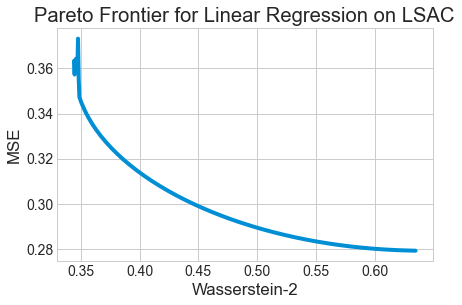

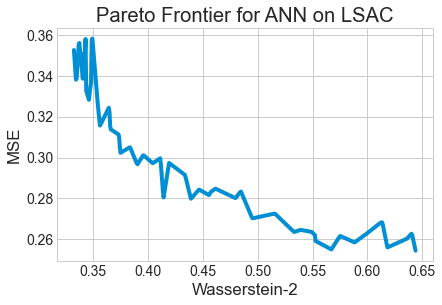

In [302]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(W2_LR, MSE_LR, kind = "linear")

X_LR_W2=np.linspace(W2_LR.min(), W2_LR.max(), 500)
Y_LR_W2=interploation_model(X_LR_W2)
 
plt.plot(X_LR_W2, Y_LR_W2)
plt.title("Pareto Frontier for Linear Regression on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("MSE")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(W2_ANN, MSE_ANN, kind = "linear")
 
X_ANN_W2=np.linspace(W2_ANN.min(), W2_ANN.max(), 500)
Y_ANN_W2=interploation_model(X_ANN_W2)
 
plt.plot(X_ANN_W2, Y_ANN_W2)
plt.title("Pareto Frontier for ANN on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("MSE")
plt.show()

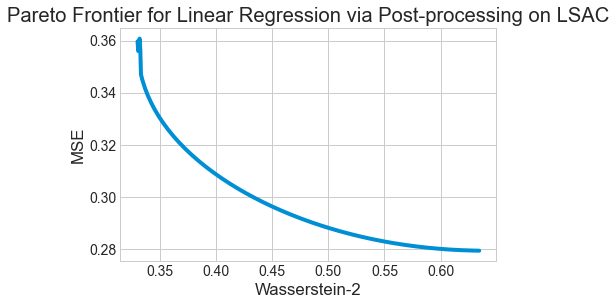

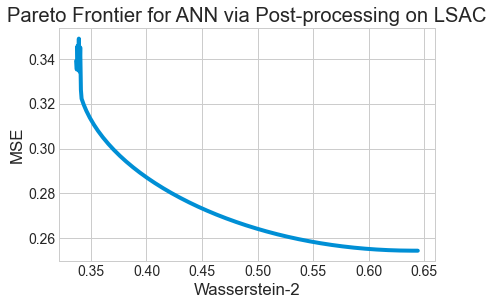

In [303]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(P_W2_LR, P_MSE_LR, kind = "linear")

P_X_LR_W2=np.linspace(P_W2_LR.min(), P_W2_LR.max(), 500)
P_Y_LR_W2=interploation_model(P_X_LR_W2)
 
plt.plot(P_X_LR_W2, P_Y_LR_W2)
plt.title("Pareto Frontier for Linear Regression via Post-processing on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("MSE")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(P_W2_ANN, P_MSE_ANN, kind = "linear")
 
P_X_ANN_W2=np.linspace(P_W2_ANN.min(), P_W2_ANN.max(), 500)
P_Y_ANN_W2=interploation_model(P_X_ANN_W2)
 
plt.plot(P_X_ANN_W2, P_Y_ANN_W2)
plt.title("Pareto Frontier for ANN via Post-processing on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("MSE")
plt.show()

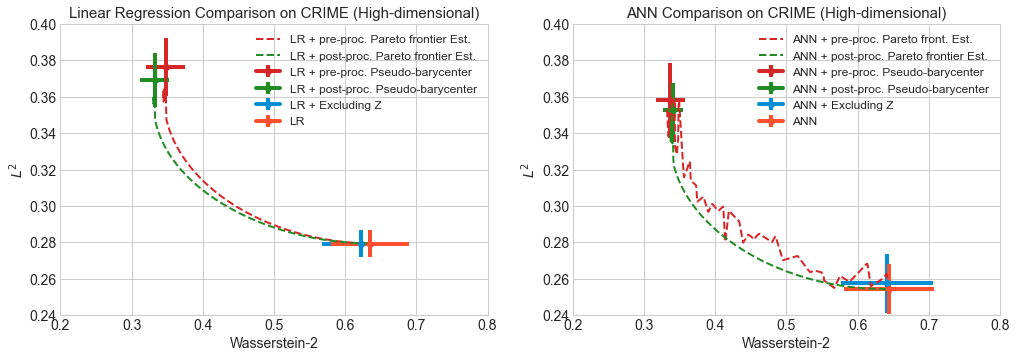

In [331]:
# Generate Figure: L2 vs W2
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight is name of style

axs[0].errorbar(W2_fair_mean, MSE_fair_mean, xerr=W2_fair_std, yerr=MSE_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_W2_fair_mean, P_MSE_fair_mean, xerr=P_W2_fair_std, yerr=P_MSE_fair_std, fmt='-o', color = 'forestgreen') # LR + post-processing pseudo-barycenter
axs[0].errorbar(W2_d_mean, MSE_d_mean, xerr=W2_d_std, yerr=MSE_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(W2_origin_mean, MSE_origin_mean, xerr=W2_origin_std, yerr=MSE_origin_std, fmt='-o') # LR
axs[0].plot(X_LR_W2,Y_LR_W2,linewidth = 2, linestyle='dashed', color = '#d62728') # data representation
axs[0].plot(P_X_LR_W2,P_Y_LR_W2,linewidth = 2, linestyle='dashed', color = 'forestgreen') # post-processing

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + pre-proc. Pareto frontier Est.','LR + post-proc. Pareto frontier Est.','LR + pre-proc. Pseudo-barycenter', 'LR + post-proc. Pseudo-barycenter','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('$L^2$', fontsize=14)
axs[0].set_xlabel('Wasserstein-2', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME (High-dimensional)", fontsize=15)
axs[0].set_ylim(0.24,0.4)
axs[0].set_xlim(0.2, 0.8)


axs[1].errorbar(W2_fair_mean_ANN, MSE_fair_mean_ANN, xerr=W2_fair_std_ANN, yerr=MSE_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_W2_fair_mean_ANN, P_MSE_fair_mean_ANN, xerr=P_W2_fair_std_ANN, yerr=P_MSE_fair_std_ANN, fmt='-o', color = 'forestgreen') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(W2_d_mean_ANN, MSE_d_mean_ANN, xerr=W2_d_std_ANN, yerr=MSE_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(W2_origin_mean_ANN, MSE_origin_mean_ANN, xerr=W2_origin_std_ANN, yerr=MSE_origin_std_ANN, fmt='-o') # ANN
axs[1].plot(X_ANN_W2,Y_ANN_W2,linewidth = 2, linestyle='dashed', color = '#d62728') # data representation
axs[1].plot(P_X_ANN_W2,P_Y_ANN_W2,linewidth = 2, linestyle='dashed', color = 'forestgreen') # post-processing

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + pre-proc. Pareto front. Est.','ANN + post-proc. Pareto frontier Est.','ANN + pre-proc. Pseudo-barycenter','ANN + post-proc. Pseudo-barycenter','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('$L^2$', fontsize=14)
axs[1].set_xlabel('Wasserstein-2', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME (High-dimensional)", fontsize=15)
axs[1].set_ylim(0.24,0.4)
axs[1].set_xlim(0.2, 0.8)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier CRIME version: L2 vs W2 11-dimensional version 4', dpi=400,bbox_inches='tight')

In [313]:
X.shape, Y.shape

((1994, 87), (1794, 11))

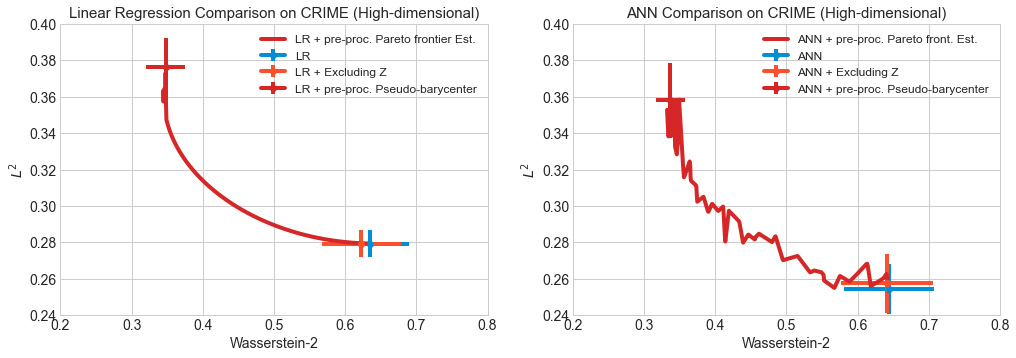

In [320]:
# Generate Figure: L2 vs W2
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight is name of style

axs[0].errorbar(W2_origin_mean, MSE_origin_mean, xerr=W2_origin_std, yerr=MSE_origin_std, fmt='-o') # LR
axs[0].errorbar(W2_d_mean, MSE_d_mean, xerr=W2_d_std, yerr=MSE_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(W2_fair_mean, MSE_fair_mean, xerr=W2_fair_std, yerr=MSE_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter data representation
axs[0].plot(X_LR_W2,Y_LR_W2,linewidth = 4, color = '#d62728') # data representation

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + pre-proc. Pareto frontier Est.','LR','LR + Excluding Z','LR + pre-proc. Pseudo-barycenter'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('$L^2$', fontsize=14)
axs[0].set_xlabel('Wasserstein-2', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME (High-dimensional)", fontsize=15)
axs[0].set_ylim(0.24,0.4)
axs[0].set_xlim(0.2, 0.8)


axs[1].errorbar(W2_origin_mean_ANN, MSE_origin_mean_ANN, xerr=W2_origin_std_ANN, yerr=MSE_origin_std_ANN, fmt='-o') # ANN
axs[1].errorbar(W2_d_mean_ANN, MSE_d_mean_ANN, xerr=W2_d_std_ANN, yerr=MSE_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(W2_fair_mean_ANN, MSE_fair_mean_ANN, xerr=W2_fair_std_ANN, yerr=MSE_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter data representation
axs[1].plot(X_ANN_W2,Y_ANN_W2,linewidth = 4, color = '#d62728') # data representation

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + pre-proc. Pareto front. Est.','ANN','ANN + Excluding Z','ANN + pre-proc. Pseudo-barycenter'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('$L^2$', fontsize=14)
axs[1].set_xlabel('Wasserstein-2', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME (High-dimensional)", fontsize=15)
axs[1].set_ylim(0.24,0.4)
axs[1].set_xlim(0.2, 0.8)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier CRIME version: L2 vs W2 11-dimensional presentation version', dpi=400,bbox_inches='tight')